<a href="https://colab.research.google.com/github/FrankAst/Forecast-de-rendimientos-de-Soja/blob/main/analisis_y_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargamos librerías y series

In [ ]:
!pip install pmdarima
!pip install --upgrade pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_yield = pd.read_csv('/content/rendimientos_soja_bs_as.csv')
#df_temp_prec = pd.read_csv('/content/variables_temp_precip.csv')
#df_temp_prec = pd.read_csv('/content/variables_temp_precip-julio-diciembre.csv')
df_temp_prec = pd.read_csv('/content/variables_temp_precip- octubre-marzo.csv')

In [ ]:
df_temp_prec.head()

campaña  weighted_avg_ratio_temp  weighted_sum_precipitation
0  1980/81                 2.171633                     1016.77
1  1981/82                 1.992710                     1119.85
2  1982/83                 2.000268                     1139.26
3  1983/84                 2.335314                     2086.67
4  1984/85                 2.077524                      932.65

In [ ]:
df_yield.head()

Provincia  Campana  Rendimiento (Kg/Ha)
0  BUENOS AIRES  1980/81               105281
1  BUENOS AIRES  1981/82               102655
2  BUENOS AIRES  1982/83                80589
3  BUENOS AIRES  1983/84               144574
4  BUENOS AIRES  1984/85               124175

In [ ]:
# Unimos los datasets

df_merged = pd.merge(df_yield, df_temp_prec, left_on=df_yield.columns[1], right_on=df_temp_prec.columns[0], how = 'inner')

# df_merged.drop(columns = 'Campana' , inplace = True)

# columns_order = ['campaña', 'Provincia'] + [col for col in df_merged.columns if col not in ['campaña', 'Provincia']]
# df_merged = df_merged[columns_order]

df_merged.head()

Provincia  Campana  Rendimiento (Kg/Ha)  campaña  \
0  BUENOS AIRES  1980/81               105281  1980/81   
1  BUENOS AIRES  1981/82               102655  1981/82   
2  BUENOS AIRES  1982/83                80589  1982/83   
3  BUENOS AIRES  1983/84               144574  1983/84   
4  BUENOS AIRES  1984/85               124175  1984/85   

   weighted_avg_ratio_temp  weighted_sum_precipitation  
0                 2.171633                     1016.77  
1                 1.992710                     1119.85  
2                 2.000268                     1139.26  
3                 2.335314                     2086.67  
4                 2.077524                      932.65

In [ ]:
# Trabajando con los registros climatograficos hasta diciembre, no necesito quitar el registro correspondiente a la campaña 2023/2024
series = df_merged.copy()

#Consigna 2

Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias. Exponer los conceptos relacionados con la estacionariedad de la serie.

## Exploración visual de las series

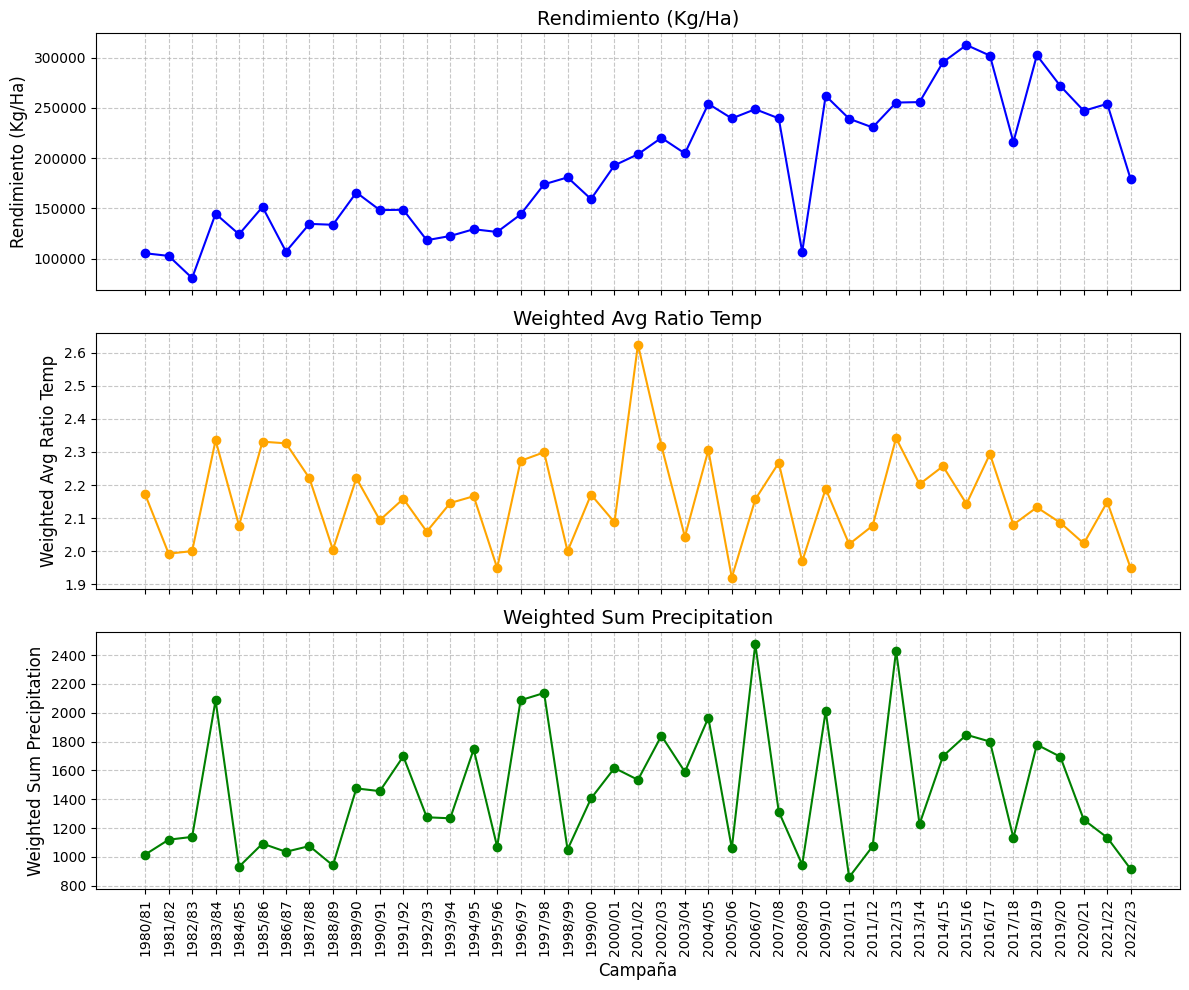

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size and number of subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot Rendimiento (Kg/Ha)
axes[0].plot(series['campaña'], series['Rendimiento (Kg/Ha)'], label='Rendimiento (Kg/Ha)', color='blue', marker='o')
axes[0].set_ylabel('Rendimiento (Kg/Ha)', fontsize=12)
axes[0].set_title('Rendimiento (Kg/Ha)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot weighted_avg_ratio_temp
axes[1].plot(series['campaña'], series['weighted_avg_ratio_temp'], label='Weighted Avg Ratio Temp', color='orange', marker='o')
axes[1].set_ylabel('Weighted Avg Ratio Temp', fontsize=12)
axes[1].set_title('Weighted Avg Ratio Temp', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot weighted_sum_precipitation
axes[2].plot(series['campaña'], series['weighted_sum_precipitation'], label='Weighted Sum Precipitation', color='green', marker='o')
axes[2].set_ylabel('Weighted Sum Precipitation', fontsize=12)
axes[2].set_title('Weighted Sum Precipitation', fontsize=14)
axes[2].set_xlabel('Campaña', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for all subplots
plt.xticks(rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Guardamos la imagen en pdf:
plt.savefig("chart.pdf", format="pdf", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


Para poder trabajar estas series con las librerias adecuadas, se debe transformar la variable 'Campaña' en un indice de tiempo con un periodo claramente definido

In [ ]:
series['start_year'] = pd.to_datetime(series['campaña'].str[:4]+ '-11-01')
series.set_index('start_year', inplace=True)
series.head()

Provincia  Campana  Rendimiento (Kg/Ha)  campaña  \
start_year                                                        
1980-11-01  BUENOS AIRES  1980/81               105281  1980/81   
1981-11-01  BUENOS AIRES  1981/82               102655  1981/82   
1982-11-01  BUENOS AIRES  1982/83                80589  1982/83   
1983-11-01  BUENOS AIRES  1983/84               144574  1983/84   
1984-11-01  BUENOS AIRES  1984/85               124175  1984/85   

            weighted_avg_ratio_temp  weighted_sum_precipitation  
start_year                                                       
1980-11-01                 2.171633                     1016.77  
1981-11-01                 1.992710                     1119.85  
1982-11-01                 2.000268                     1139.26  
1983-11-01                 2.335314                     2086.67  
1984-11-01                 2.077524                      932.65

## Transformaciones de series

- Rendimientos: Remove outliers + log transformation. Se busca estabilizar la varianza.
- Avg temperatura: -
- Precipitaciones: Box-cox. Dado que puede tomar valores cercanos a 0 (incluido), se busca estabilziar la varianza con éste método.

In [ ]:
# Reemplazo valor de rendimiento para la campaña 2008/2009 - OJO, evitar lookahead.

prev_year = series.loc['2007-11-01', 'Rendimiento (Kg/Ha)']

series.loc['2008-11-01', 'Rendimiento (Kg/Ha)'] = prev_year

In [ ]:
series['Log - Rendimiento (Kg/Ha)'] = np.log(series['Rendimiento (Kg/Ha)'])
series['BC - weighted_sum_precipitation'] , lambda_precip = boxcox(series['weighted_sum_precipitation'])
print(lambda_precip)

-0.4798962582568616


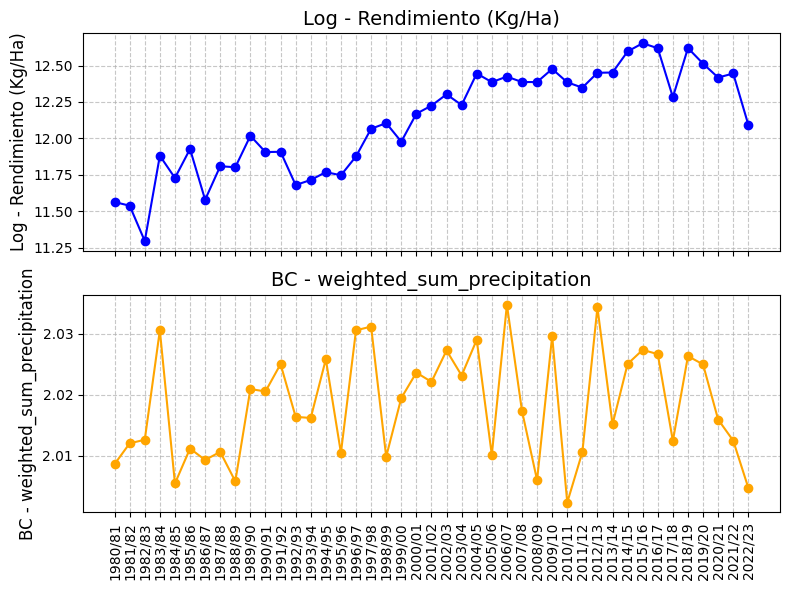

In [ ]:
# Set the figure size and number of subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot Rendimiento (Kg/Ha)
axes[0].plot(series['campaña'], series['Log - Rendimiento (Kg/Ha)'], label='Log - Rendimiento (Kg/Ha)', color='blue', marker='o')
axes[0].set_ylabel('Log - Rendimiento (Kg/Ha)', fontsize=12)
axes[0].set_title('Log - Rendimiento (Kg/Ha)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot weighted_avg_ratio_temp
axes[1].plot(series['campaña'], series['BC - weighted_sum_precipitation'], label='BC - weighted_sum_precipitation', color='orange', marker='o')
axes[1].set_ylabel('BC - weighted_sum_precipitation', fontsize=12)
axes[1].set_title('BC - weighted_sum_precipitation', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
# Rotate x-axis labels for all subplots
plt.xticks(rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()


# Show the plot
plt.show()

In [ ]:
series.drop(columns = ['Provincia','campaña'], inplace = True)

## Consigna 4: Chequeo estacionariedad Dicky Fuller

In [ ]:
def custom_ndiffs(y, regression='ct', alpha=0.05, max_d=2):
    d = 0
    current_series = y.copy()

    for _ in range(max_d + 1):
        # Run KPSS test with specified regression type
        kpss_stat, p_value, _, _ = kpss(current_series, regression=regression, nlags='auto')

        # If p-value > alpha (fail to reject null: stationary), return d
        if p_value > alpha:
            return d

        # Difference the series and increment d
        current_series = current_series.diff().dropna()
        d += 1

    return d

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

def check_non_stationarity(series, column_name, seasonal_period=None):
    """
    Perform a comprehensive check for non-stationarity:
    - Unit roots (ADF, KPSS)
    - Trends and seasonality (decomposition and seasonal differencing)
    """
    results = {}
    print(f"=== Comprehensive Non-Stationarity Analysis for '{column_name}' ===")

    # 1. Seasonal Decomposition
    try:
        decomposition = seasonal_decompose(series.dropna(), period=seasonal_period)
        seasonal_strength = decomposition.seasonal.std() / decomposition.resid.std()
        print(f"\nSeasonal Strength: {seasonal_strength:.2f}")
        if seasonal_strength > 0.5:
            print("- ⚠️ Strong seasonality detected. Applying seasonal differencing.")
        elif seasonal_strength > 0.1:
            print("- ⚠️ Mild seasonality detected. Applying seasonal differencing.")
        else:
            print("- No significant seasonality detected.")
    except:
        seasonal_strength = None
        print("- Seasonal decomposition failed (likely insufficient data).")

    # 2. Seasonal Differencing (manual)
    if seasonal_strength is not None and seasonal_strength > 0.1:
        print("\nApplying seasonal differencing...")
        # Manually difference using pandas shift
        series_diff = series - series.shift(seasonal_period)
        series_diff = series_diff.dropna()  # Remove NaNs after differencing
    else:
        series_diff = series.dropna()

    # 3. Augmented Dickey-Fuller Test (unit root)
    def run_adf(regression):
        dftest = adfuller(series_diff, autolag='AIC', regression=regression)
        return {
            'Test Statistic': dftest[0],
            'p-value': dftest[1],
            'Critical Values': dftest[4]
        }

    adf_results = {
        'ADF (constant)': run_adf('c'),
        'ADF (trend)': run_adf('ct')
    }

    # 4. KPSS Test (stationarity around trend/level)
    kpss_stat, kpss_p, _, kpss_cv = kpss(series_diff, regression='ct', nlags='auto')
    kpss_results = {
        'Test Statistic': kpss_stat,
        'p-value': kpss_p,
        'Critical Values': kpss_cv
    }

    # Compile results
    results = {
        'ADF Tests': adf_results,
        'KPSS Test': kpss_results,
        'Seasonal Strength': seasonal_strength
    }

    # ndiffs
    n_adf = ndiffs(series, test='adf')  # Augmented Dickey-Fuller
    n_kpss = custom_ndiffs(series, regression='ct', alpha=0.05) # KPSS (different null hypothesis)

    # Print conclusions
    print("\n=== Conclusions ===")

    # Unit roots
    if adf_results['ADF (trend)']['p-value'] <= 0.05:
        print("- ✅ Reject unit root (ADF with trend): Data is likely trend-stationary.")
    elif adf_results['ADF (constant)']['p-value'] <= 0.05:
        print("- ✅ Reject unit root (ADF with constant): Data is stationary.")
    else:
        print("- ❌ Fail to reject unit root: Data may be non-stationary.")

    # KPSS
    if kpss_p < 0.05:
        print("- ❌ KPSS rejects stationarity: Series may have a trend or unit root.")
    else:
        print("- ✅ KPSS supports stationarity.")

    # Differencing:
    print("\n")
    print(f"ADF suggests {n_adf} differences")
    print(f"KPSS suggests {n_kpss} differences")
    print("\n")

    return results

**Rendimientos**

In [ ]:
check_non_stationarity(series['Log - Rendimiento (Kg/Ha)'], 'Log - Rendimiento (Kg/Ha)')

=== Comprehensive Non-Stationarity Analysis for 'Log - Rendimiento (Kg/Ha)' ===
- Seasonal decomposition failed (likely insufficient data).

=== Conclusions ===
- ❌ Fail to reject unit root: Data may be non-stationary.
- ✅ KPSS supports stationarity.


ADF suggests 1 differences
KPSS suggests 0 differences




{'ADF Tests': {'ADF (constant)': {'Test Statistic': -1.7506392312812393,
   'p-value': 0.40522838377021014,
   'Critical Values': {'1%': -3.60098336718852,
    '5%': -2.9351348158036012,
    '10%': -2.6059629803688282}},
  'ADF (trend)': {'Test Statistic': -3.252122471642374,
   'p-value': 0.07450694858706422,
   'Critical Values': {'1%': -4.1922463983371125,
    '5%': -3.520758216175359,
    '10%': -3.1911390346614836}}},
 'KPSS Test': {'Test Statistic': 0.14515134331059698,
  'p-value': 0.05157158646185743,
  'Critical Values': {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}},
 'Seasonal Strength': None}

**Precipitaciones**

In [ ]:
check_non_stationarity(series['BC - weighted_sum_precipitation'], 'BC - weighted_sum_precipitation')

=== Comprehensive Non-Stationarity Analysis for 'BC - weighted_sum_precipitation' ===
- Seasonal decomposition failed (likely insufficient data).

=== Conclusions ===
- ✅ Reject unit root (ADF with trend): Data is likely trend-stationary.
- ❌ KPSS rejects stationarity: Series may have a trend or unit root.


ADF suggests 1 differences
KPSS suggests 2 differences




{'ADF Tests': {'ADF (constant)': {'Test Statistic': -6.7620324818565605,
   'p-value': 2.7765551583116323e-09,
   'Critical Values': {'1%': -3.596635636000432,
    '5%': -2.933297331821618,
    '10%': -2.6049909750566895}},
  'ADF (trend)': {'Test Statistic': -6.810510331339645,
   'p-value': 3.774616587823919e-08,
   'Critical Values': {'1%': -4.1922463983371125,
    '5%': -3.520758216175359,
    '10%': -3.1911390346614836}}},
 'KPSS Test': {'Test Statistic': 0.14617529576113392,
  'p-value': 0.04985392019905507,
  'Critical Values': {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}},
 'Seasonal Strength': None}

**Temperaturas**

In [ ]:
check_non_stationarity(series['weighted_avg_ratio_temp'], 'Weighted Avg Ratio Temp')

=== Comprehensive Non-Stationarity Analysis for 'Weighted Avg Ratio Temp' ===
- Seasonal decomposition failed (likely insufficient data).

=== Conclusions ===
- ✅ Reject unit root (ADF with trend): Data is likely trend-stationary.
- ✅ KPSS supports stationarity.


ADF suggests 0 differences
KPSS suggests 0 differences




{'ADF Tests': {'ADF (constant)': {'Test Statistic': -3.6728172974197513,
   'p-value': 0.004512162089235268,
   'Critical Values': {'1%': -3.639224104416853,
    '5%': -2.9512301791166293,
    '10%': -2.614446989619377}},
  'ADF (trend)': {'Test Statistic': -3.5920512172117185,
   'p-value': 0.03052459947215142,
   'Critical Values': {'1%': -4.253042608385915,
    '5%': -3.5485904579686545,
    '10%': -3.2070617952371263}}},
 'KPSS Test': {'Test Statistic': 0.06336073351683831,
  'p-value': 0.1,
  'Critical Values': {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}},
 'Seasonal Strength': None}

Se diferencia sólamente los rendimientos y precipitaciones:

In [ ]:
series['Diff - Log - Rendimiento (Kg/Ha)'] = series['Log - Rendimiento (Kg/Ha)'].diff( periods = 1)
series['Diff - BC - weighted_sum_precipitation'] = series['BC - weighted_sum_precipitation'].diff( periods = 1)
series.dropna(inplace=True)

In [ ]:
series.head()

Campana  Rendimiento (Kg/Ha)  weighted_avg_ratio_temp  \
start_year                                                          
1981-11-01  1981/82               102655                 1.992710   
1982-11-01  1982/83                80589                 2.000268   
1983-11-01  1983/84               144574                 2.335314   
1984-11-01  1984/85               124175                 2.077524   
1985-11-01  1985/86               151411                 2.331170   

            weighted_sum_precipitation  Log - Rendimiento (Kg/Ha)  \
start_year                                                          
1981-11-01                     1119.85                  11.539129   
1982-11-01                     1139.26                  11.297117   
1983-11-01                     2086.67                  11.881547   
1984-11-01                      932.65                  11.729447   
1985-11-01                     1092.63                  11.927753   

            BC - weighted_sum_precipitation  Diff - Log - Rendimiento (Kg/Ha)  \
start_year                                                                      
1981-11-01                         2.012075                         -0.025259   
1982-11-01                         2.012664                         -0.242012   
1983-11-01                         2.030590                          0.584429   
1984-11-01                         2.005496                         -0.152100   
1985-11-01                         2.011223                          0.198306   

            Diff - BC - weighted_sum_precipitation  
start_year                                          
1981-11-01                                0.003401  
1982-11-01                                0.000589  
1983-11-01                                0.017926  
1984-11-01                               -0.025095  
1985-11-01                                0.005728

Visualización series diferenciadas:

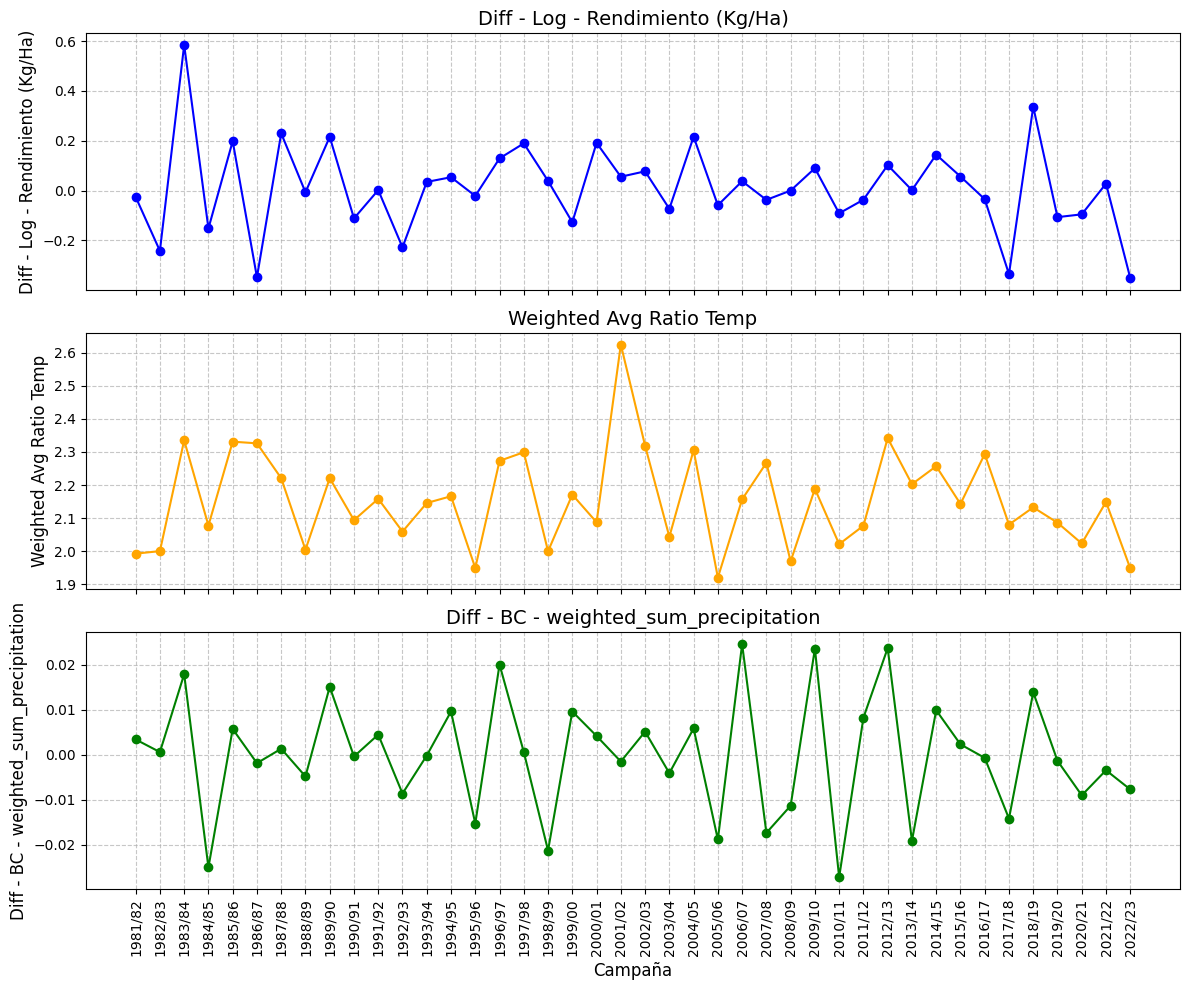

In [ ]:

# Set the figure size and number of subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot Rendimiento (Kg/Ha)
axes[0].plot(series['Campana'], series['Diff - Log - Rendimiento (Kg/Ha)'], label='Diff - Log - Rendimiento (Kg/Ha)', color='blue', marker='o')
axes[0].set_ylabel('Diff - Log - Rendimiento (Kg/Ha)', fontsize=12)
axes[0].set_title('Diff - Log - Rendimiento (Kg/Ha)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot weighted_avg_ratio_temp
axes[1].plot(series['Campana'], series['weighted_avg_ratio_temp'], label='Weighted Avg Ratio Temp', color='orange', marker='o')
axes[1].set_ylabel('Weighted Avg Ratio Temp', fontsize=12)
axes[1].set_title('Weighted Avg Ratio Temp', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot weighted_sum_precipitation
axes[2].plot(series['Campana'], series['Diff - BC - weighted_sum_precipitation'], label='Diff - BC - weighted_sum_precipitation', color='green', marker='o')
axes[2].set_ylabel('Diff - BC - weighted_sum_precipitation', fontsize=12)
axes[2].set_title('Diff - BC - weighted_sum_precipitation', fontsize=14)
axes[2].set_xlabel('Campaña', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for all subplots
plt.xticks(rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Guardamos la imagen en pdf:
plt.savefig("chart.pdf", format="pdf", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


# Consigna 3



## Descomposición de series - No se observará estacionalidad dado que la frequencia es anual:

In [ ]:
def decompose_series(series, model="additive", figsize=(12, 8)):
    """
    Performs additive or multiplicative decomposition of a time series and plots the result.

    Args:
        series (pd.Series): The time series data.
        model (str): The decomposition model ("additive" or "multiplicative").
                     Defaults to "additive".
        figsize (tuple): The size of the figure for the plot (width, height).
                         Defaults to (12, 8).

    Returns:
        statsmodels.tsa.seasonal.DecomposeResult: The decomposition result object.
    """
    try:
        decomposition = seasonal_decompose(series, model=model, period = 1)

        # Plot the decomposition
        fig = decomposition.plot()
        fig.set_size_inches(figsize)  # Set the figure size
        plt.tight_layout()


        return decomposition
    except Exception as e:
        print(f"Error during decomposition: {e}")
        return None

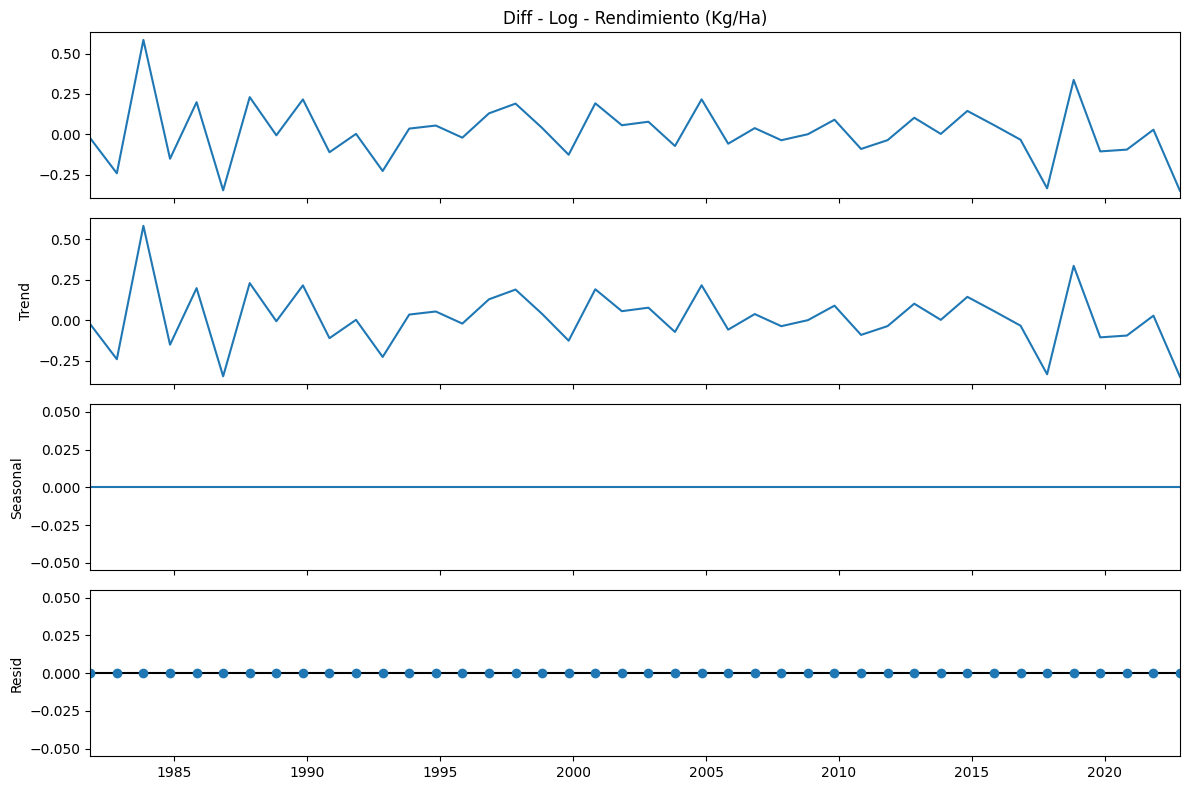

In [ ]:
decompose_series(series['Diff - Log - Rendimiento (Kg/Ha)'], model="additive")

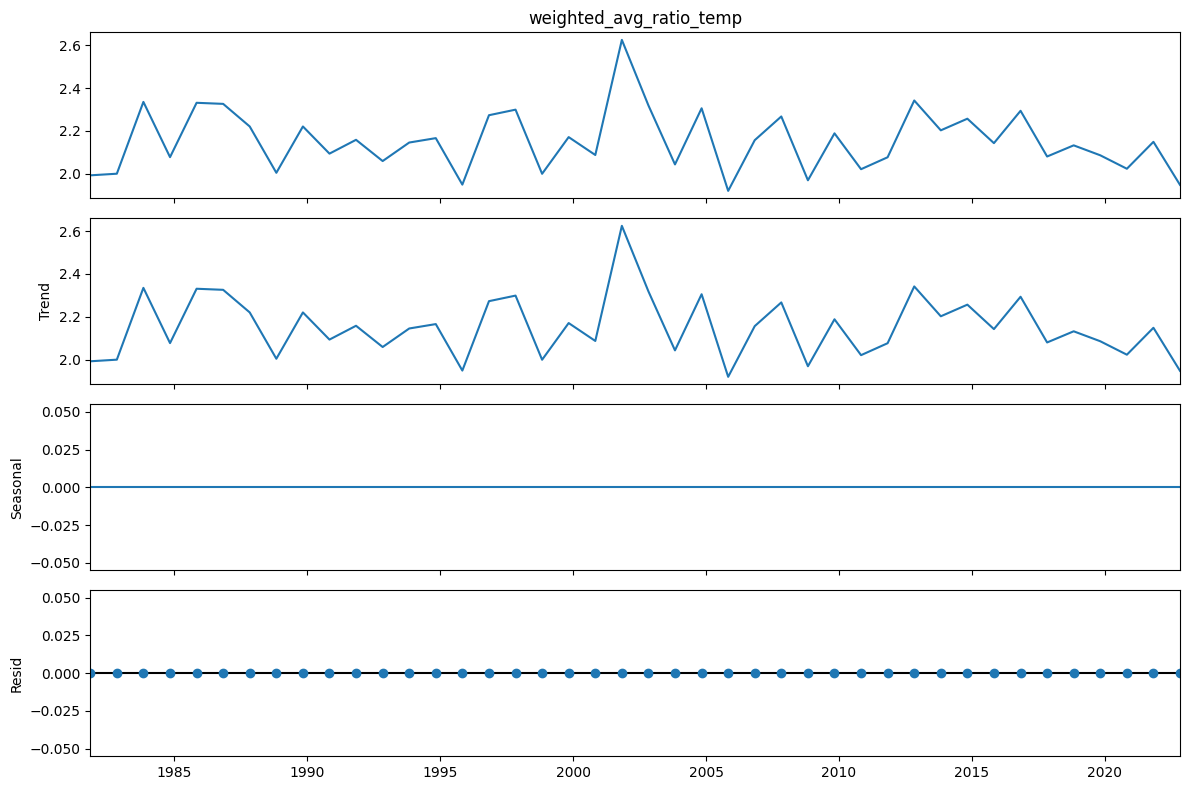

In [ ]:
decompose_series(series['weighted_avg_ratio_temp'], model="additive")


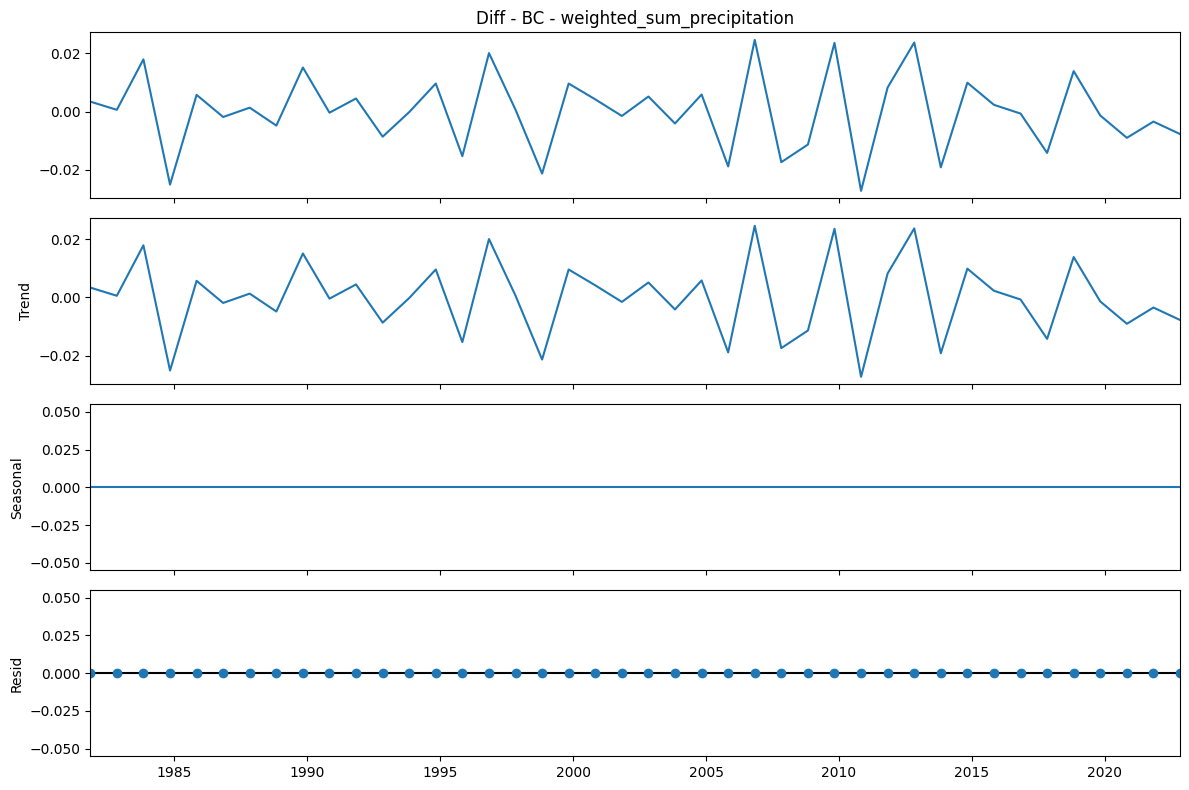

In [ ]:
decompose_series(series['Diff - BC - weighted_sum_precipitation'], model = "additive")

## FAS - ACF - PACF

In [ ]:
def autocovariance(df, col_name, lags_calc):
    autocov = []
    lags = np.arange(lags_calc)

    series_mean = np.mean(df[col_name])
    n = len(df[col_name])

    for lag in lags:
        cov = np.sum((df[col_name][:n-lag] - series_mean) * (df[col_name][lag:] - series_mean)) / n
        autocov.append(cov)

    return autocov, lags



# prompt: make a function that receives a dataframe, col name and number of lags ->   plots acf and pacf functions from statsmodels
def plot_autocv_acf_pacf(df, col_name, lags):
    fig, axes = plt.subplots(3, 1, figsize=(15, 11))

    autocov, lags = autocovariance(df, col_name, lags)
    axes[0].stem(lags, autocov)
    axes[0].set_title('Autocovarianza')

    plot_acf(df[col_name], lags=lags, ax=axes[1])
    plot_pacf(df[col_name], lags=lags, ax=axes[2])



    # Guardamos la imagen en pdf:
    #plt.savefig("ACF-PACF-yield-chart.pdf", format="pdf", dpi=300, bbox_inches="tight")


    plt.show()

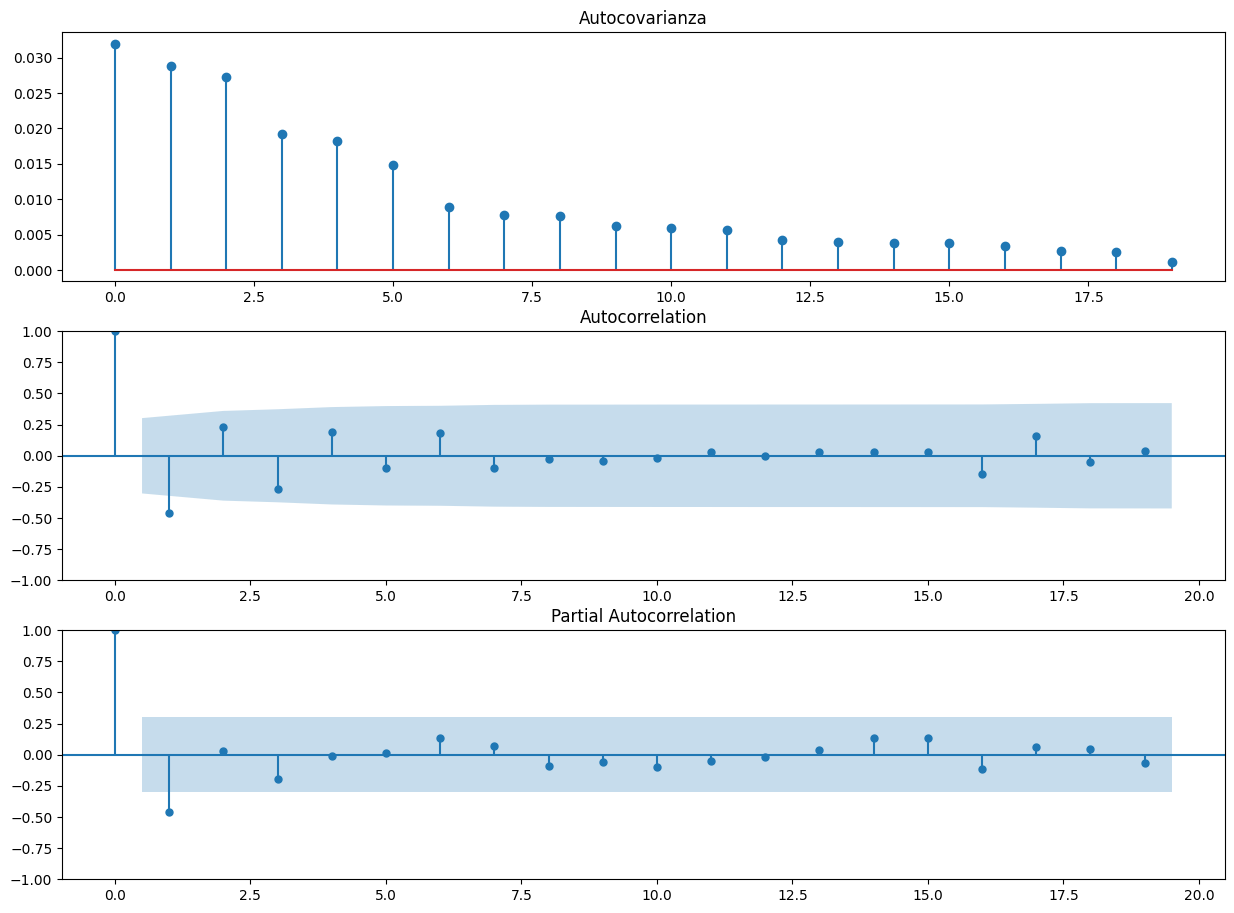

In [ ]:
plot_autocv_acf_pacf(series, 'Diff - Log - Rendimiento (Kg/Ha)', 20)

Posible modelo ARIMA (1,0,1)

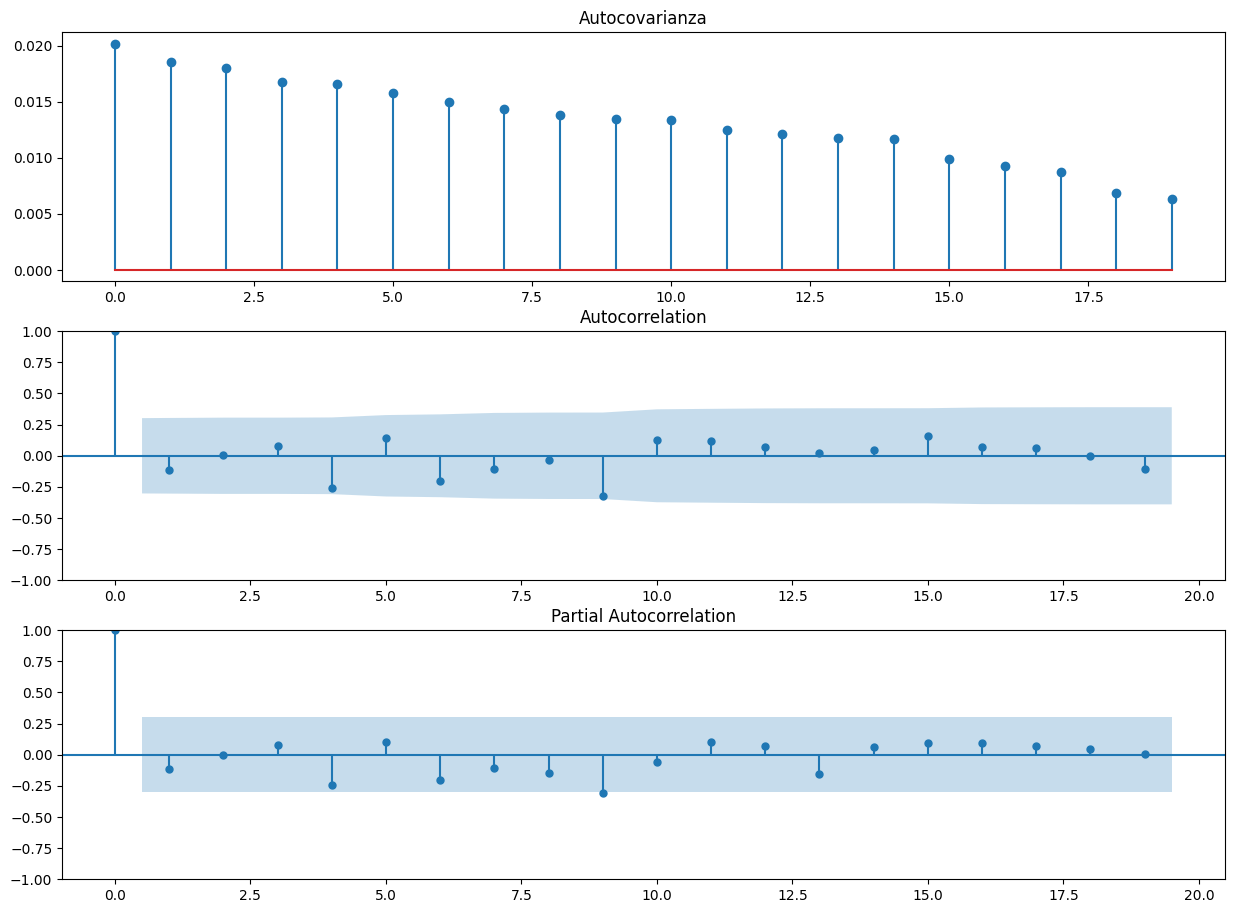

In [ ]:
plot_autocv_acf_pacf(series, 'weighted_avg_ratio_temp', 20)

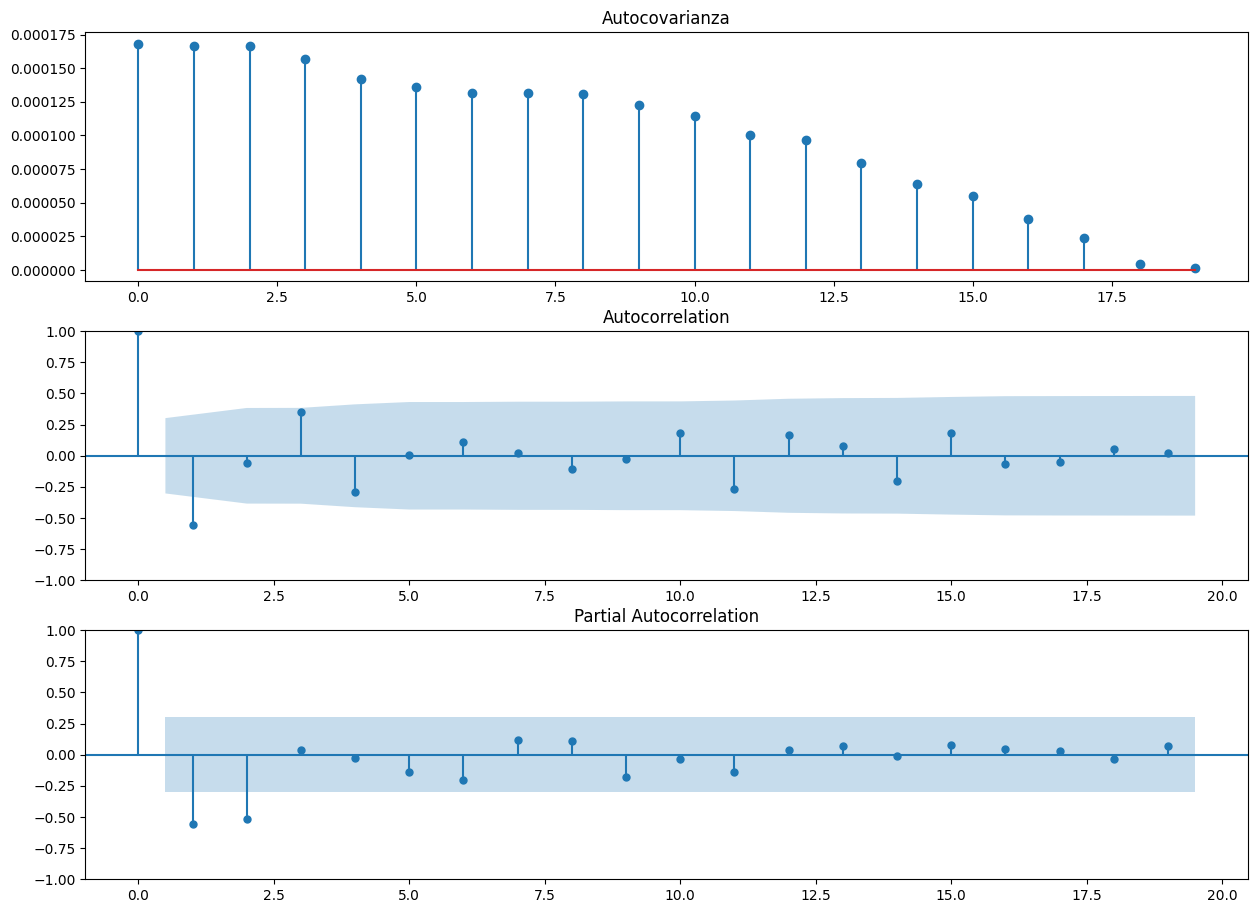

In [ ]:
plot_autocv_acf_pacf(series, 'Diff - BC - weighted_sum_precipitation', 20)

Posible ARIMA (2,0,0)

# Consigna 5: Modelos ARIMA

In [ ]:
# #Seleccionamos el primer 80% para train
train = series.iloc[:round(len(series)*.80)]
# # Seleccionamos el 20% restante para test
test = series.iloc[round(len(series)*.80):]


Función para visualizar residuos:

In [ ]:
def plot_model_diagnostics(residuals, fitted_values, training_data, test_data=None, predictions=None):
    """
    Plots diagnostic charts for a time series model.

    Parameters:
    - residuals: Array-like, the residuals from the model.
    - fitted_values: Array-like, the fitted values from the model.
    - training_data: Array-like, the original training data.
    - test_data: Array-like, optional, the test data.
    - predictions: Array-like, optional, the predicted values.
    """
    plt.figure(figsize=(20, 15))

    # 1. Series vs Residuos
    plt.subplot(3, 2, 1)
    plt.plot(residuals, label='Residuals', color='red')
    plt.plot(training_data, label='Training Data', color='blue', alpha=0.7)
    plt.title("Series vs Residuals", size=16)
    plt.legend()

    # 2. Histograma residuos
    plt.subplot(3, 2, 2)
    residuals_mean = np.mean(residuals)
    plt.hist(residuals, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(residuals_mean, color='red', linestyle='--', linewidth=1, label=f'Mean: {residuals_mean:.2f}')
    plt.title('Histogram of Residuals', size=16)
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.legend()

    # 3. Residuos vs Fitted Values
    plt.subplot(3, 2, 3)
    plt.scatter(fitted_values, residuals, alpha=0.7, edgecolor='black')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title('Residuals vs Fitted Values', size=16)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

    # 4. ACF and PACF of Residuals
    plt.subplot(3, 2, 4)
    plot_acf(residuals, lags=30, ax=plt.gca())
    plt.title('ACF of Residuals', size=16)

    plt.subplot(3, 2, 6)
    plot_pacf(residuals, lags=len(residuals)//2, ax=plt.gca())
    plt.title('PACF of Residuals', size=16)

    # 5. Series vs Fitted Values and Predictions
    plt.subplot(3, 2, 5)
    plt.plot(training_data, label='Training Data', color='blue', alpha=0.7)
    plt.plot(fitted_values, label='Fitted Values', color='orange', linestyle='--', alpha=0.7)
    plt.plot(test_data.index, test_data, label = 'Test', color='green', alpha=0.7)
    if predictions is not None and test_data is not None:
        plt.plot(test_data.index, predictions, label='Predictions', color='red', linestyle='-.', alpha=0.7)
    plt.title('Series vs Fitted Values and Predictions', size=16)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

Función para evaluar métricas:

In [ ]:
def evaluar_metricas(serie_test, serie_pred):
    # MSE muy sensible a valores atípicos
    #print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')

    # MAE: Mean absolute error
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')

    # RMSE: Root mean square error.
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    # MAPE puede traer problemas con valores cercanos a 0
    #print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')




## Rendimientos

### Autoarima

In [ ]:

model = auto_arima(train['Diff - Log - Rendimiento (Kg/Ha)'],
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=3,
                    start_P=0,
                    seasonal=False, #Esto NO le permite a auto_arima considerar modelos estacionales
                    d=None,
                    D=None,
                    trace=True, #Muestra en pantalla el proceso de búsqueda de modelos
                    error_action='ignore',
                    information_criterion='bic',
                    suppress_warnings=True,
                    stepwise=True)

model.summary()

Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-20.720, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=-26.108, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=-24.226, Time=1.48 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=-23.150, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-25.552, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-22.025, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-25.759, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 2.528 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  16.580
Date:                Tue, 04 Mar 2025   AIC                            -29.160
Time:                        19:25:29   BIC                            -26.108
Sample:                    11-01-1981   HQIC                           -28.119
                         - 11-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4777      0.180     -2.660      0.008      -0.830      -0.126
sigma2         0.0219      0.006      3.966      0.000       0.011       0.033
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.47
Prob(Q):                              0.83   Prob(JB):                         0.29
Heteroskedasticity (H):               0.19   Skew:                             0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Revisión de residuos:

In [ ]:
# Residuos
residuals_autoarima = model.resid()
# Valores ajustados en train
fitted_values_autoarima = model.fittedvalues()
# Predicciones test
n_per = len(test)
predictions = model.predict(n_periods= n_per)

In [ ]:
n_per

8

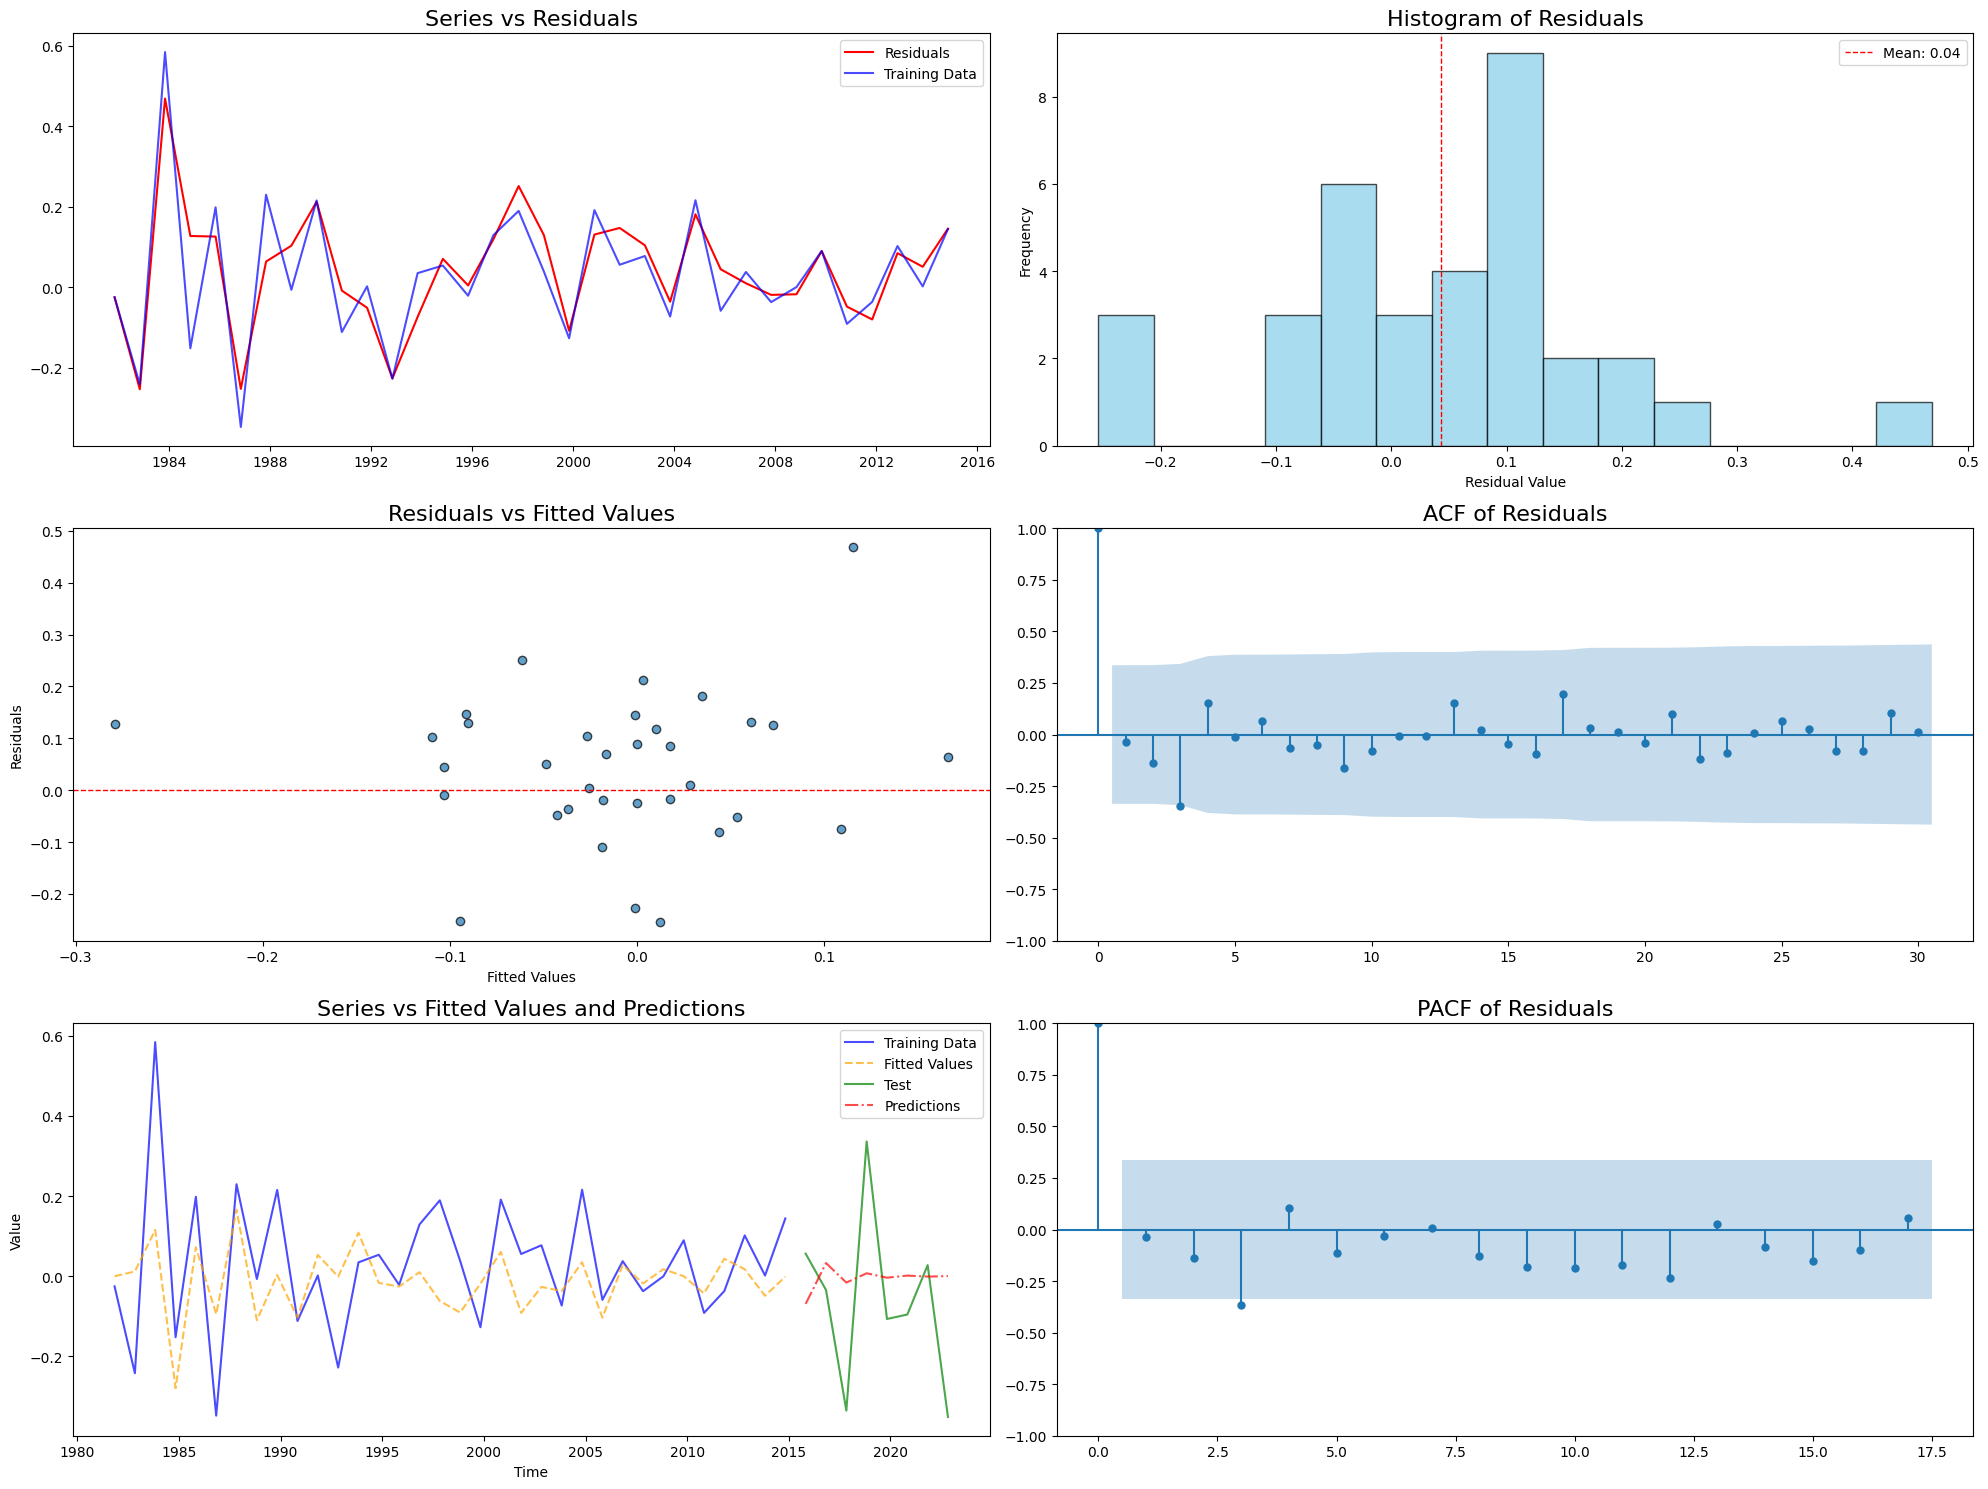

In [ ]:
plot_model_diagnostics(residuals_autoarima,
                       fitted_values_autoarima,
                       training_data = train['Diff - Log - Rendimiento (Kg/Ha)'],
                       test_data = test['Diff - Log - Rendimiento (Kg/Ha)'],
                       predictions = predictions
                       )

Evaluación:

In [ ]:
print('Training metrics')
evaluar_metricas(train['Diff - Log - Rendimiento (Kg/Ha)'], fitted_values_autoarima)
print('----------------------')
print('Test metrics')
evaluar_metricas(test['Diff - Log - Rendimiento (Kg/Ha)'], predictions)

Training metrics
MAE: 0.11368035258538607
RMSE: 0.14803579737290545
----------------------
Test metrics
MAE: 0.17769873275892747
RMSE: 0.2165190698296198


El modelo no parece capturar los patrones de la serie correctamente, y los residuos aún contienen demasiada variabilidad. Se probará fiteando un modelo más complejo.

### ARIMA(2,0,0)

In [ ]:
model_r201 = ARIMA(train['Diff - Log - Rendimiento (Kg/Ha)'], order=(2, 0, 0), trend='n')
results_r201 = model_r201.fit()
print(results_r201.summary())

                                      SARIMAX Results                                       
Dep. Variable:     Diff - Log - Rendimiento (Kg/Ha)   No. Observations:                   34
Model:                               ARIMA(2, 0, 0)   Log Likelihood                  16.864
Date:                              Tue, 04 Mar 2025   AIC                            -27.729
Time:                                      19:25:31   BIC                            -23.150
Sample:                                  11-01-1981   HQIC                           -26.167
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4099      0.204     -2.007      0.045      -0.810      -0.010
ar.L2          0.13

El coeficiente autorregresivo ar.L2 no es estadísticamente significativo. Se descarta ARIMA(2,0,0)

## Temperatura

Autoarima

In [ ]:
model_t = auto_arima(train['weighted_avg_ratio_temp'],
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    start_P=0,
                    seasonal=False, #Esto NO le permite a auto_arima considerar modelos estacionales
                    d=None,
                    D=None,
                    trace=True, #Muestra en pantalla el proceso de búsqueda de modelos
                    error_action='ignore',
                    information_criterion='bic',
                    suppress_warnings=True,
                    stepwise=True)

model_t.summary()

Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=152.698, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=inf, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-25.980, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-23.063, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-23.177, Time=0.65 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-22.494, Time=2.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 4.205 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:                        SARIMAX   Log Likelihood                  16.516
Date:                Tue, 04 Mar 2025   AIC                            -29.032
Time:                        19:25:35   BIC                            -25.980
Sample:                    11-01-1981   HQIC                           -27.991
                         - 11-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1650      0.028     78.212      0.000       2.111       2.219
sigma2         0.0222      0.005      4.367      0.000       0.012       0.032
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 2.81
Prob(Q):                              0.42   Prob(JB):                         0.25
Heteroskedasticity (H):               1.08   Skew:                             0.63
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Revisión de residuos:

In [ ]:
# Residuos
residuals_autoarima_t = model_t.resid()
# Valores ajustados en train
fitted_values_autoarima_t = model_t.fittedvalues()
# Predicciones test
predictions_t = model_t.predict(n_periods= n_per)

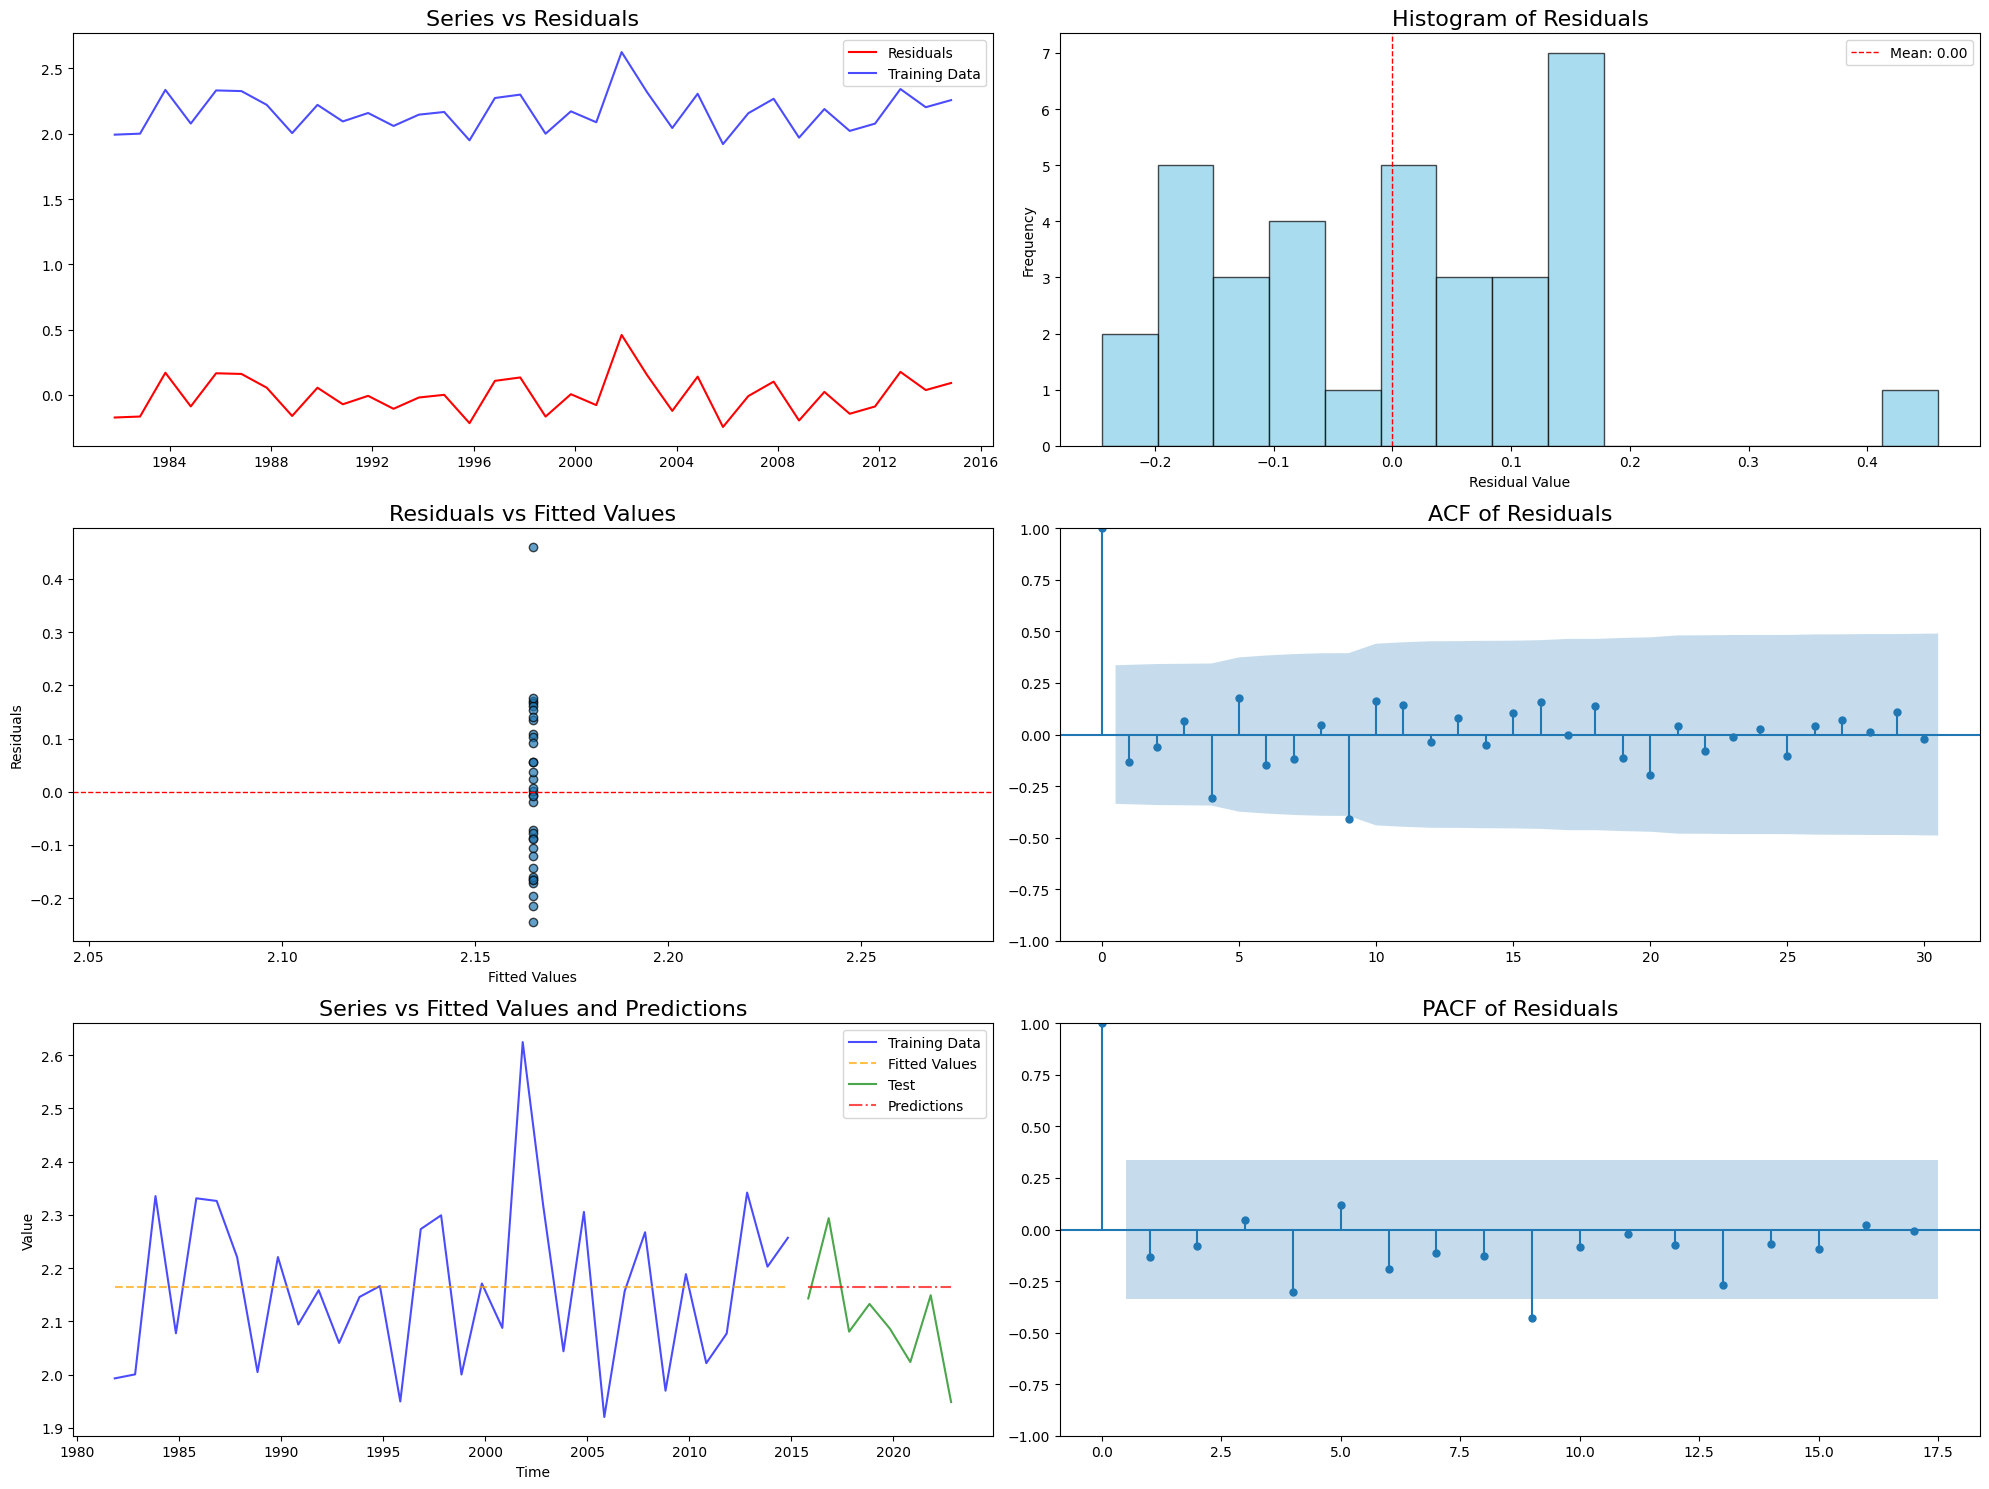

In [ ]:
plot_model_diagnostics(residuals_autoarima_t,
                       fitted_values_autoarima_t,
                       training_data = train['weighted_avg_ratio_temp'],
                       test_data = test['weighted_avg_ratio_temp'],
                       predictions = predictions_t
                       )

Resultados de métricas:

In [ ]:
print('Training metrics')
evaluar_metricas(train['weighted_avg_ratio_temp'], fitted_values_autoarima_t)
print('----------------------')
print('Test metrics')
evaluar_metricas(test['weighted_avg_ratio_temp'], predictions_t)

Training metrics
MAE: 0.12037479640713337
RMSE: 0.14886584793539062
----------------------
Test metrics
MAE: 0.09007373068065619
RMSE: 0.11109341352049493


Pareciera que la temperatura se mantiene dentro de un rango acotado en el tiempo, donde un modelo ARIMA no presenta resultados relevantes.

## Precipitaciones

### Autoarima

In [ ]:
model_p = auto_arima(train['Diff - BC - weighted_sum_precipitation'],
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    start_P=0,
                    seasonal=False, #Esto NO le permite a auto_arima considerar modelos estacionales
                    d=None,
                    D=None,
                    trace=True, #Muestra en pantalla el proceso de búsqueda de modelos
                    error_action='ignore',
                    information_criterion='bic',
                    suppress_warnings=True,
                    stepwise=True)

model_p.summary()

Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-191.045, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=-201.467, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=-211.824, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-210.543, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-210.743, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-207.241, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-210.394, Time=0.13 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.027 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 109.438
Date:                Tue, 04 Mar 2025   AIC                           -214.877
Time:                        19:25:38   BIC                           -211.824
Sample:                    11-01-1981   HQIC                          -213.836
                         - 11-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9526      0.092    -10.361      0.000      -1.133      -0.772
sigma2      8.738e-05   2.92e-05      2.994      0.003    3.02e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.23   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.13   Prob(JB):                         0.54
Heteroskedasticity (H):               1.93   Skew:                            -0.20
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El autoarima propone una modelo de medias móviles de órden 1.

Revisión de residuos:

In [ ]:
# Residuos
residuals_autoarima_p = model_p.resid()
# Valores ajustados en train
fitted_values_autoarima_p = model_p.fittedvalues()
# Predicciones test
predictions_p = model_p.predict(n_periods= n_per) #, in_sample = True)

In [ ]:
predictions_p

2015-11-01   -0.006076
2016-11-01    0.000000
2017-11-01    0.000000
2018-11-01    0.000000
2019-11-01    0.000000
2020-11-01    0.000000
2021-11-01    0.000000
2022-11-01    0.000000
Freq: YS-NOV, dtype: float64

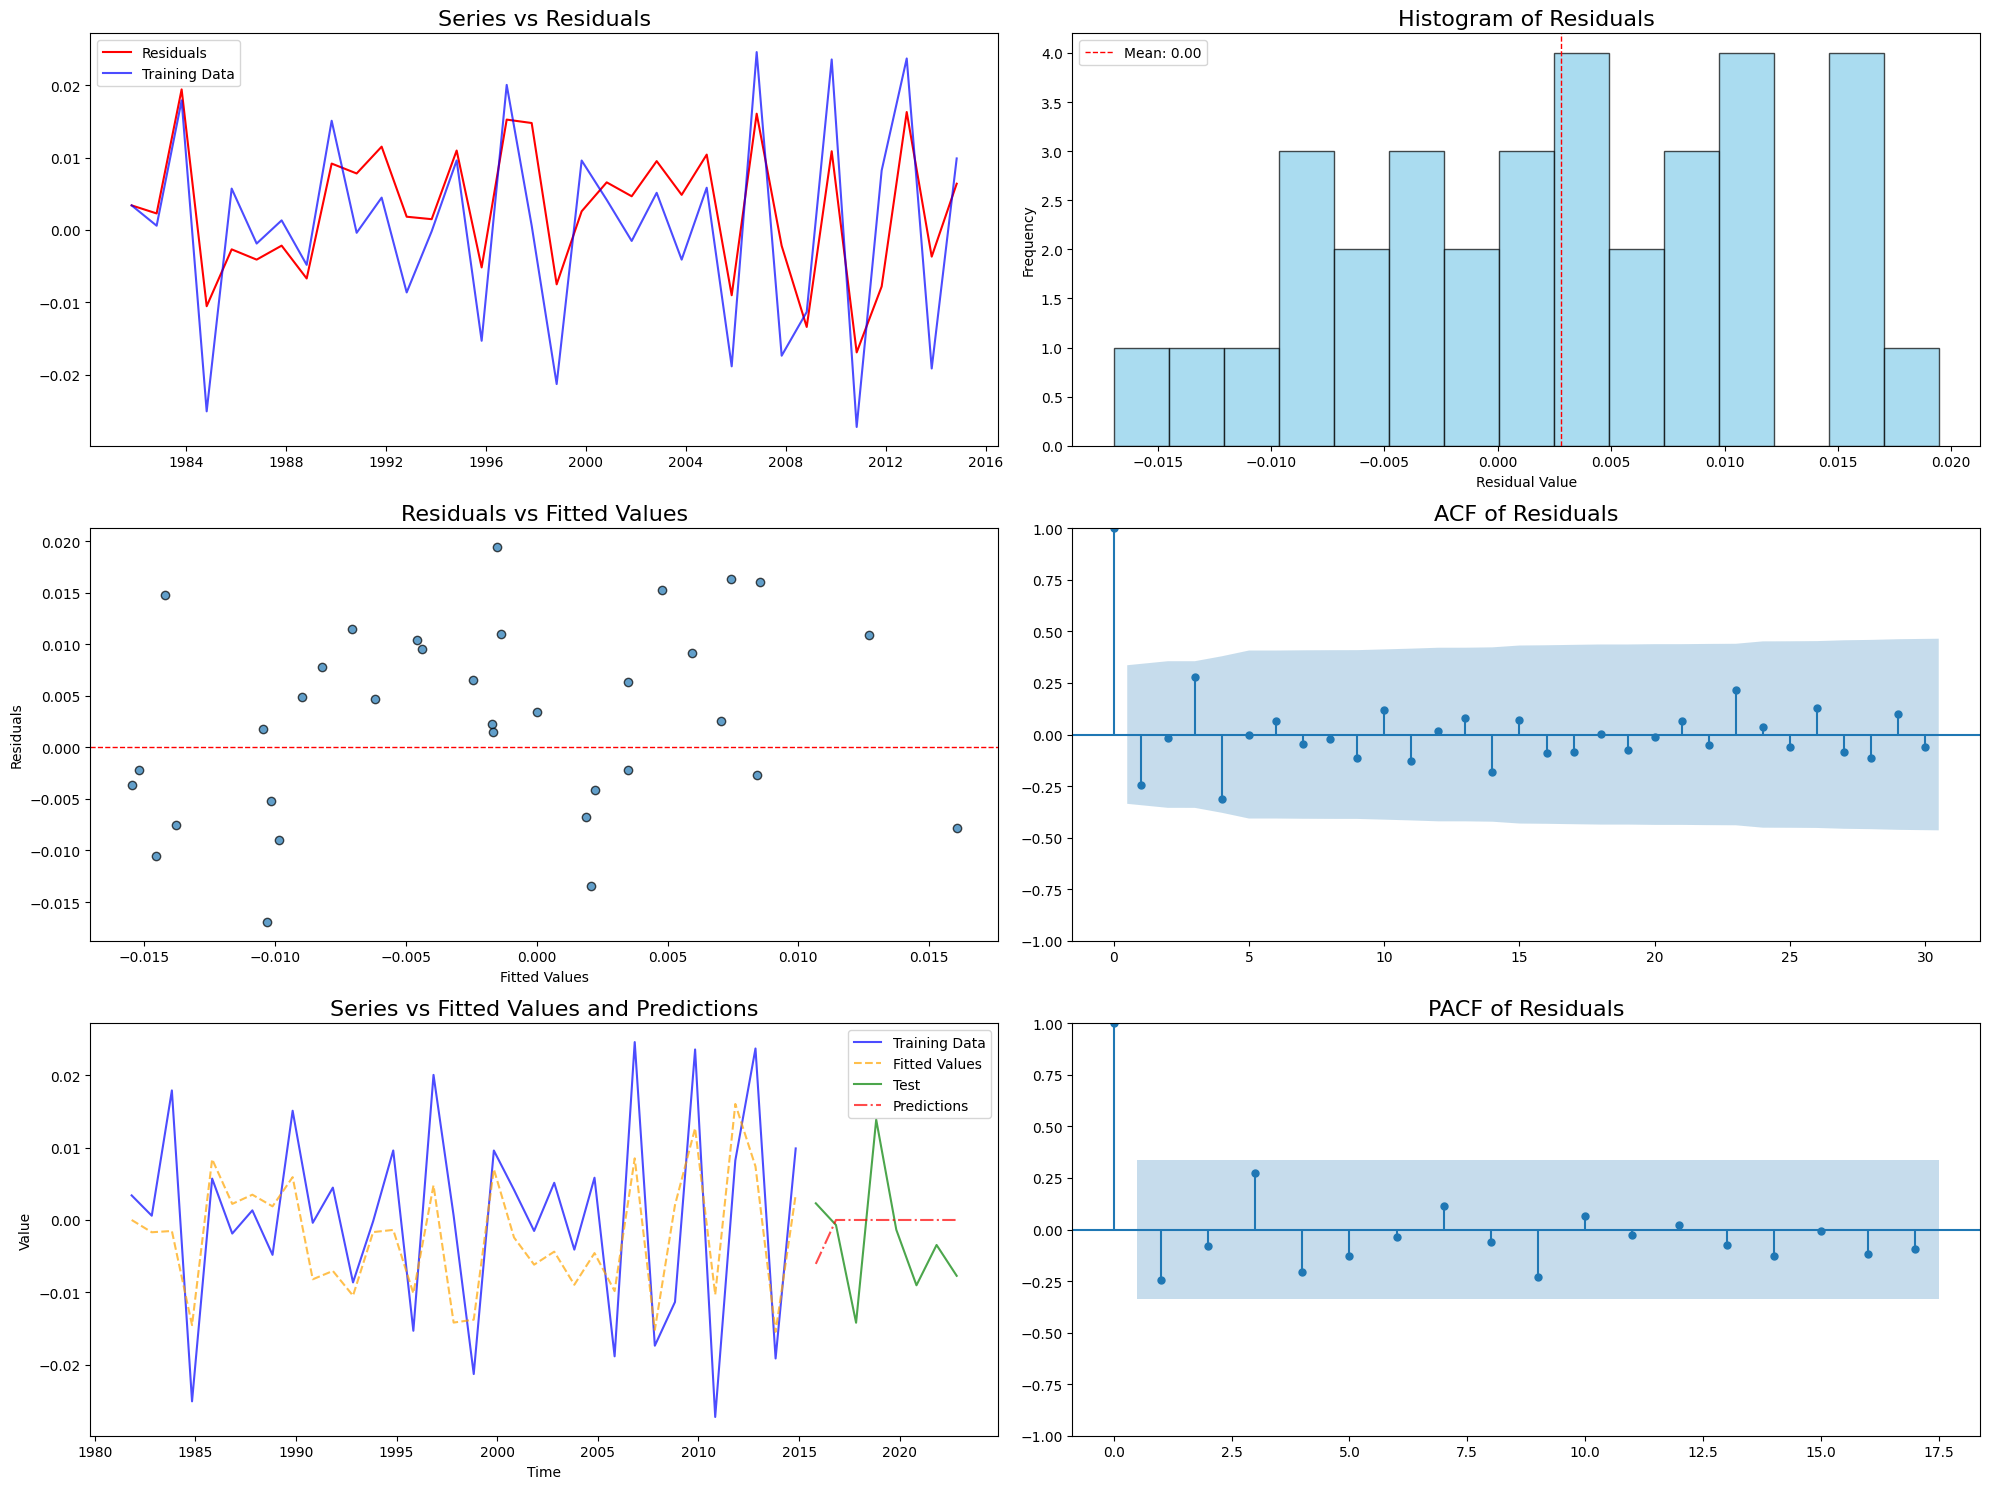

In [ ]:
plot_model_diagnostics(residuals_autoarima_p,
                       fitted_values_autoarima_p,
                       training_data = train['Diff - BC - weighted_sum_precipitation'],
                       test_data = test['Diff - BC - weighted_sum_precipitation'],
                       predictions = predictions_p
                       )

Resultados de métricas:

In [ ]:
print('Training metrics')
evaluar_metricas(train['Diff - BC - weighted_sum_precipitation'], fitted_values_autoarima_p)
print('----------------------')
print('Test metrics')
evaluar_metricas(test['Diff - BC - weighted_sum_precipitation'], predictions_p)

Training metrics
MAE: 0.008188654957618087
RMSE: 0.009592241721586217
----------------------
Test metrics
MAE: 0.007345176044413104
RMSE: 0.008809799305474146


### Prueba Arima(2,0,0)

In [ ]:
model_p200 = ARIMA(train['Diff - BC - weighted_sum_precipitation'], order=(2, 0, 0))
results_p200 = model_p200.fit()
print(results_p200.summary())

                                         SARIMAX Results                                          
Dep. Variable:     Diff - BC - weighted_sum_precipitation   No. Observations:                   34
Model:                                     ARIMA(2, 0, 0)   Log Likelihood                 110.974
Date:                                    Tue, 04 Mar 2025   AIC                           -213.948
Time:                                            19:25:41   BIC                           -207.842
Sample:                                        11-01-1981   HQIC                          -211.866
                                             - 11-01-2014                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.635      0

El modelo sugiere que la serie de Diff - BC - weighted_sum_precipitation tiene una dependencia temporal significativa de sus dos valores pasados, con un comportamiento de reversión a la media. La ausencia de términos de media móvil (MA) y la no significancia del intercepto refuerzan que la dinámica de la serie está dominada por su historia autorregresiva. Las pruebas diagnósticas respaldan la idoneidad del modelo, sin evidencia de autocorrelación, no normalidad o heteroscedasticidad en los residuos.

In [ ]:
# Valores ajustados en train
fitted_values_p200 = results_p200.predict()
# Residuos
residuals_p200 = train['Diff - BC - weighted_sum_precipitation'] - fitted_values_p200
# Predicciones test
predictions_p200 = results_p200.forecast(steps= n_per)

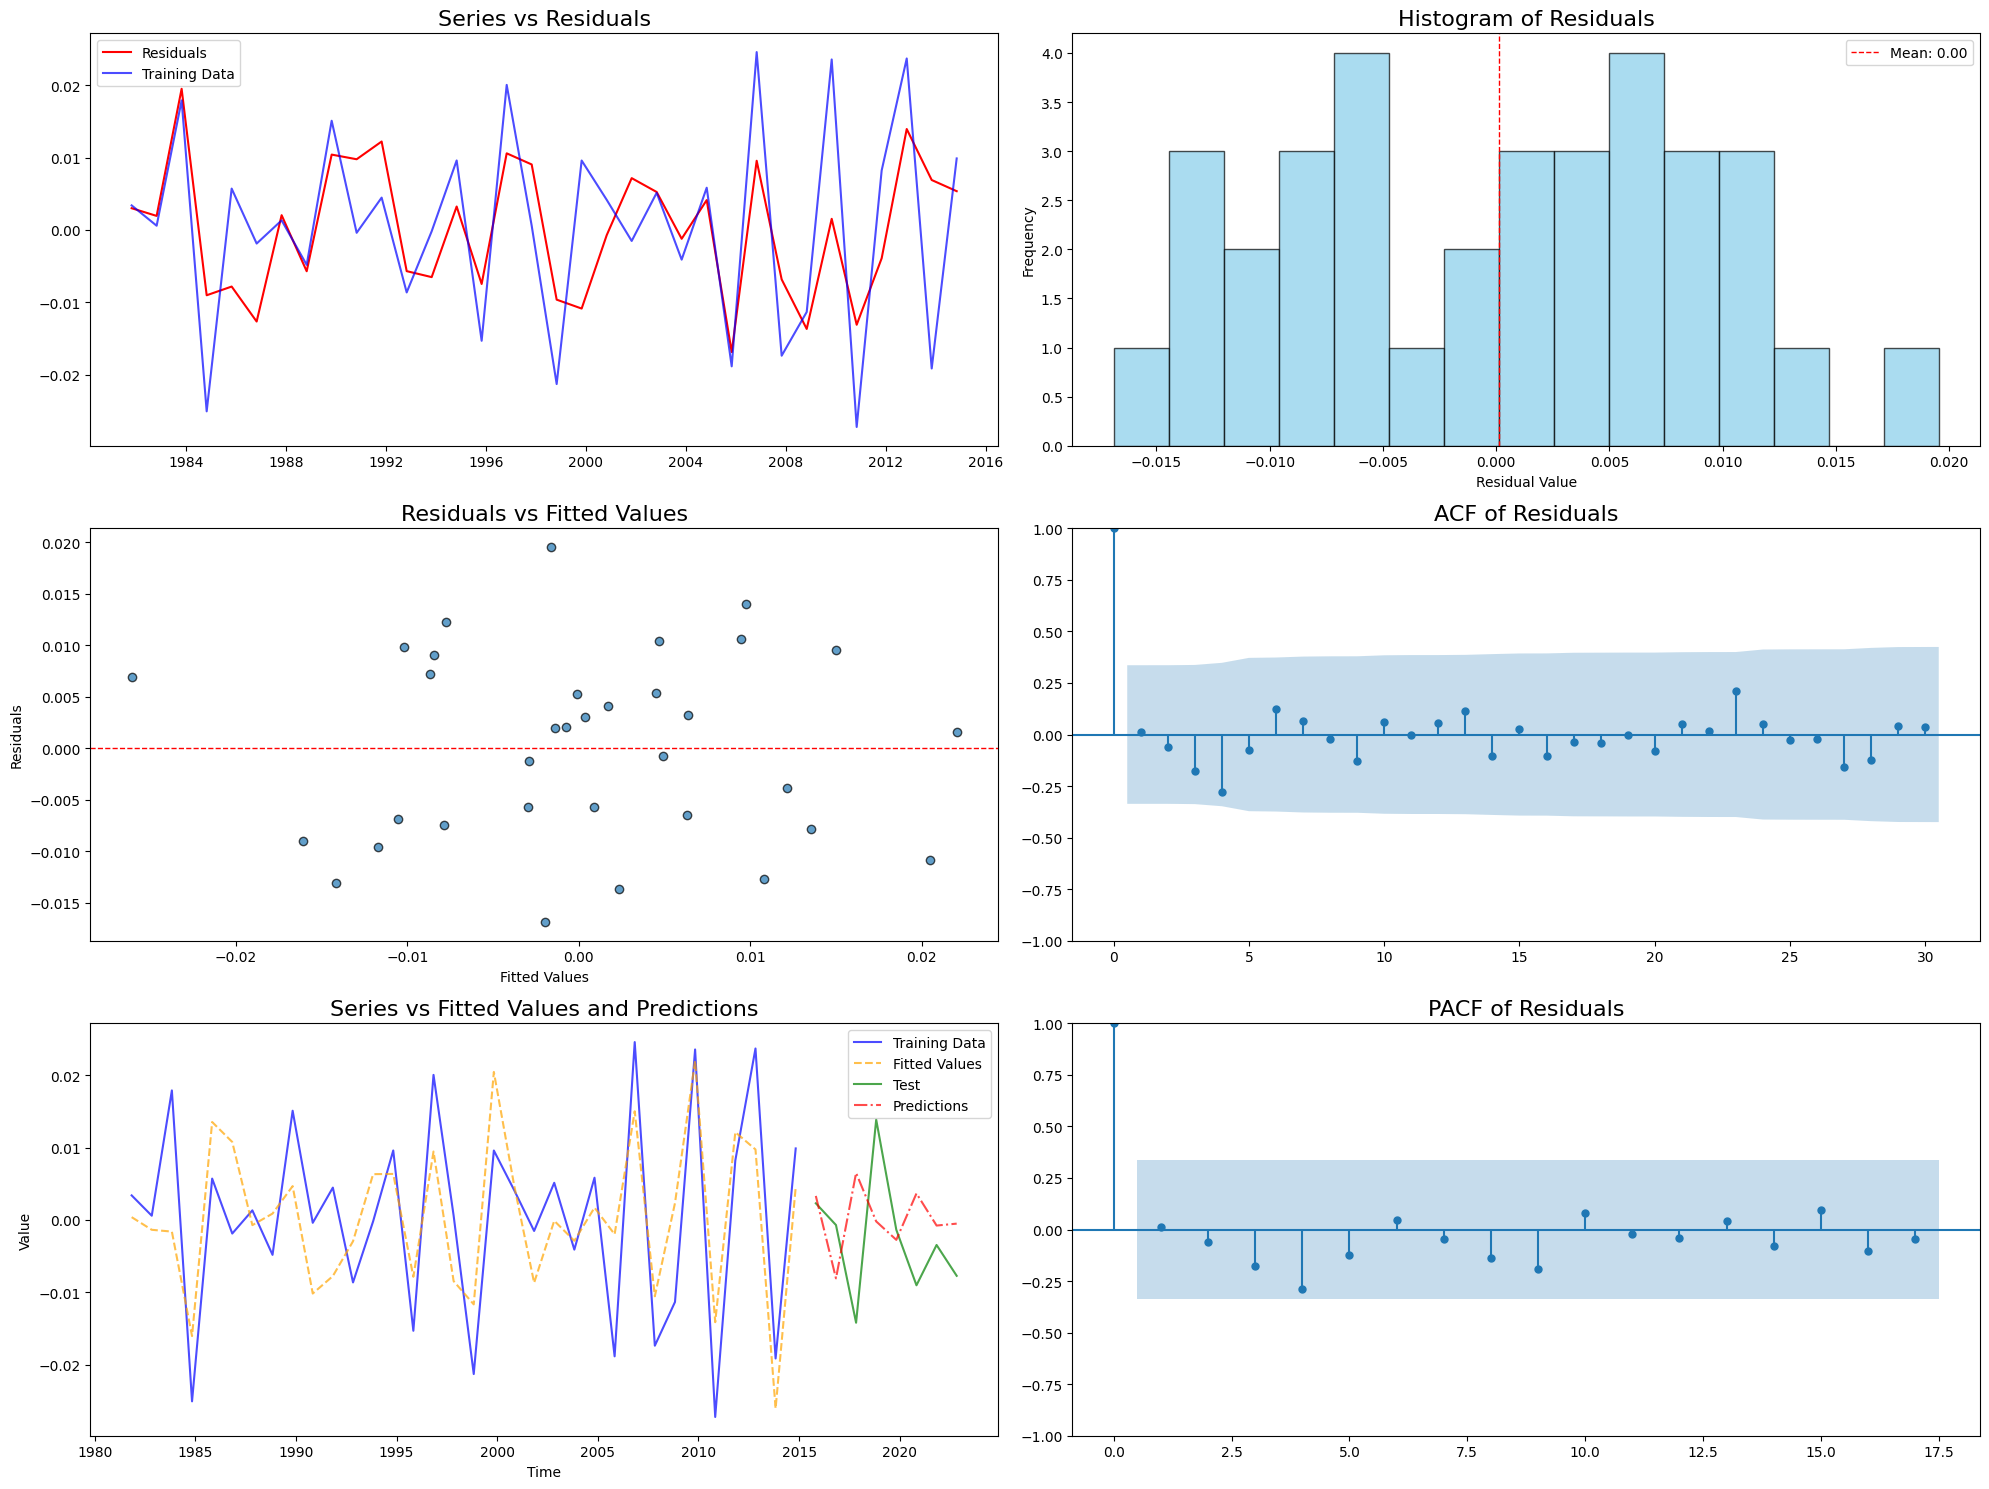

In [ ]:
plot_model_diagnostics(residuals_p200,
                       fitted_values_p200,
                       training_data = train['Diff - BC - weighted_sum_precipitation'],
                       test_data = test['Diff - BC - weighted_sum_precipitation'],
                       predictions = predictions_p200
                       )

Métricas:

In [ ]:
print('Training metrics')
evaluar_metricas(train['Diff - BC - weighted_sum_precipitation'], fitted_values_p200)
print('----------------------')
print('Test metrics')
evaluar_metricas(test['Diff - BC - weighted_sum_precipitation'], predictions_p200)

Training metrics
MAE: 0.007872597943581278
RMSE: 0.009085701119058235
----------------------
Test metrics
MAE: 0.008402990517117466
RMSE: 0.010643819343908295


#  Modelo ARIMA-X

In [ ]:
X_train = train[['Diff - BC - weighted_sum_precipitation','weighted_avg_ratio_temp']]
y_train = train['Diff - Log - Rendimiento (Kg/Ha)']
X_test = test[['Diff - BC - weighted_sum_precipitation','weighted_avg_ratio_temp']]
Y_test = test['Diff - Log - Rendimiento (Kg/Ha)']

Se ajusta un ARIMAX manual

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_AX = SARIMAX(
    y_train,
    exog=X_train,
    order=(3, 0, 2),  # Usa el orden encontrado por auto_arima
    trend='c'
)
results_AX = model_AX.fit()
print(results_AX.summary())

                                      SARIMAX Results                                       
Dep. Variable:     Diff - Log - Rendimiento (Kg/Ha)   No. Observations:                   34
Model:                             SARIMAX(3, 0, 2)   Log Likelihood                  26.379
Date:                              Tue, 04 Mar 2025   AIC                            -34.758
Time:                                      19:25:44   BIC                            -21.021
Sample:                                  11-01-1981   HQIC                           -30.074
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
intercept                                 

In [ ]:
# Creamos dataset de predicciones de exogenas:

future_exog = pd.DataFrame({
    'Diff - BC - weighted_sum_precipitation': predictions_p200,  # Predicciones de precipitaciones
    'weighted_avg_ratio_temp': predictions_t  # Predicciones de temperatura
})

In [ ]:
# Valores ajustados en train
fitted_values_AX = results_AX.predict()
# Residuos
residuals_AX = train['Diff - Log - Rendimiento (Kg/Ha)'] - fitted_values_AX
# Predicciones test
predictions_AX = results_AX.forecast(steps= n_per, exog= future_exog)

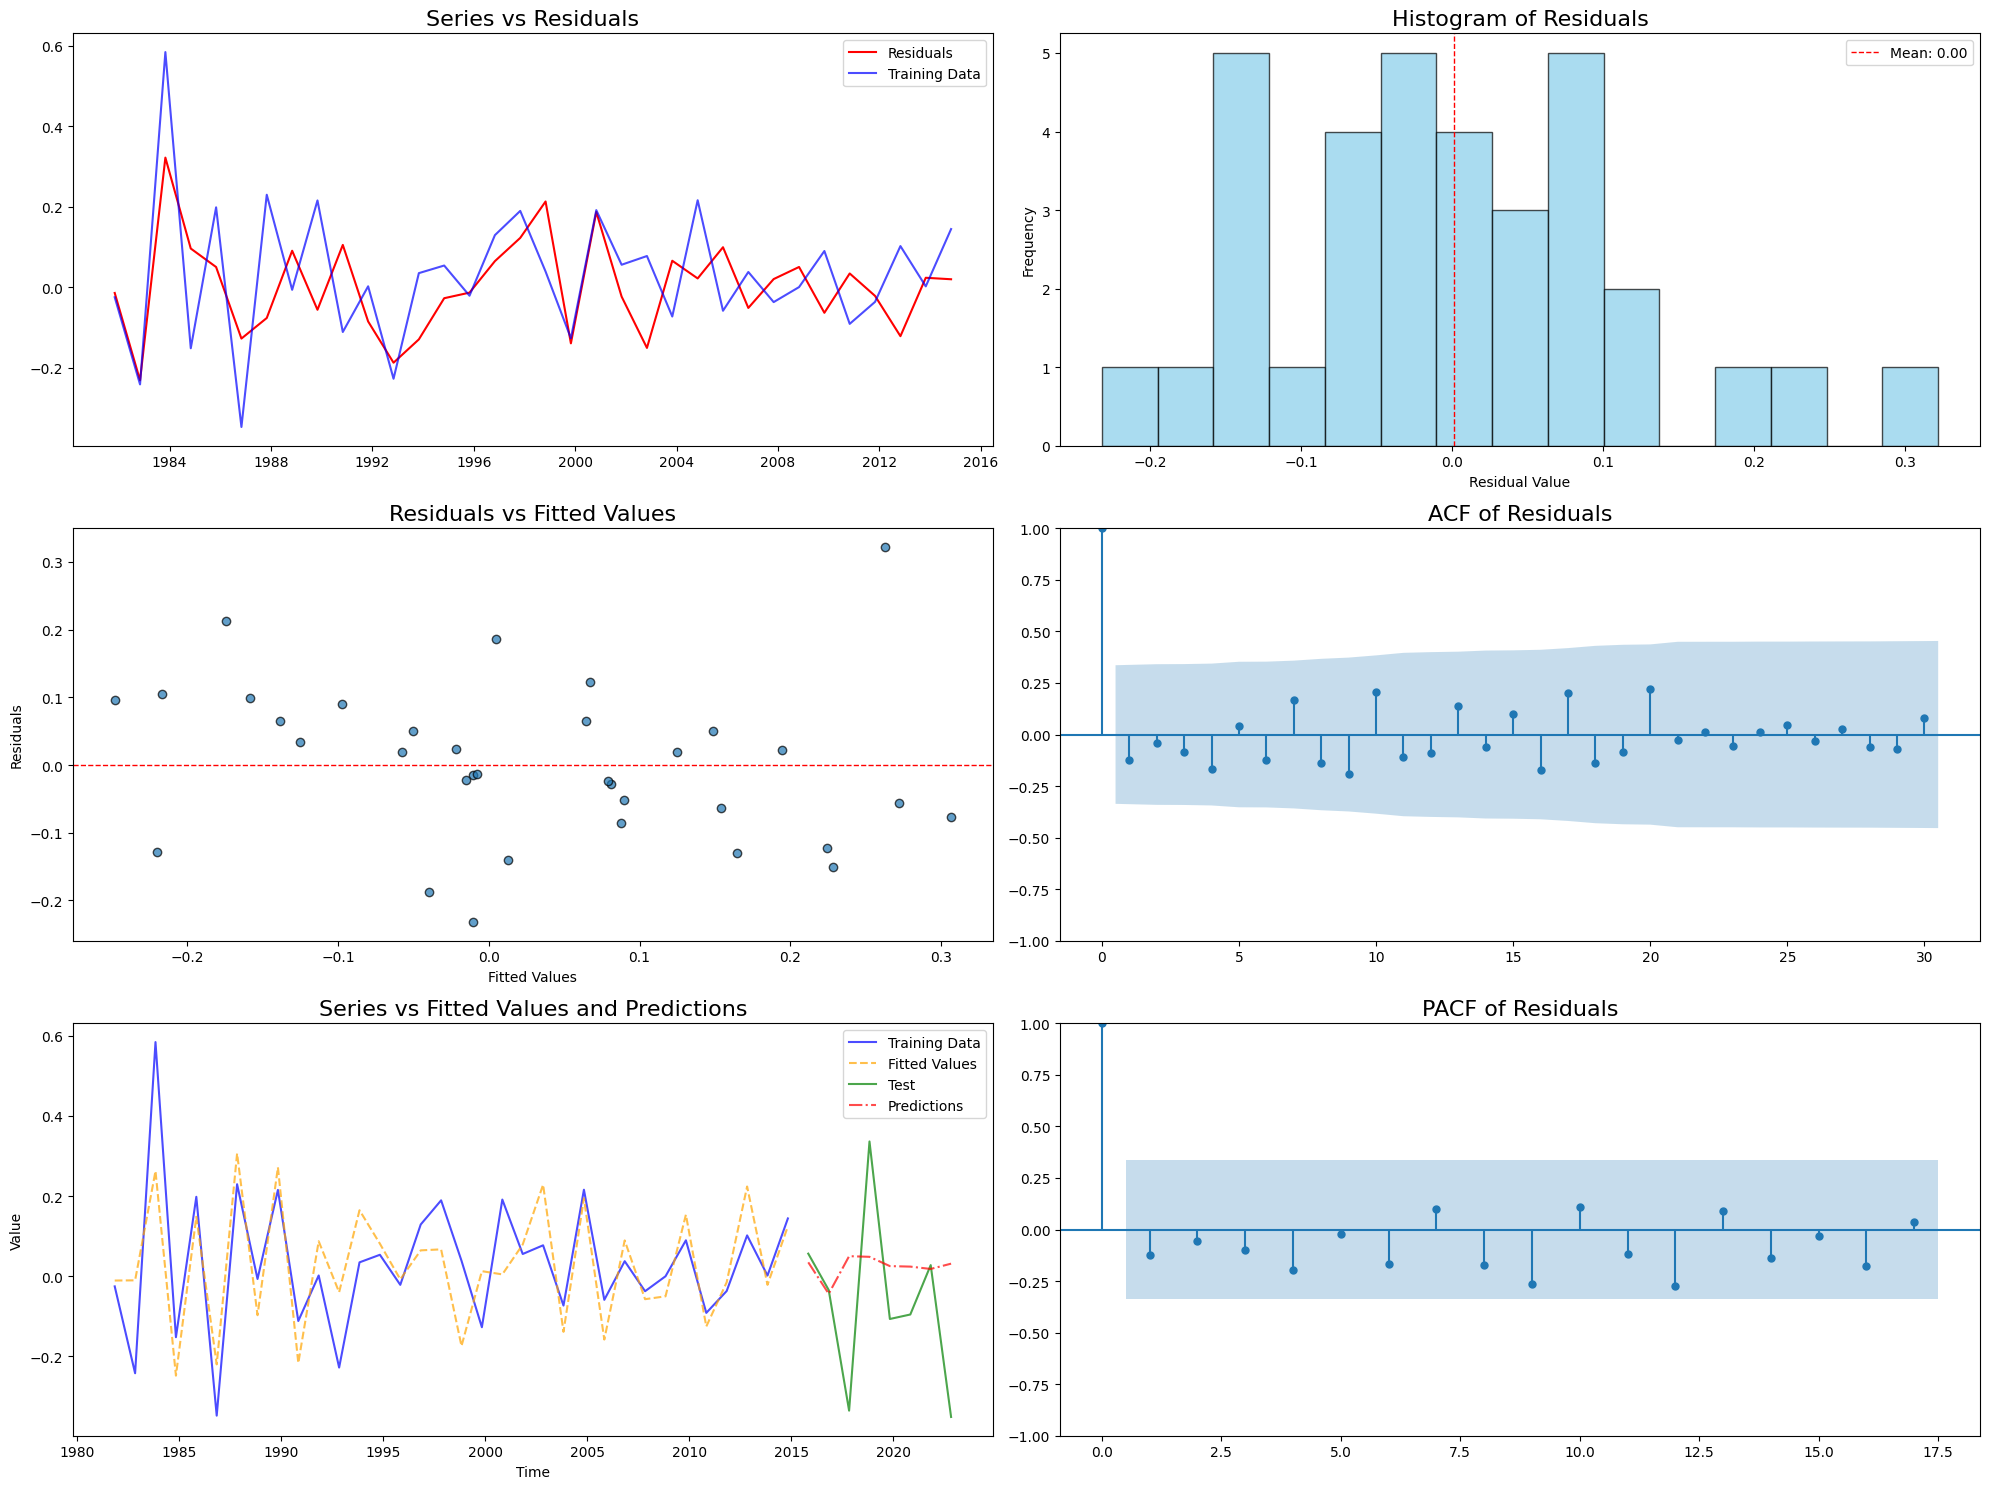

In [ ]:
plot_model_diagnostics(residuals_AX,
                       fitted_values_AX,
                       training_data = train['Diff - Log - Rendimiento (Kg/Ha)'],
                       test_data = test['Diff - Log - Rendimiento (Kg/Ha)'],
                       predictions = predictions_AX
                       )

In [ ]:
print('Training metrics')
evaluar_metricas(train['Diff - Log - Rendimiento (Kg/Ha)'], fitted_values_AX)
print('----------------------')
print('Test metrics')
evaluar_metricas(test['Diff - Log - Rendimiento (Kg/Ha)'], predictions_AX)

Training metrics
MAE: 0.09145027037610604
RMSE: 0.1161295629520756
----------------------
Test metrics
MAE: 0.16851060506194265
RMSE: 0.22645227847732888


Modelo horrible -

# Testeo de modelos con horizonte deslizante

Modelos elegidos:

* Serie de rendimientos: modelo elegido ARIMA(1,0,0) - modelo más simple y mejor
BIC.
* Serie proxy temperatura: modelo elegido ARIMA(0,0,0) - modelo de constante.
* Serie proxy precipitaciones: modelo elegido ARIMA(2,0,0) - BIC y AIC muy bajos, excelente resultados en diagnósticos de residuos.


Se testearan con crossvalidation (horizonte deslizante de **1 periodo** los modelos para rendimientos y precipitaciones)

In [ ]:
series

Campana  Rendimiento (Kg/Ha)  weighted_avg_ratio_temp  \
start_year                                                          
1981-11-01  1981/82               102655                 1.992710   
1982-11-01  1982/83                80589                 2.000268   
1983-11-01  1983/84               144574                 2.335314   
1984-11-01  1984/85               124175                 2.077524   
1985-11-01  1985/86               151411                 2.331170   
1986-11-01  1986/87               106929                 2.326147   
1987-11-01  1987/88               134539                 2.220702   
1988-11-01  1988/89               133633                 2.004516   
1989-11-01  1989/90               165772                 2.220724   
1990-11-01  1990/91               148262                 2.093964   
1991-11-01  1991/92               148554                 2.158439   
1992-11-01  1992/93               118283                 2.059319   
1993-11-01  1993/94               122464                 2.145750   
1994-11-01  1994/95               129211                 2.166265   
1995-11-01  1995/96               126472                 1.949376   
1996-11-01  1996/97               143917                 2.273238   
1997-11-01  1997/98               173944                 2.299184   
1998-11-01  1998/99               180820                 1.999890   
1999-11-01  1999/00               159223                 2.171076   
2000-11-01  2000/01               192816                 2.087586   
2001-11-01  2001/02               203838                 2.624717   
2002-11-01  2002/03               220213                 2.318990   
2003-11-01  2003/04               204682                 2.043635   
2004-11-01  2004/05               254035                 2.305558   
2005-11-01  2005/06               239518                 1.920202   
2006-11-01  2006/07               248703                 2.156778   
2007-11-01  2007/08               239598                 2.267346   
2008-11-01  2008/09               239598                 1.969566   
2009-11-01  2009/10               262097                 2.188650   
2010-11-01  2010/11               239201                 2.021347   
2011-11-01  2011/12               230563                 2.077035   
2012-11-01  2012/13               255319                 2.341945   
2013-11-01  2013/14               255779                 2.202685   
2014-11-01  2014/15               295488                 2.256936   
2015-11-01  2015/16               312645                 2.142924   
2016-11-01  2016/17               302074                 2.293831   
2017-11-01  2017/18               216012                 2.080571   
2018-11-01  2018/19               302407                 2.132617   
2019-11-01  2019/20               271828                 2.086239   
2020-11-01  2020/21               247090                 2.023426   
2021-11-01  2021/22               254066                 2.149026   
2022-11-01  2022/23               178831                 1.948182   

            weighted_sum_precipitation  Log - Rendimiento (Kg/Ha)  \
start_year                                                          
1981-11-01                     1119.85                  11.539129   
1982-11-01                     1139.26                  11.297117   
1983-11-01                     2086.67                  11.881547   
1984-11-01                      932.65                  11.729447   
1985-11-01                     1092.63                  11.927753   
1986-11-01                     1036.01                  11.579920   
1987-11-01                     1075.70                  11.809609   
1988-11-01                      941.53                  11.802853   
1989-11-01                     1475.53                  12.018369   
1990-11-01                     1456.60                  11.906736   
1991-11-01                     1697.68                  11.908704   
1992-11-01                     1275.37                  11.680835   
1993-11-0

In [ ]:
# Definir los años de corte para train y test
train_test_splits = [
    #(2010, 2011),  # Train hasta 2010, Test en 2011
    #(2011, 2012),  # Train hasta 2011, Test en 2012
    #(2012, 2013),  # Train hasta 2012, Test en 2013
    #(2013, 2014),  # Train hasta 2013, Test en 2014
    (2014, 2015),  # Train hasta 2014, Test en 2015
    (2015, 2016),  # Train hasta 2015, Test en 2016
    (2016, 2017),  # Train hasta 2016, Test en 2017
    (2017, 2018),  # Train hasta 2017, Test en 2018
    (2018, 2019),  # Train hasta 2018, Test en 2019
    (2019, 2020),  # Train hasta 2019, Test en 2020
    (2020, 2021),  # Train hasta 2020, Test en 2021
    (2021, 2022)   # Train hasta 2021, Test en 2022
]

train_test_sets = []
for train_end_year, test_year in train_test_splits:
    # Train: Todos los datos hasta el año train_end_year
    train = series[series.index.year <= train_end_year]

    # Test: Todos los datos del año test_year
    test = series[series.index.year == test_year]

    # Guardar los conjuntos en una lista
    train_test_sets.append((train, test))

In [ ]:
# Verificar los conjuntos creados
for i, (train, test) in enumerate(train_test_sets):
    print(f"Conjunto {i+1}:")
    print(f"  Train: {train.index.min().year} - {train.index.max().year} (n={len(train)})")
    print(f"  Test: {test.index.min().year} - {test.index.max().year} (n={len(test)})")
    print()

Conjunto 1:
  Train: 1981 - 2014 (n=34)
  Test: 2015 - 2015 (n=1)

Conjunto 2:
  Train: 1981 - 2015 (n=35)
  Test: 2016 - 2016 (n=1)

Conjunto 3:
  Train: 1981 - 2016 (n=36)
  Test: 2017 - 2017 (n=1)

Conjunto 4:
  Train: 1981 - 2017 (n=37)
  Test: 2018 - 2018 (n=1)

Conjunto 5:
  Train: 1981 - 2018 (n=38)
  Test: 2019 - 2019 (n=1)

Conjunto 6:
  Train: 1981 - 2019 (n=39)
  Test: 2020 - 2020 (n=1)

Conjunto 7:
  Train: 1981 - 2020 (n=40)
  Test: 2021 - 2021 (n=1)

Conjunto 8:
  Train: 1981 - 2021 (n=41)
  Test: 2022 - 2022 (n=1)



In [ ]:
# Función para evaluar métricas test
def evaluar_metricas(serie_test, serie_pred):
    mae = mean_absolute_error(serie_test, serie_pred)
    mse = mean_squared_error(serie_test, serie_pred)
    rmse = np.sqrt(mse)
    return {
        'MAE': mae,
        'RMSE': rmse
    }


## Rendimientos


Conjunto 1:
  Train: 1981 - 2014 (n=34)
  Test: 2015 - 2015 (n=1)


============================== Model Summary ==============================
                                      SARIMAX Results                                       
Dep. Variable:     Diff - Log - Rendimiento (Kg/Ha)   No. Observations:                   34
Model:                               ARIMA(1, 0, 0)   Log Likelihood                  16.580
Date:                              Tue, 04 Mar 2025   AIC                            -29.160
Time:                                      19:25:46   BIC                            -26.108
Sample:                                  11-01-1981   HQIC                           -28.119
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

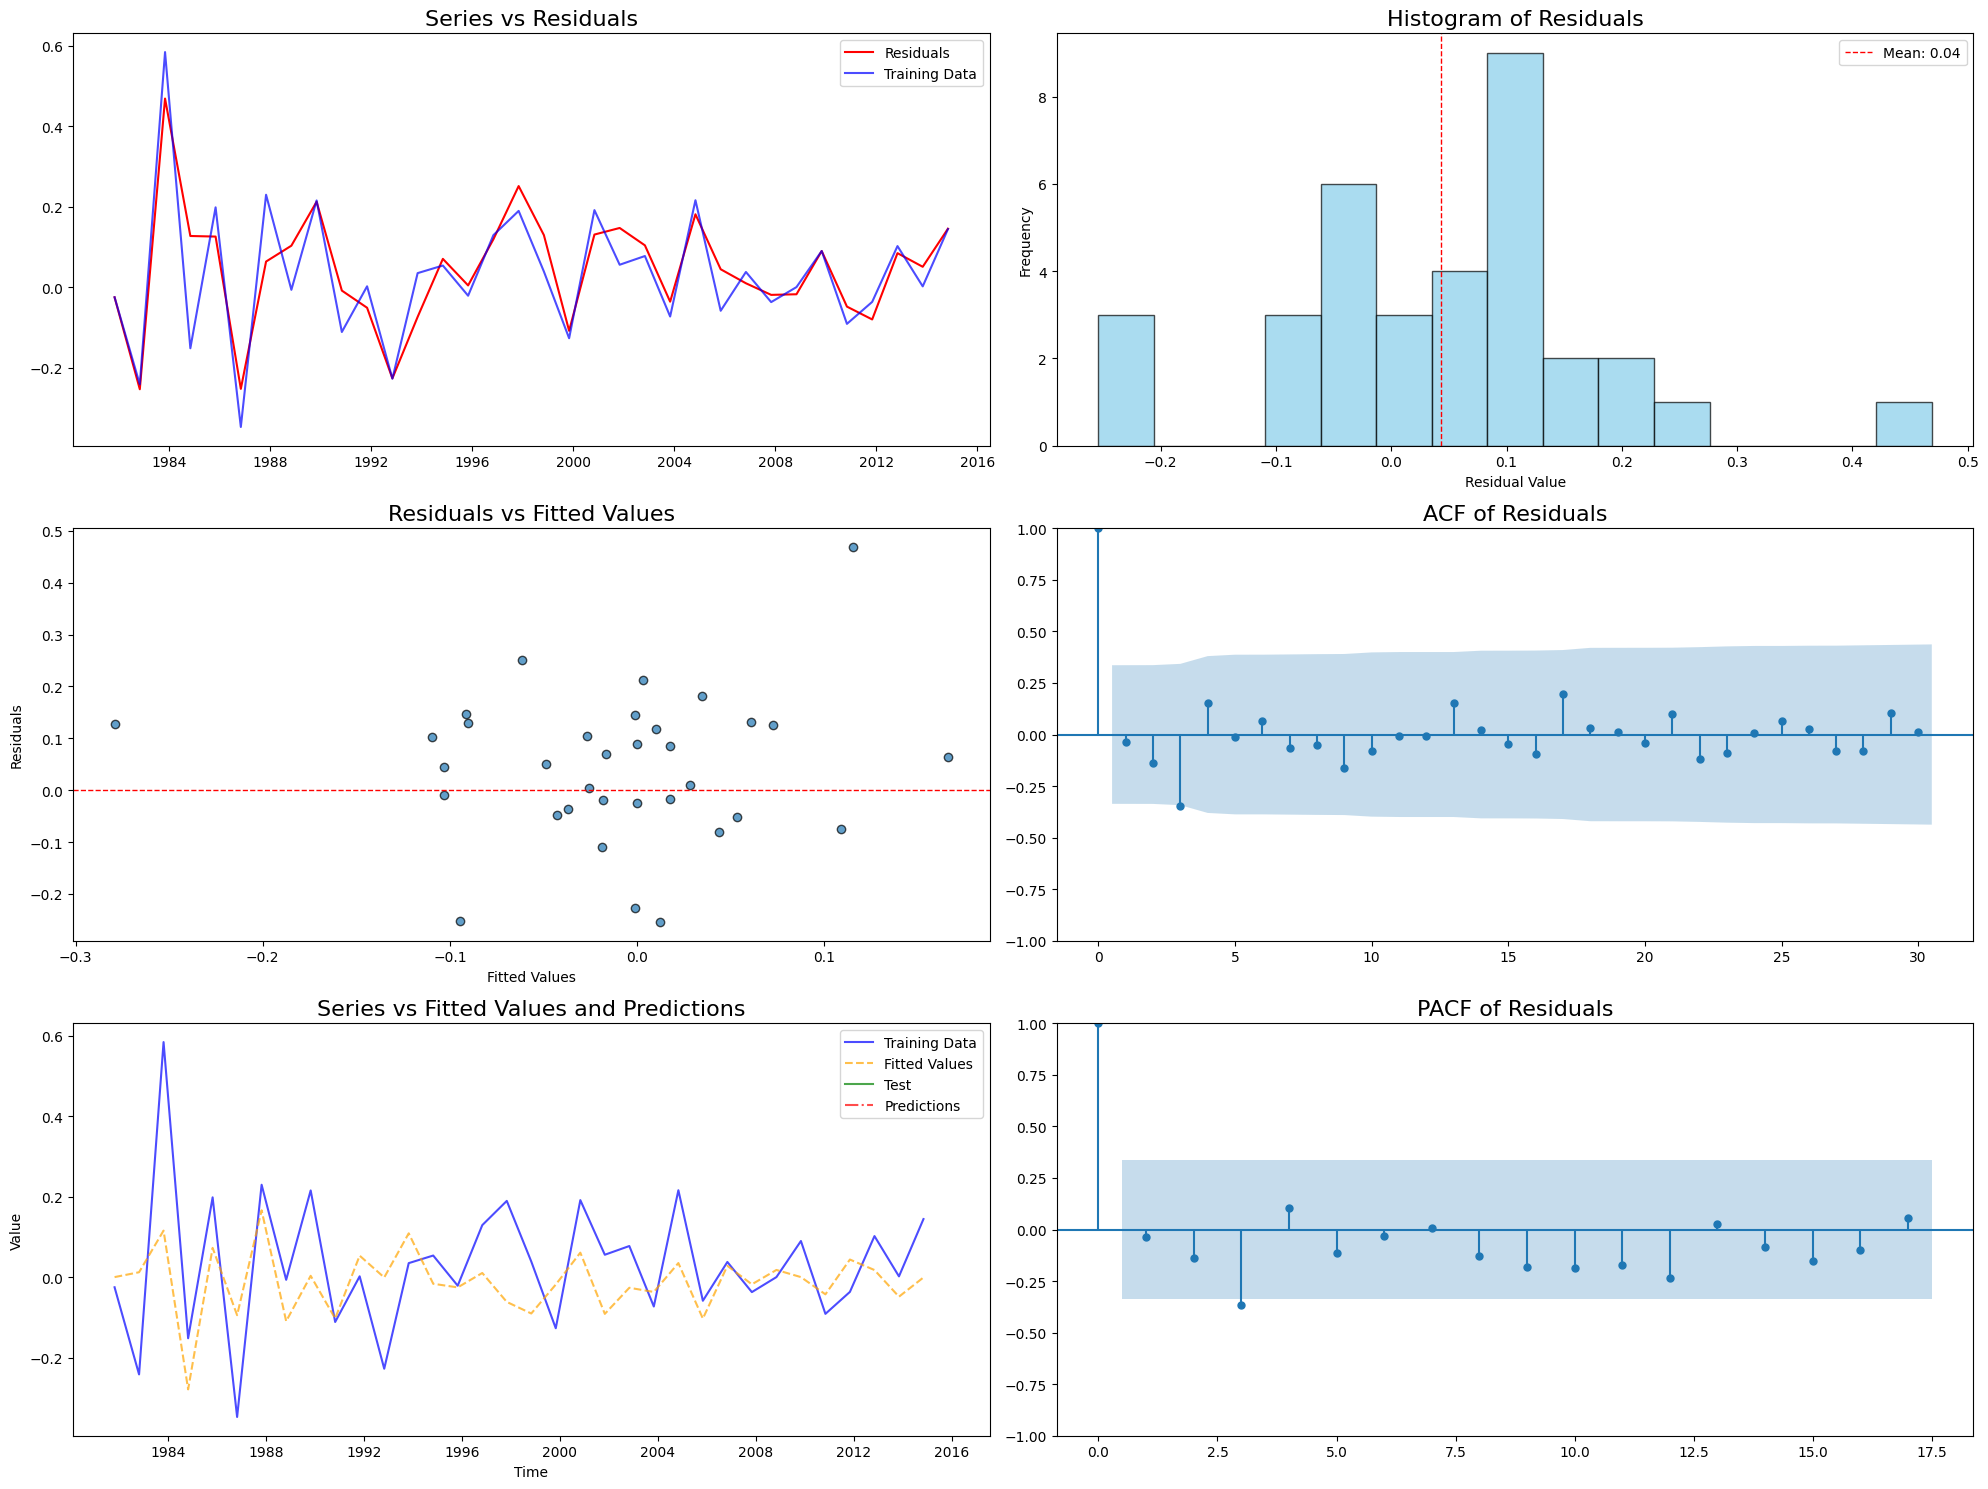

Métricas para conjunto 1:
  MAE: 0.1254
  RMSE: 0.1254
  y_test: 0.0564
  y_pred: -0.0689



Conjunto 2:
  Train: 1981 - 2015 (n=35)
  Test: 2016 - 2016 (n=1)


============================== Model Summary ==============================
                                      SARIMAX Results                                       
Dep. Variable:     Diff - Log - Rendimiento (Kg/Ha)   No. Observations:                   35
Model:                               ARIMA(1, 0, 0)   Log Likelihood                  17.221
Date:                              Tue, 04 Mar 2025   AIC                            -30.441
Time:                                      19:25:48   BIC                            -27.331
Sample:                                  11-01-1981   HQIC                           -29.368
                                       - 11-01-2015                                         
Covariance Type:                                opg                                         
                 co

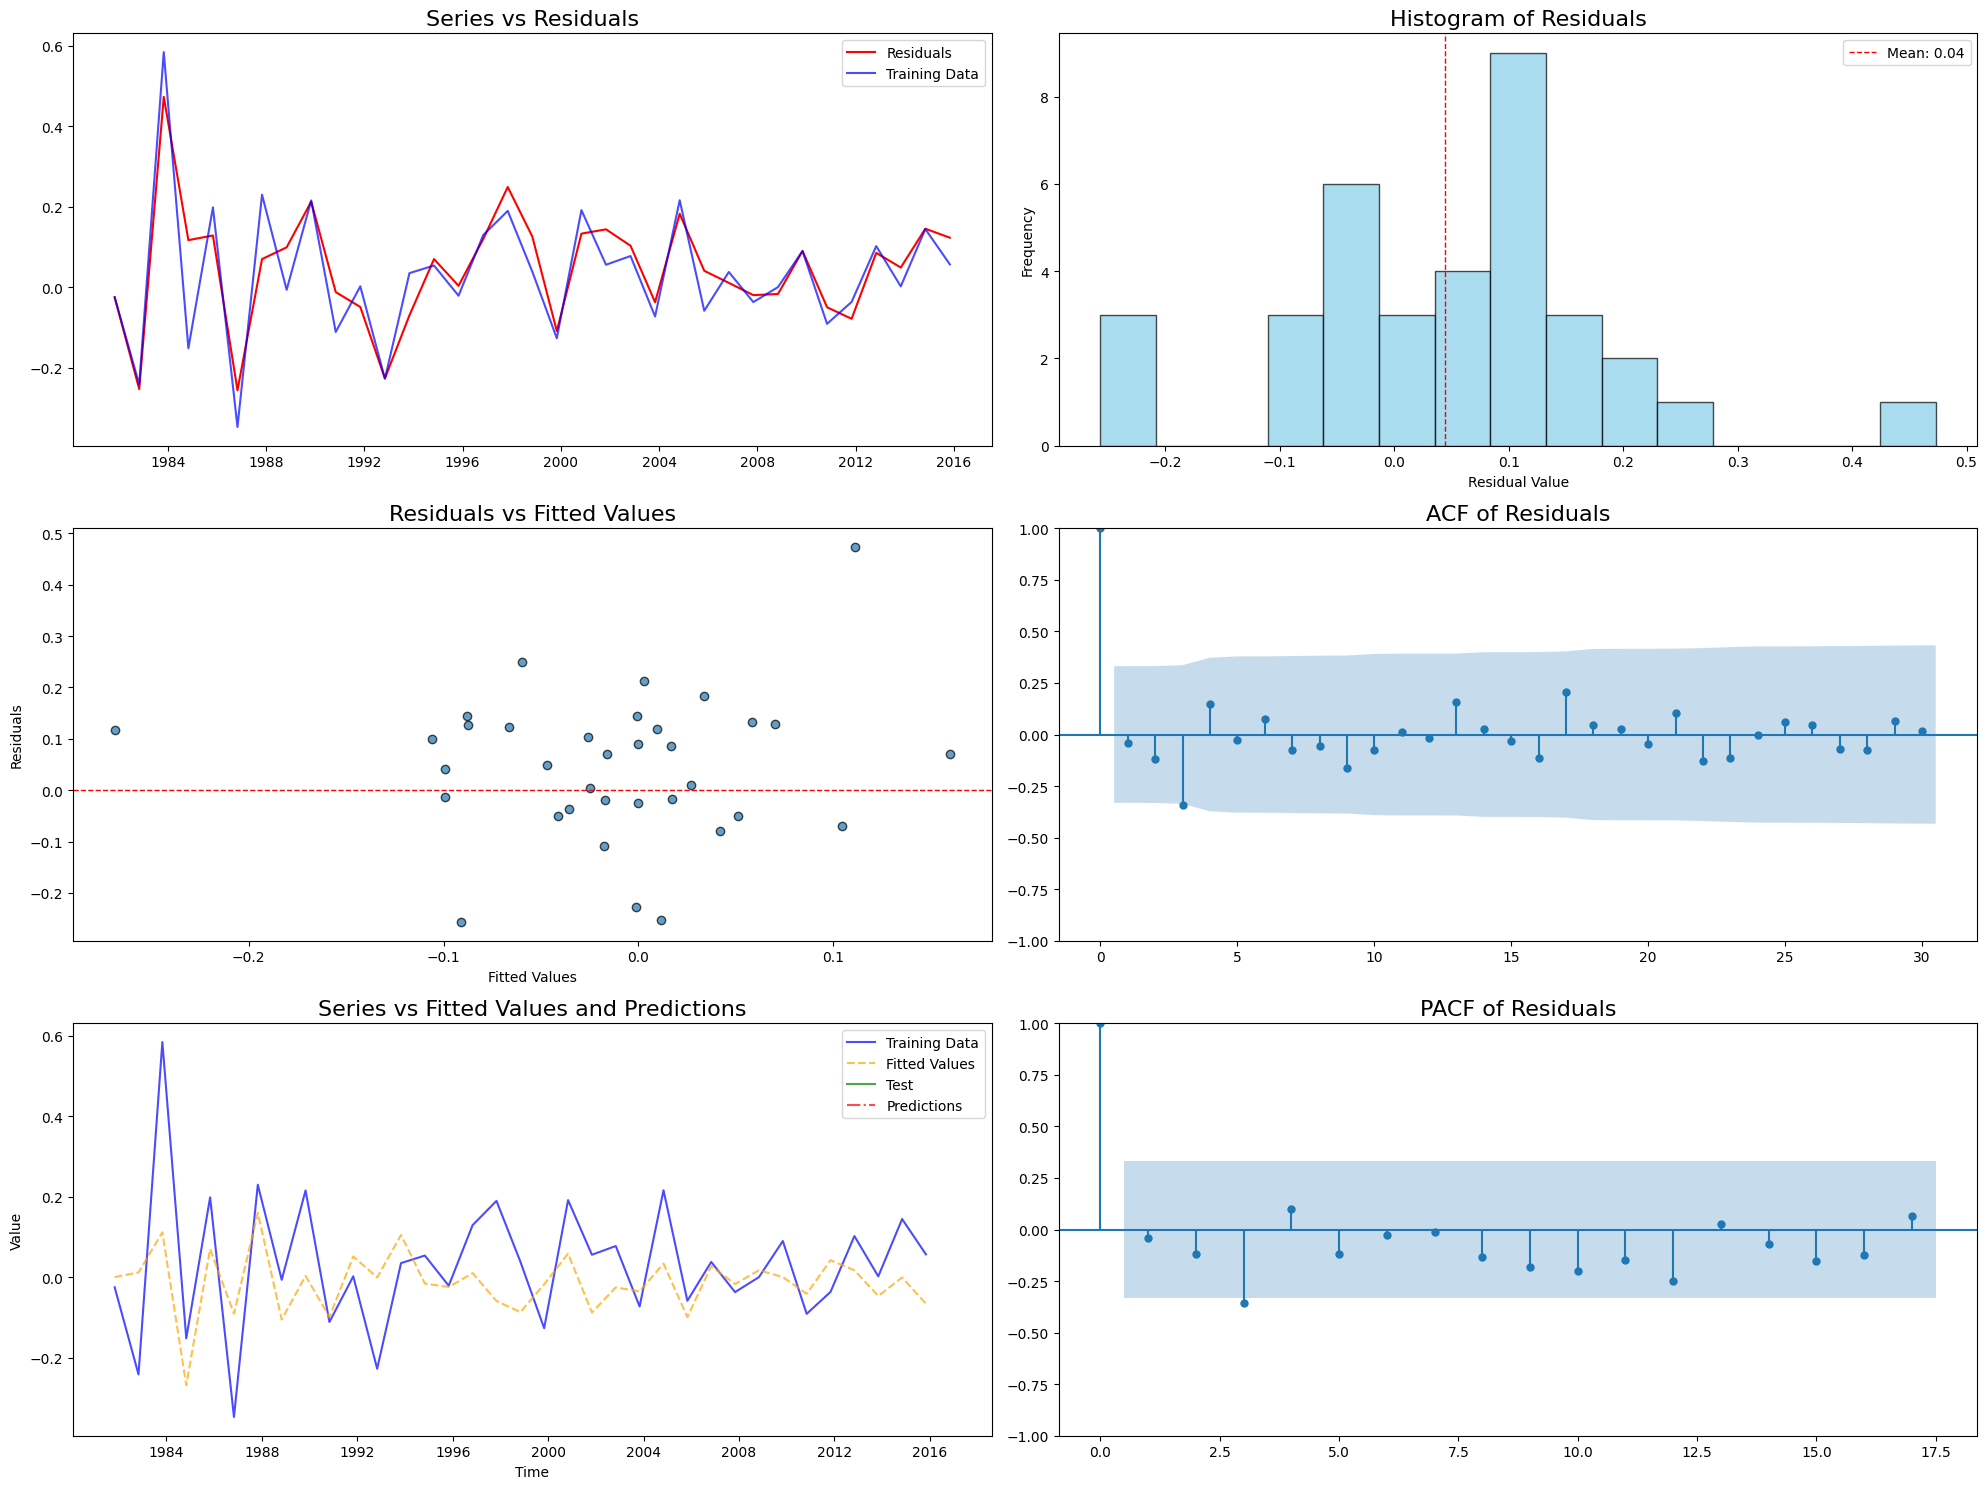

Métricas para conjunto 2:
  MAE: 0.0084
  RMSE: 0.0084
  y_test: -0.0344
  y_pred: -0.0260



Conjunto 3:
  Train: 1981 - 2016 (n=36)
  Test: 2017 - 2017 (n=1)


============================== Model Summary ==============================
                                      SARIMAX Results                                       
Dep. Variable:     Diff - Log - Rendimiento (Kg/Ha)   No. Observations:                   36
Model:                               ARIMA(1, 0, 0)   Log Likelihood                  18.222
Date:                              Tue, 04 Mar 2025   AIC                            -32.443
Time:                                      19:25:49   BIC                            -29.276
Sample:                                  11-01-1981   HQIC                           -31.338
                                       - 11-01-2016                                         
Covariance Type:                                opg                                         
                 c

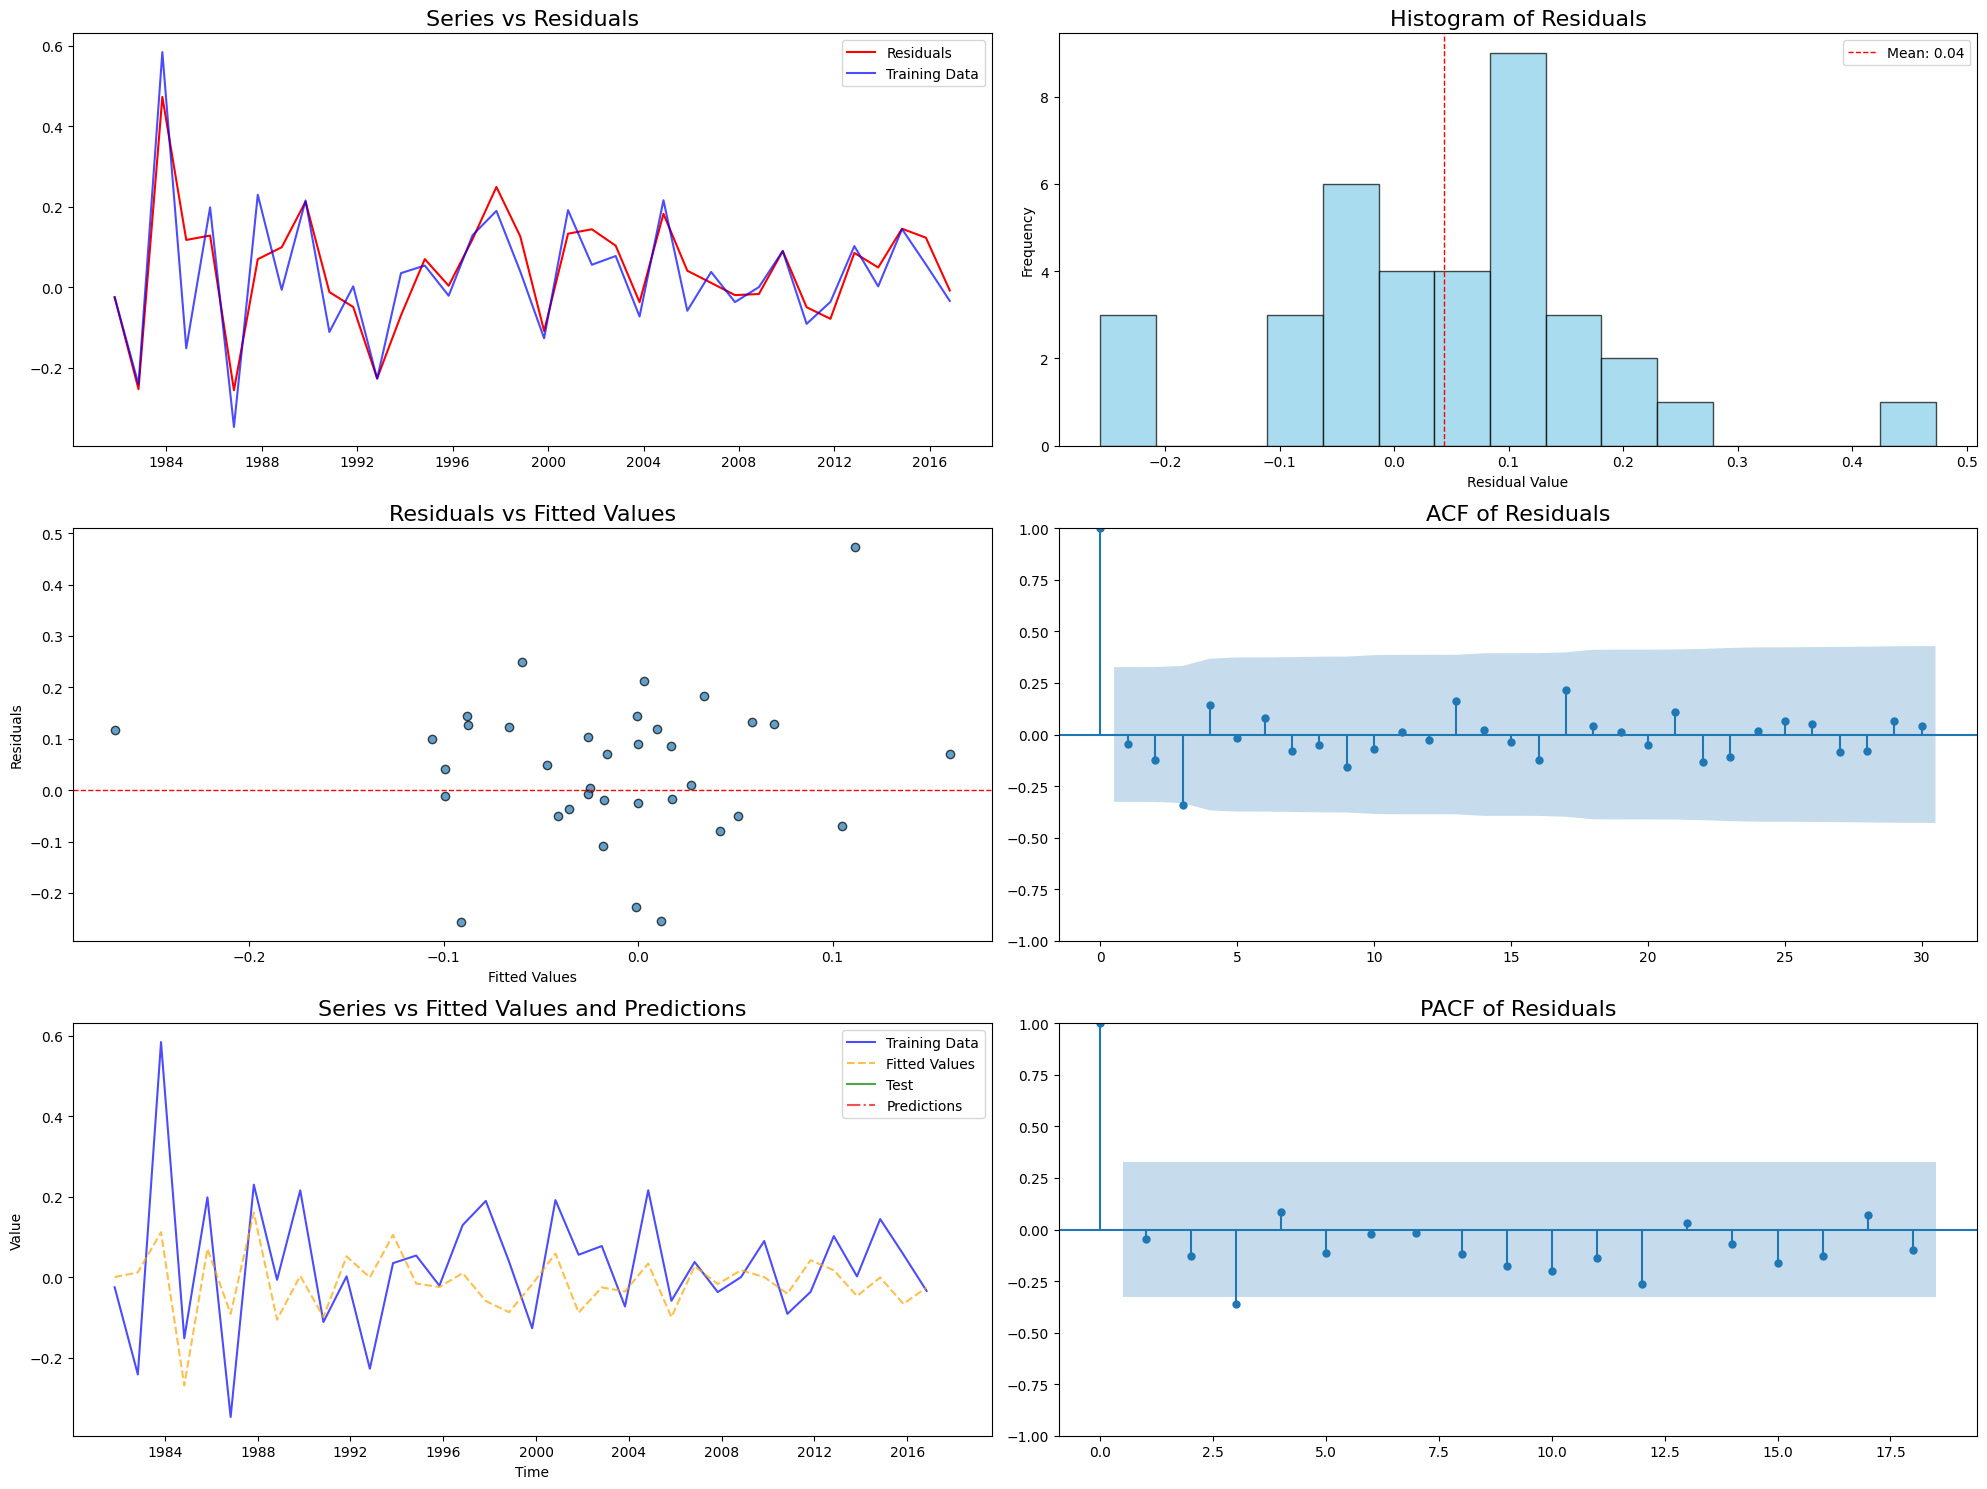

Métricas para conjunto 3:
  MAE: 0.3512
  RMSE: 0.3512
  y_test: -0.3353
  y_pred: 0.0159



Conjunto 4:
  Train: 1981 - 2017 (n=37)
  Test: 2018 - 2018 (n=1)


============================== Model Summary ==============================
                                      SARIMAX Results                                       
Dep. Variable:     Diff - Log - Rendimiento (Kg/Ha)   No. Observations:                   37
Model:                               ARIMA(1, 0, 0)   Log Likelihood                  16.463
Date:                              Tue, 04 Mar 2025   AIC                            -28.925
Time:                                      19:25:50   BIC                            -25.703
Sample:                                  11-01-1981   HQIC                           -27.789
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
                 co

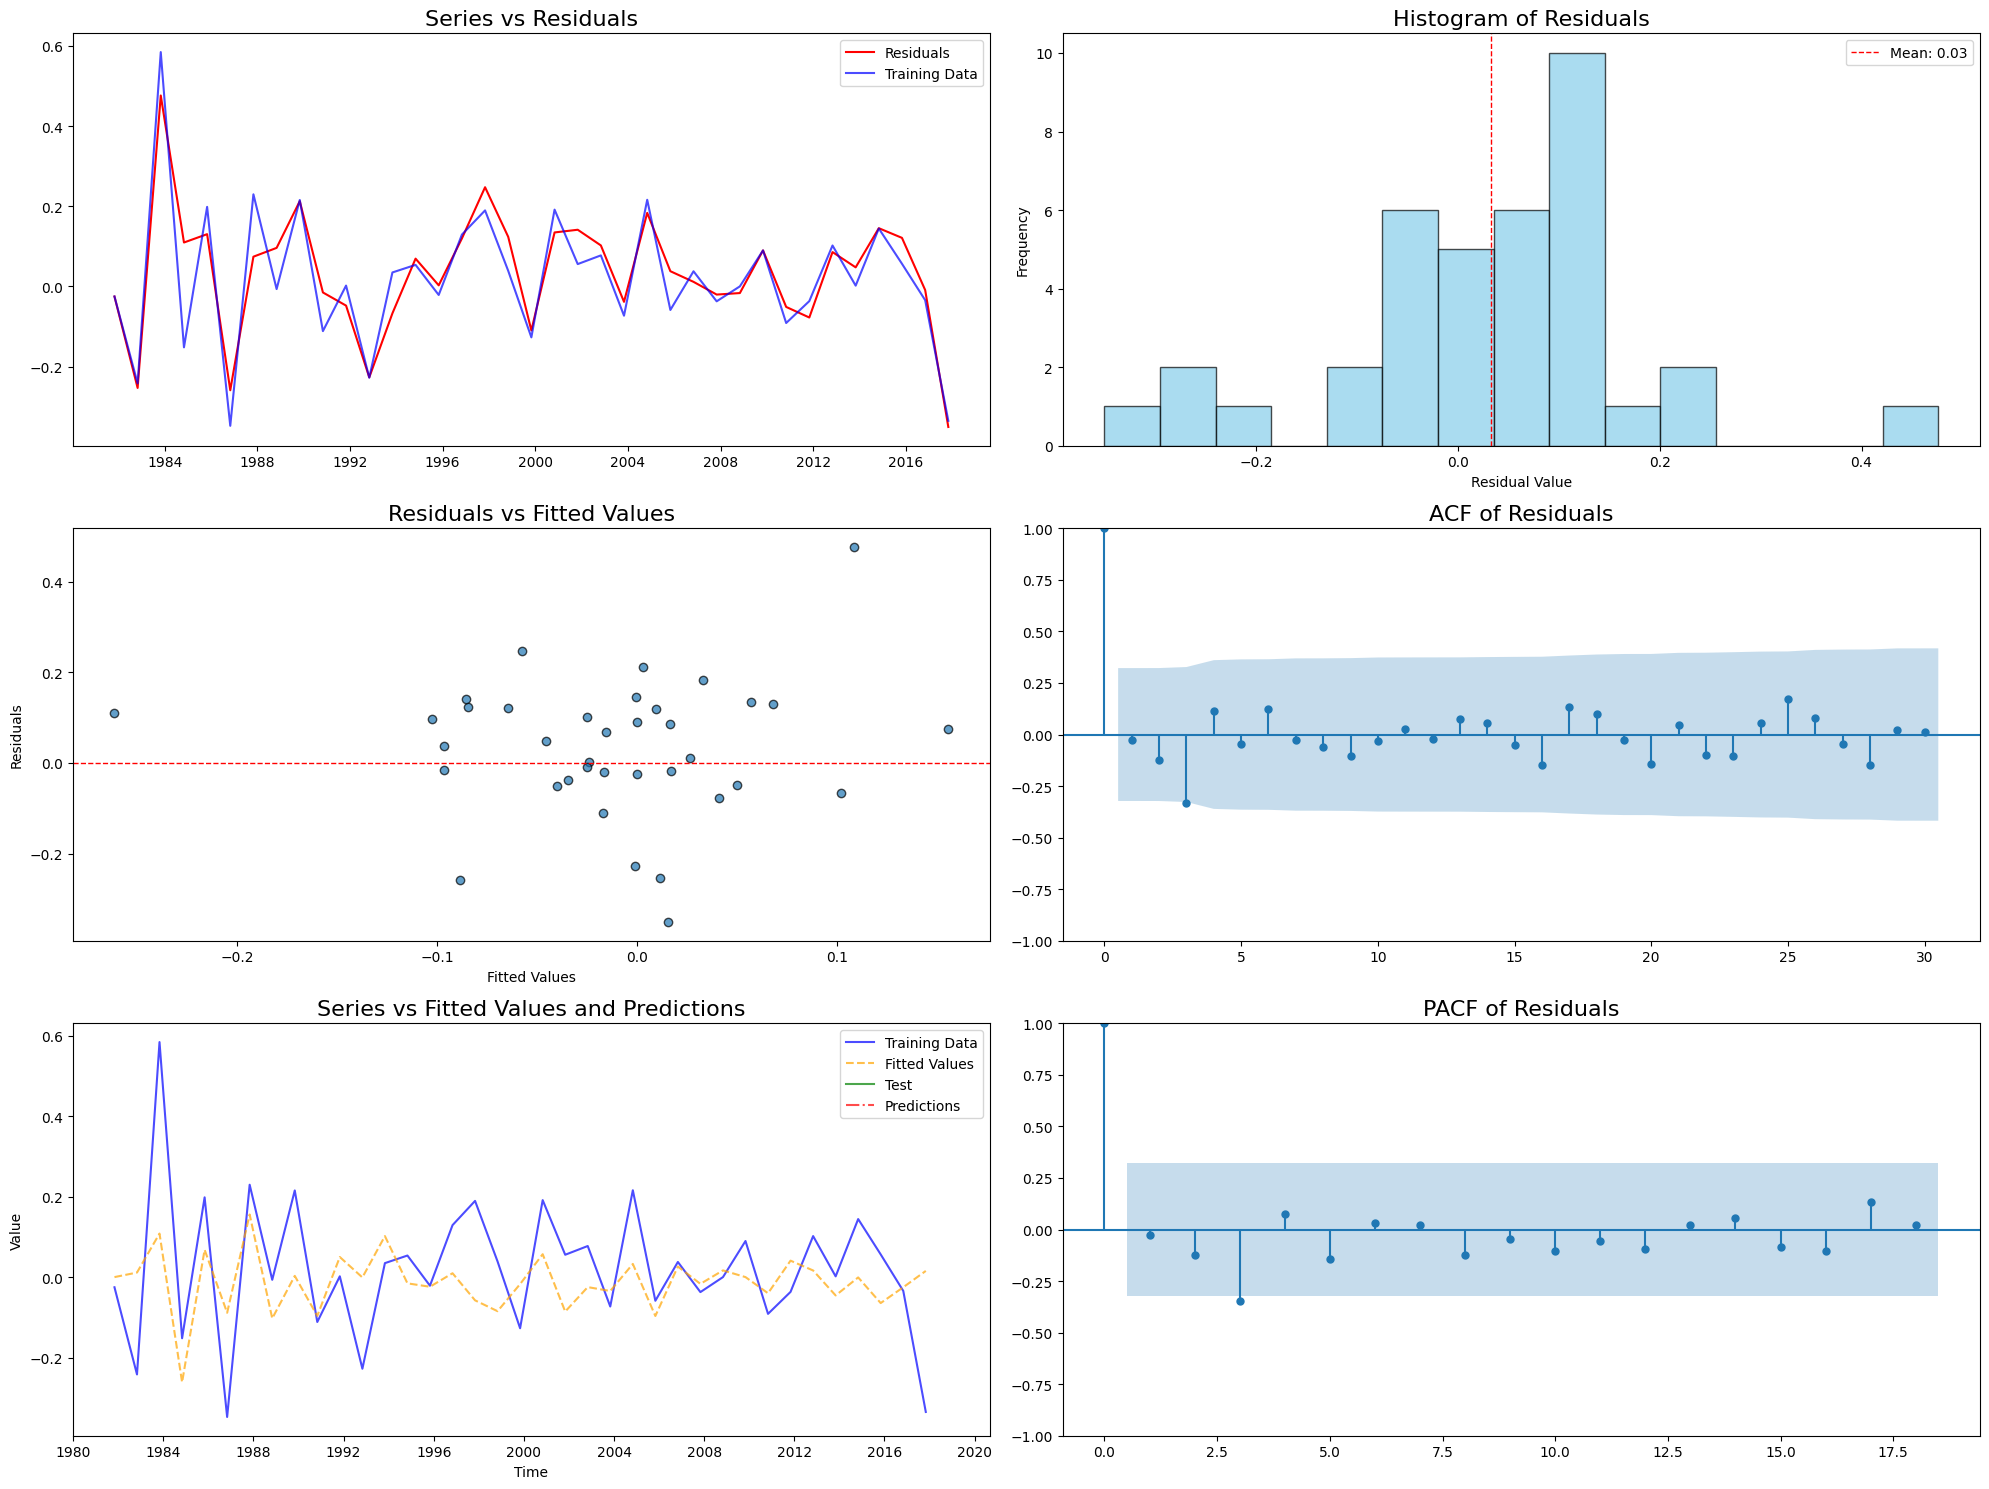

Métricas para conjunto 4:
  MAE: 0.1864
  RMSE: 0.1864
  y_test: 0.3364
  y_pred: 0.1501



Conjunto 5:
  Train: 1981 - 2018 (n=38)
  Test: 2019 - 2019 (n=1)


============================== Model Summary ==============================
                                      SARIMAX Results                                       
Dep. Variable:     Diff - Log - Rendimiento (Kg/Ha)   No. Observations:                   38
Model:                               ARIMA(1, 0, 0)   Log Likelihood                  16.756
Date:                              Tue, 04 Mar 2025   AIC                            -29.512
Time:                                      19:25:52   BIC                            -26.237
Sample:                                  11-01-1981   HQIC                           -28.347
                                       - 11-01-2018                                         
Covariance Type:                                opg                                         
                 coe

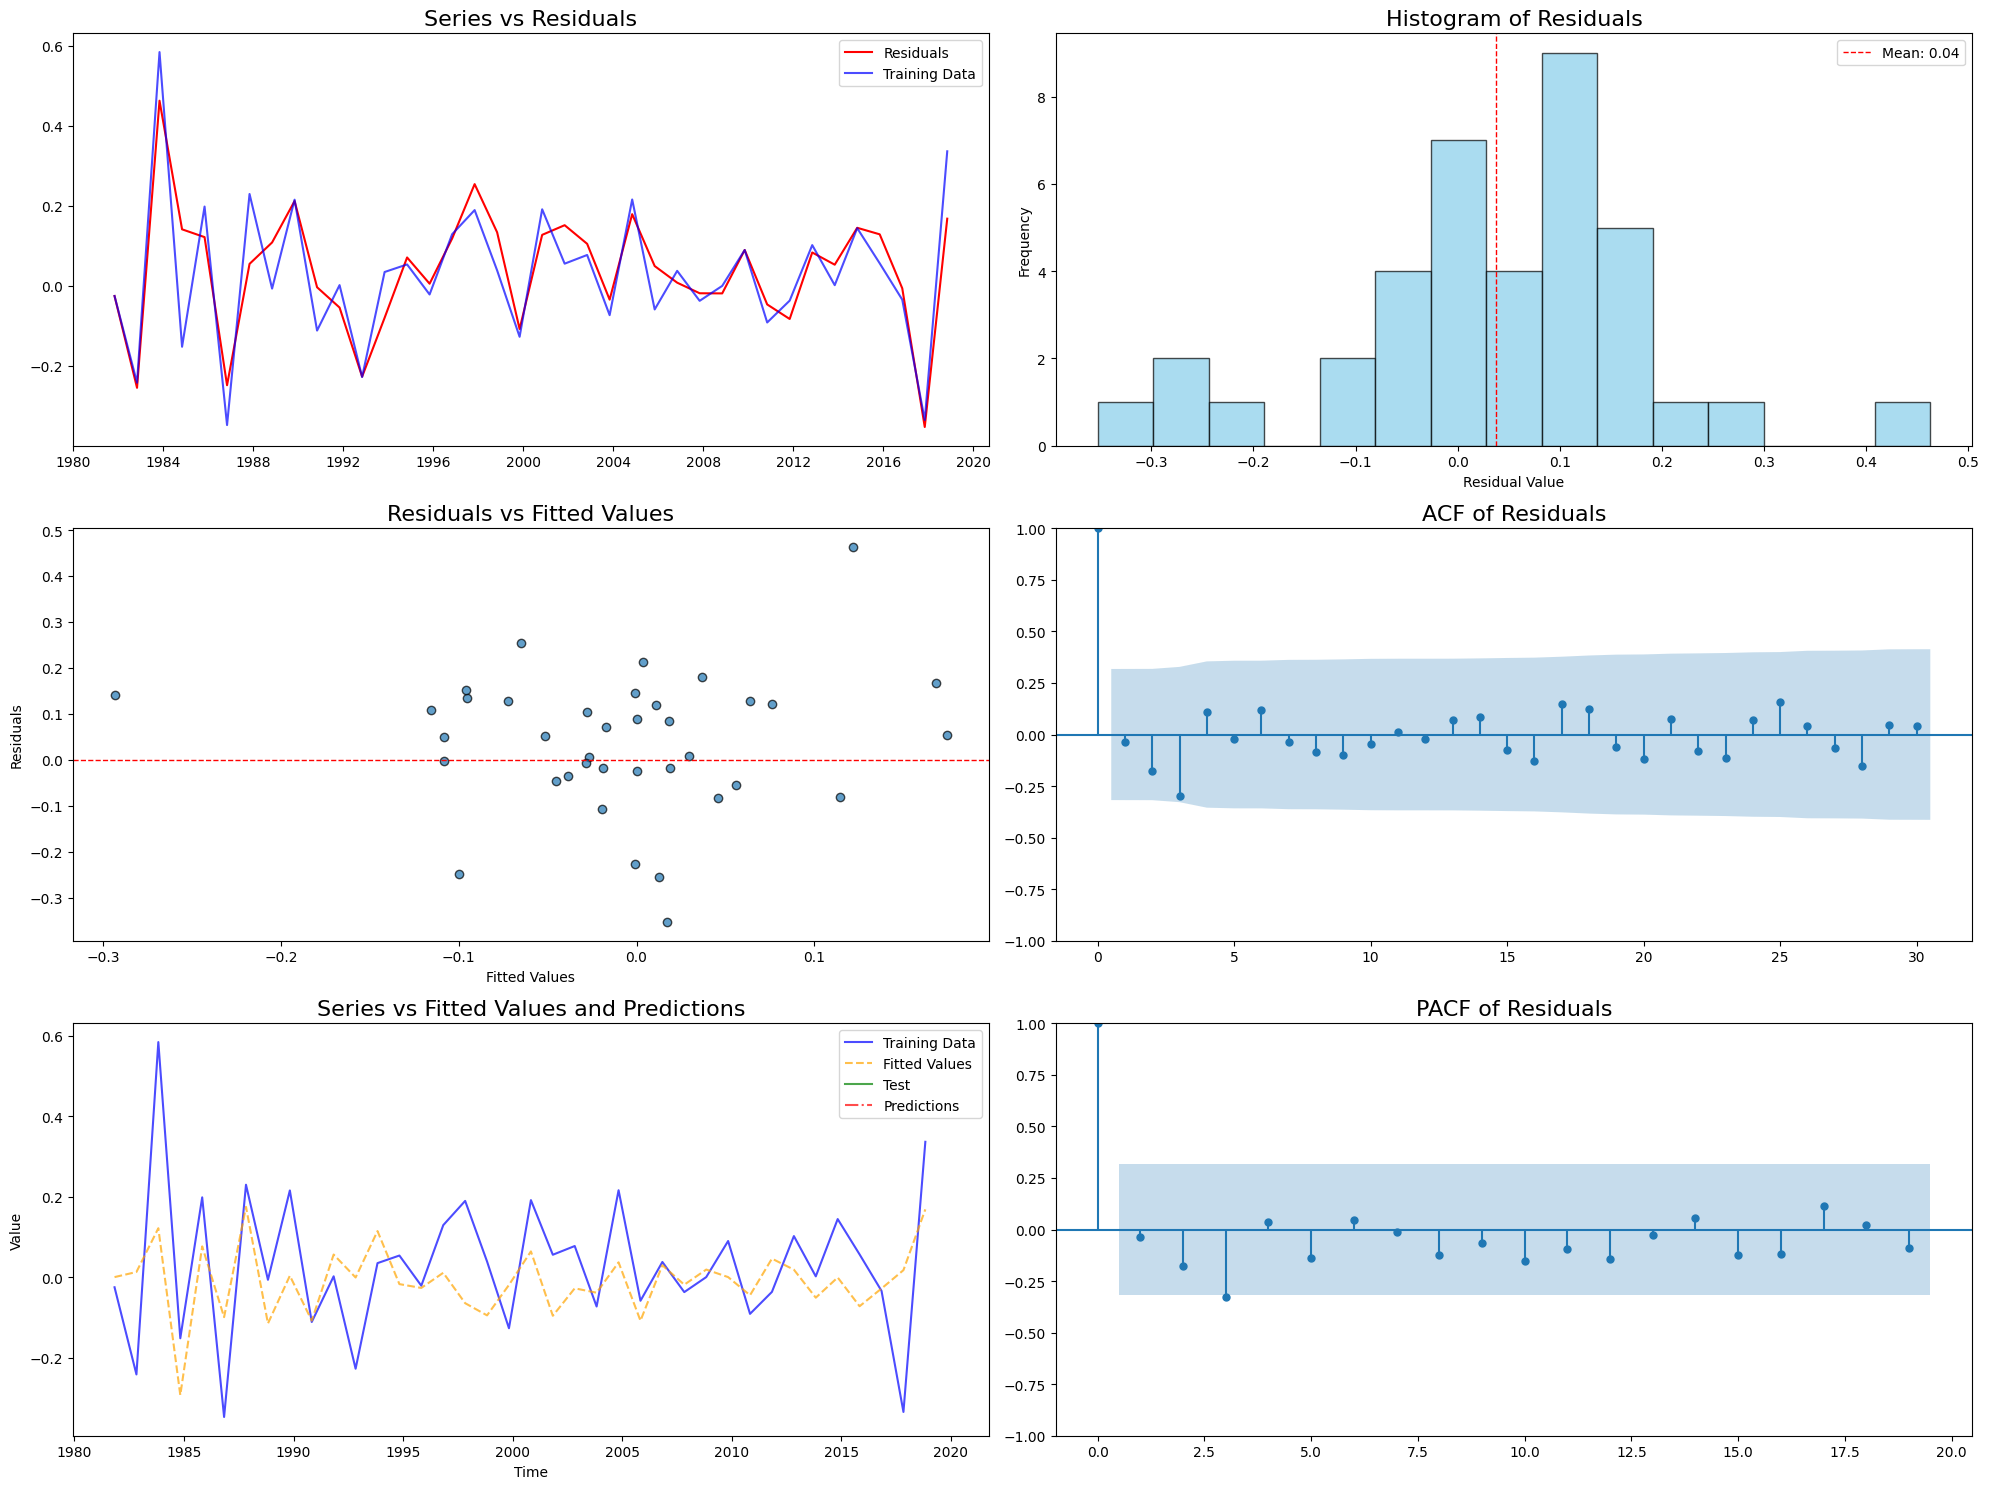

Métricas para conjunto 5:
  MAE: 0.0624
  RMSE: 0.0624
  y_test: -0.1066
  y_pred: -0.1690



Conjunto 6:
  Train: 1981 - 2019 (n=39)
  Test: 2020 - 2020 (n=1)


============================== Model Summary ==============================
                                      SARIMAX Results                                       
Dep. Variable:     Diff - Log - Rendimiento (Kg/Ha)   No. Observations:                   39
Model:                               ARIMA(1, 0, 0)   Log Likelihood                  17.632
Date:                              Tue, 04 Mar 2025   AIC                            -31.263
Time:                                      19:25:53   BIC                            -27.936
Sample:                                  11-01-1981   HQIC                           -30.070
                                       - 11-01-2019                                         
Covariance Type:                                opg                                         
                 c

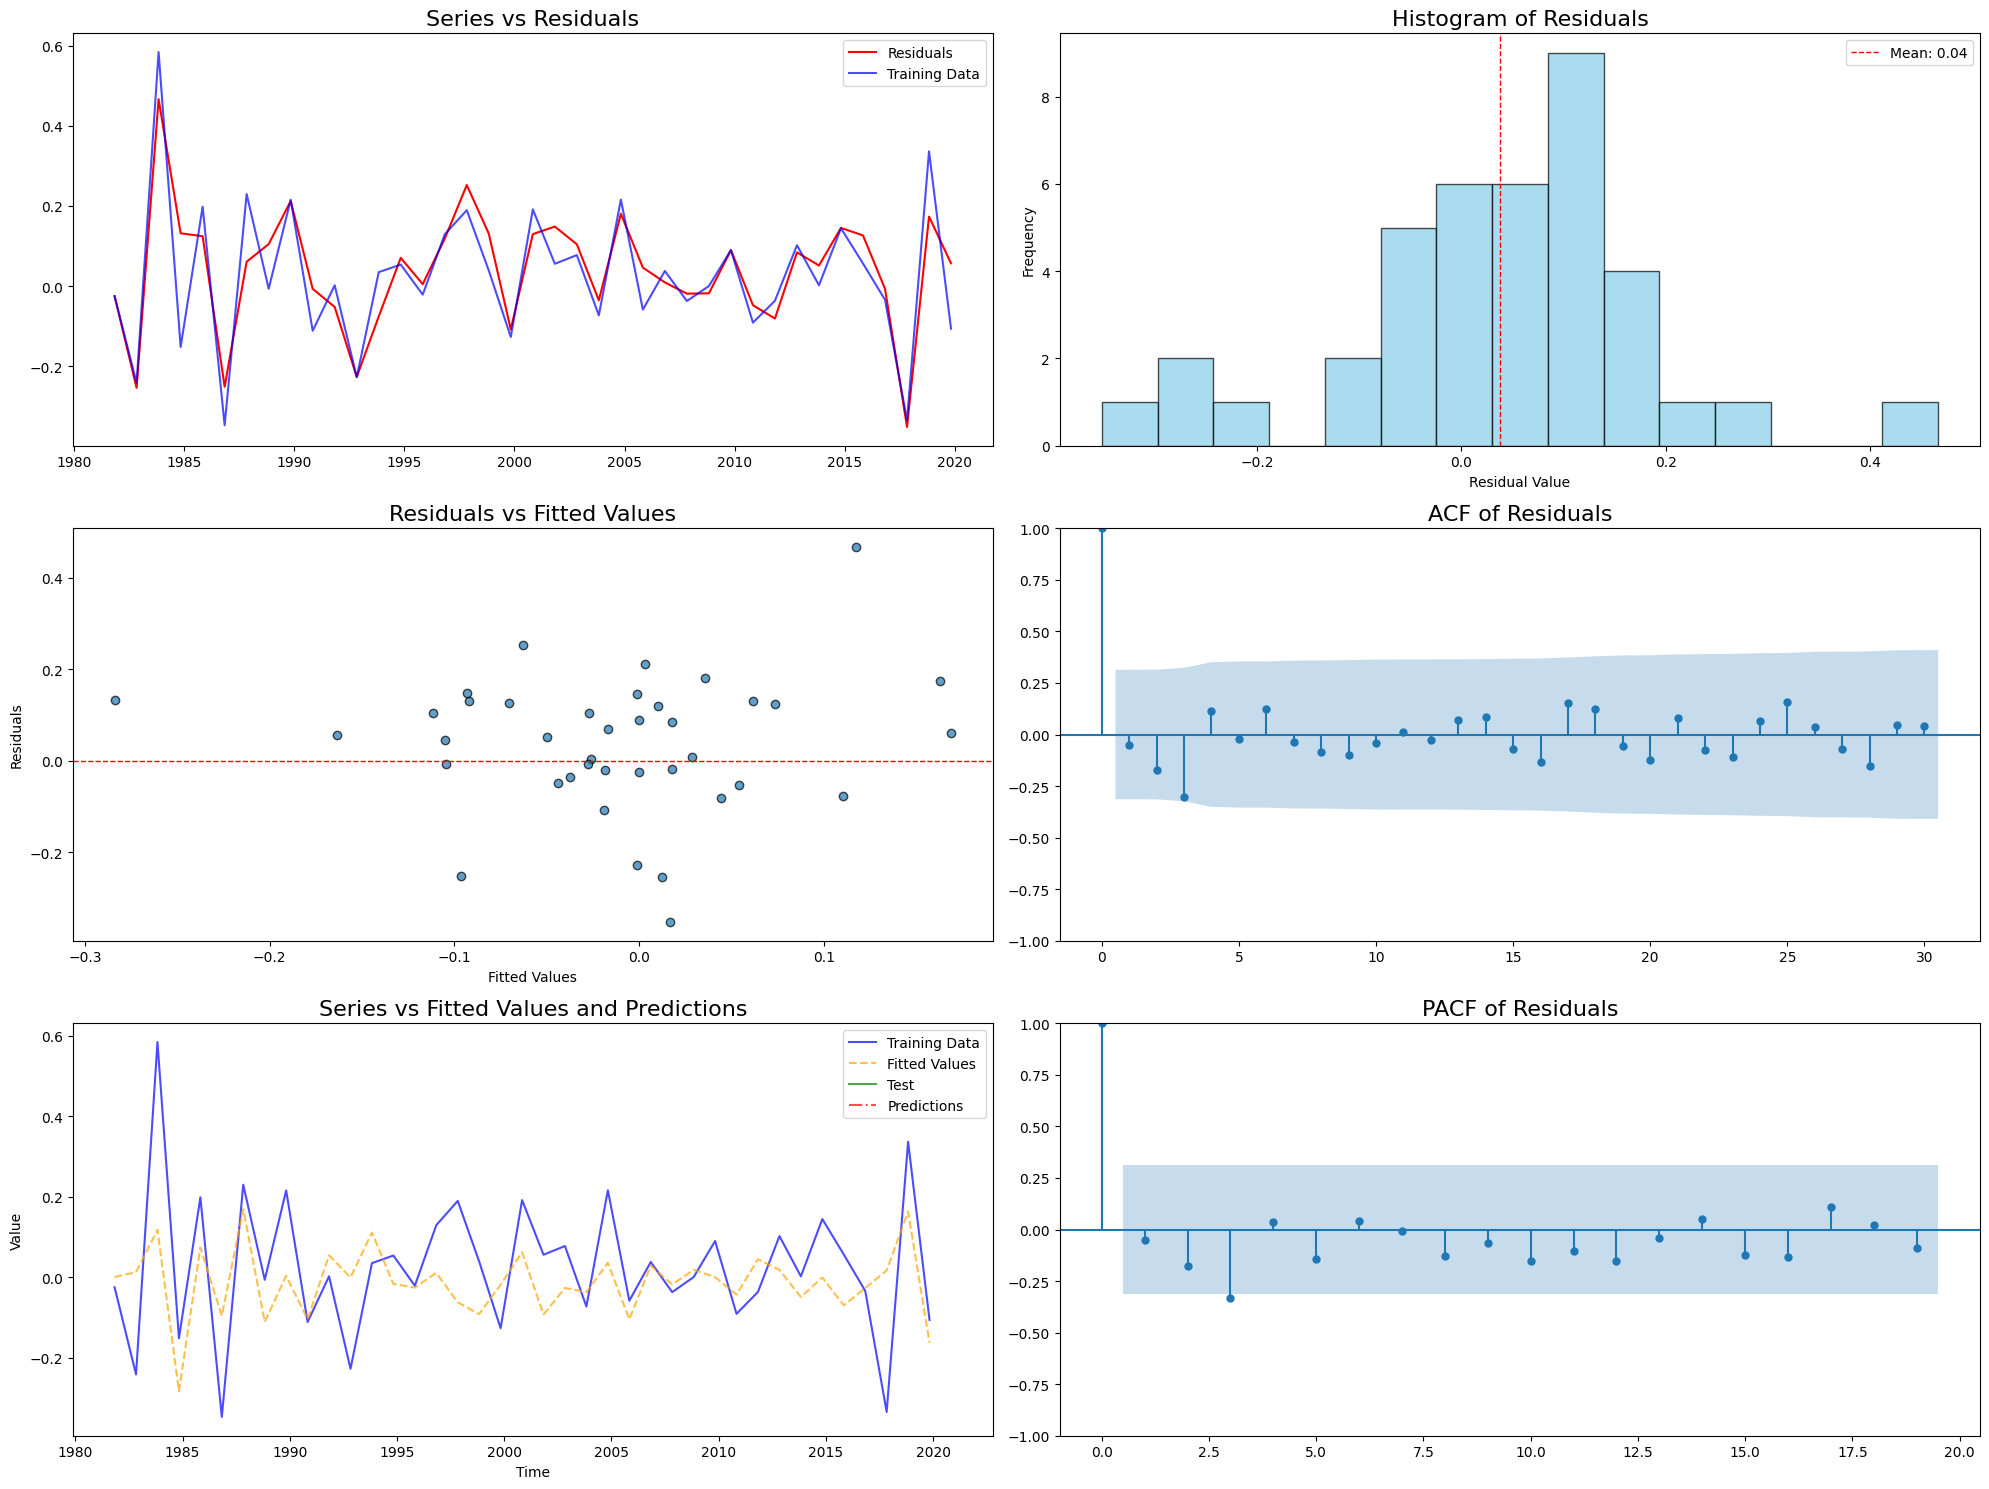

Métricas para conjunto 6:
  MAE: 0.1472
  RMSE: 0.1472
  y_test: -0.0954
  y_pred: 0.0518



Conjunto 7:
  Train: 1981 - 2020 (n=40)
  Test: 2021 - 2021 (n=1)


============================== Model Summary ==============================
                                      SARIMAX Results                                       
Dep. Variable:     Diff - Log - Rendimiento (Kg/Ha)   No. Observations:                   40
Model:                               ARIMA(1, 0, 0)   Log Likelihood                  18.131
Date:                              Tue, 04 Mar 2025   AIC                            -32.262
Time:                                      19:25:55   BIC                            -28.885
Sample:                                  11-01-1981   HQIC                           -31.041
                                       - 11-01-2020                                         
Covariance Type:                                opg                                         
                 co

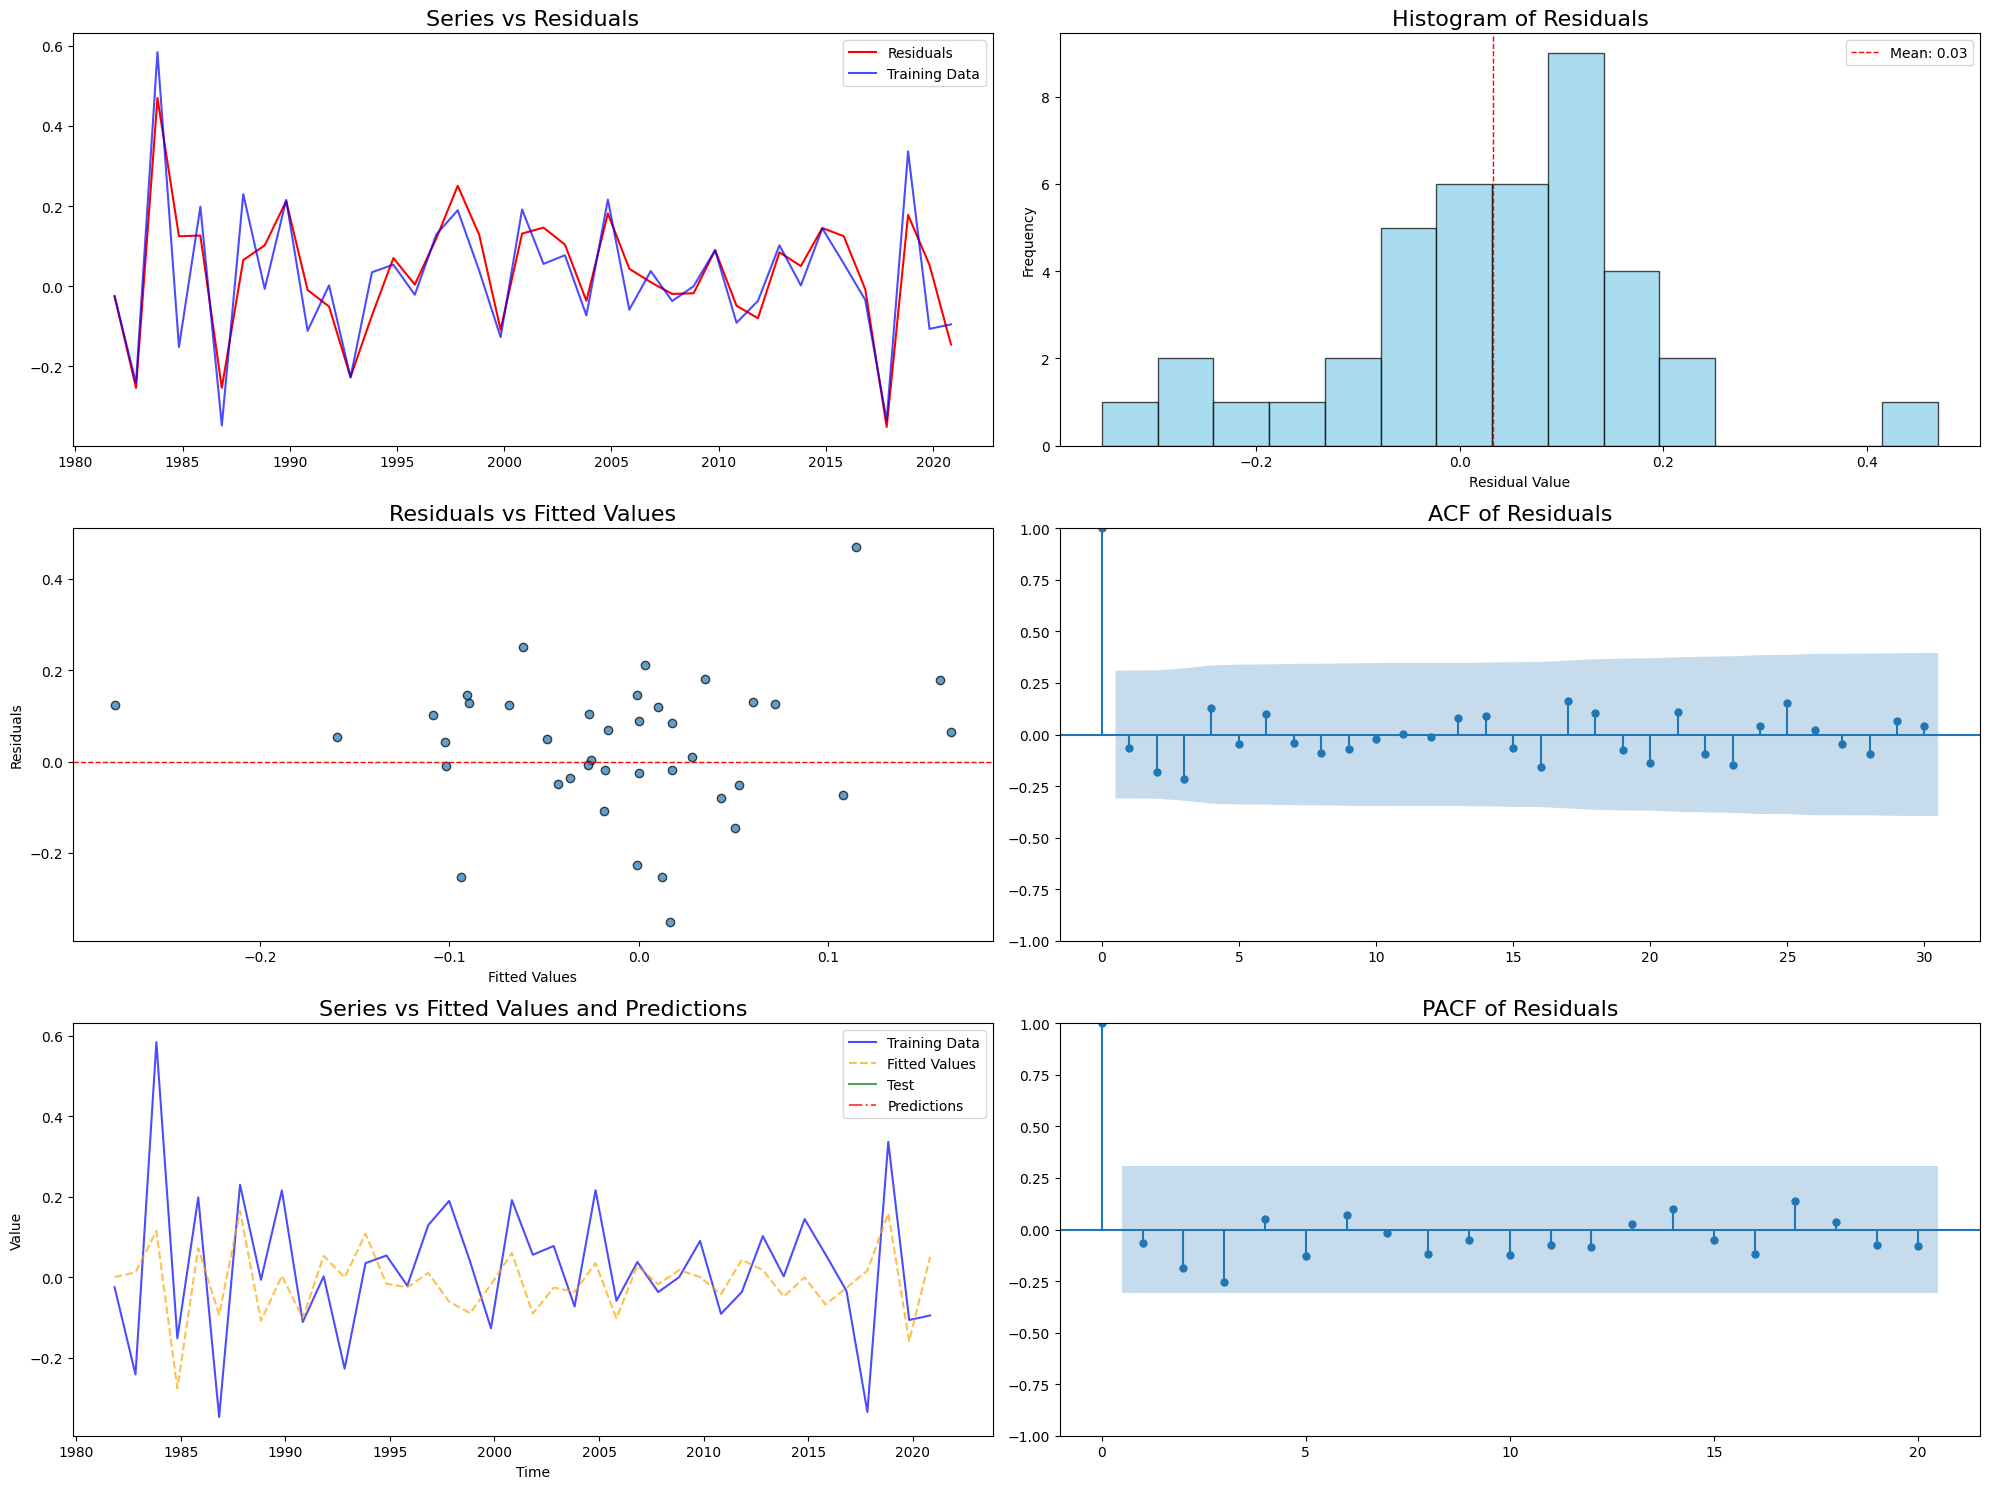

Métricas para conjunto 7:
  MAE: 0.0173
  RMSE: 0.0173
  y_test: 0.0278
  y_pred: 0.0452



Conjunto 8:
  Train: 1981 - 2021 (n=41)
  Test: 2022 - 2022 (n=1)


============================== Model Summary ==============================
                                      SARIMAX Results                                       
Dep. Variable:     Diff - Log - Rendimiento (Kg/Ha)   No. Observations:                   41
Model:                               ARIMA(1, 0, 0)   Log Likelihood                  19.087
Date:                              Tue, 04 Mar 2025   AIC                            -34.175
Time:                                      19:25:57   BIC                            -30.748
Sample:                                  11-01-1981   HQIC                           -32.927
                                       - 11-01-2021                                         
Covariance Type:                                opg                                         
                 coe

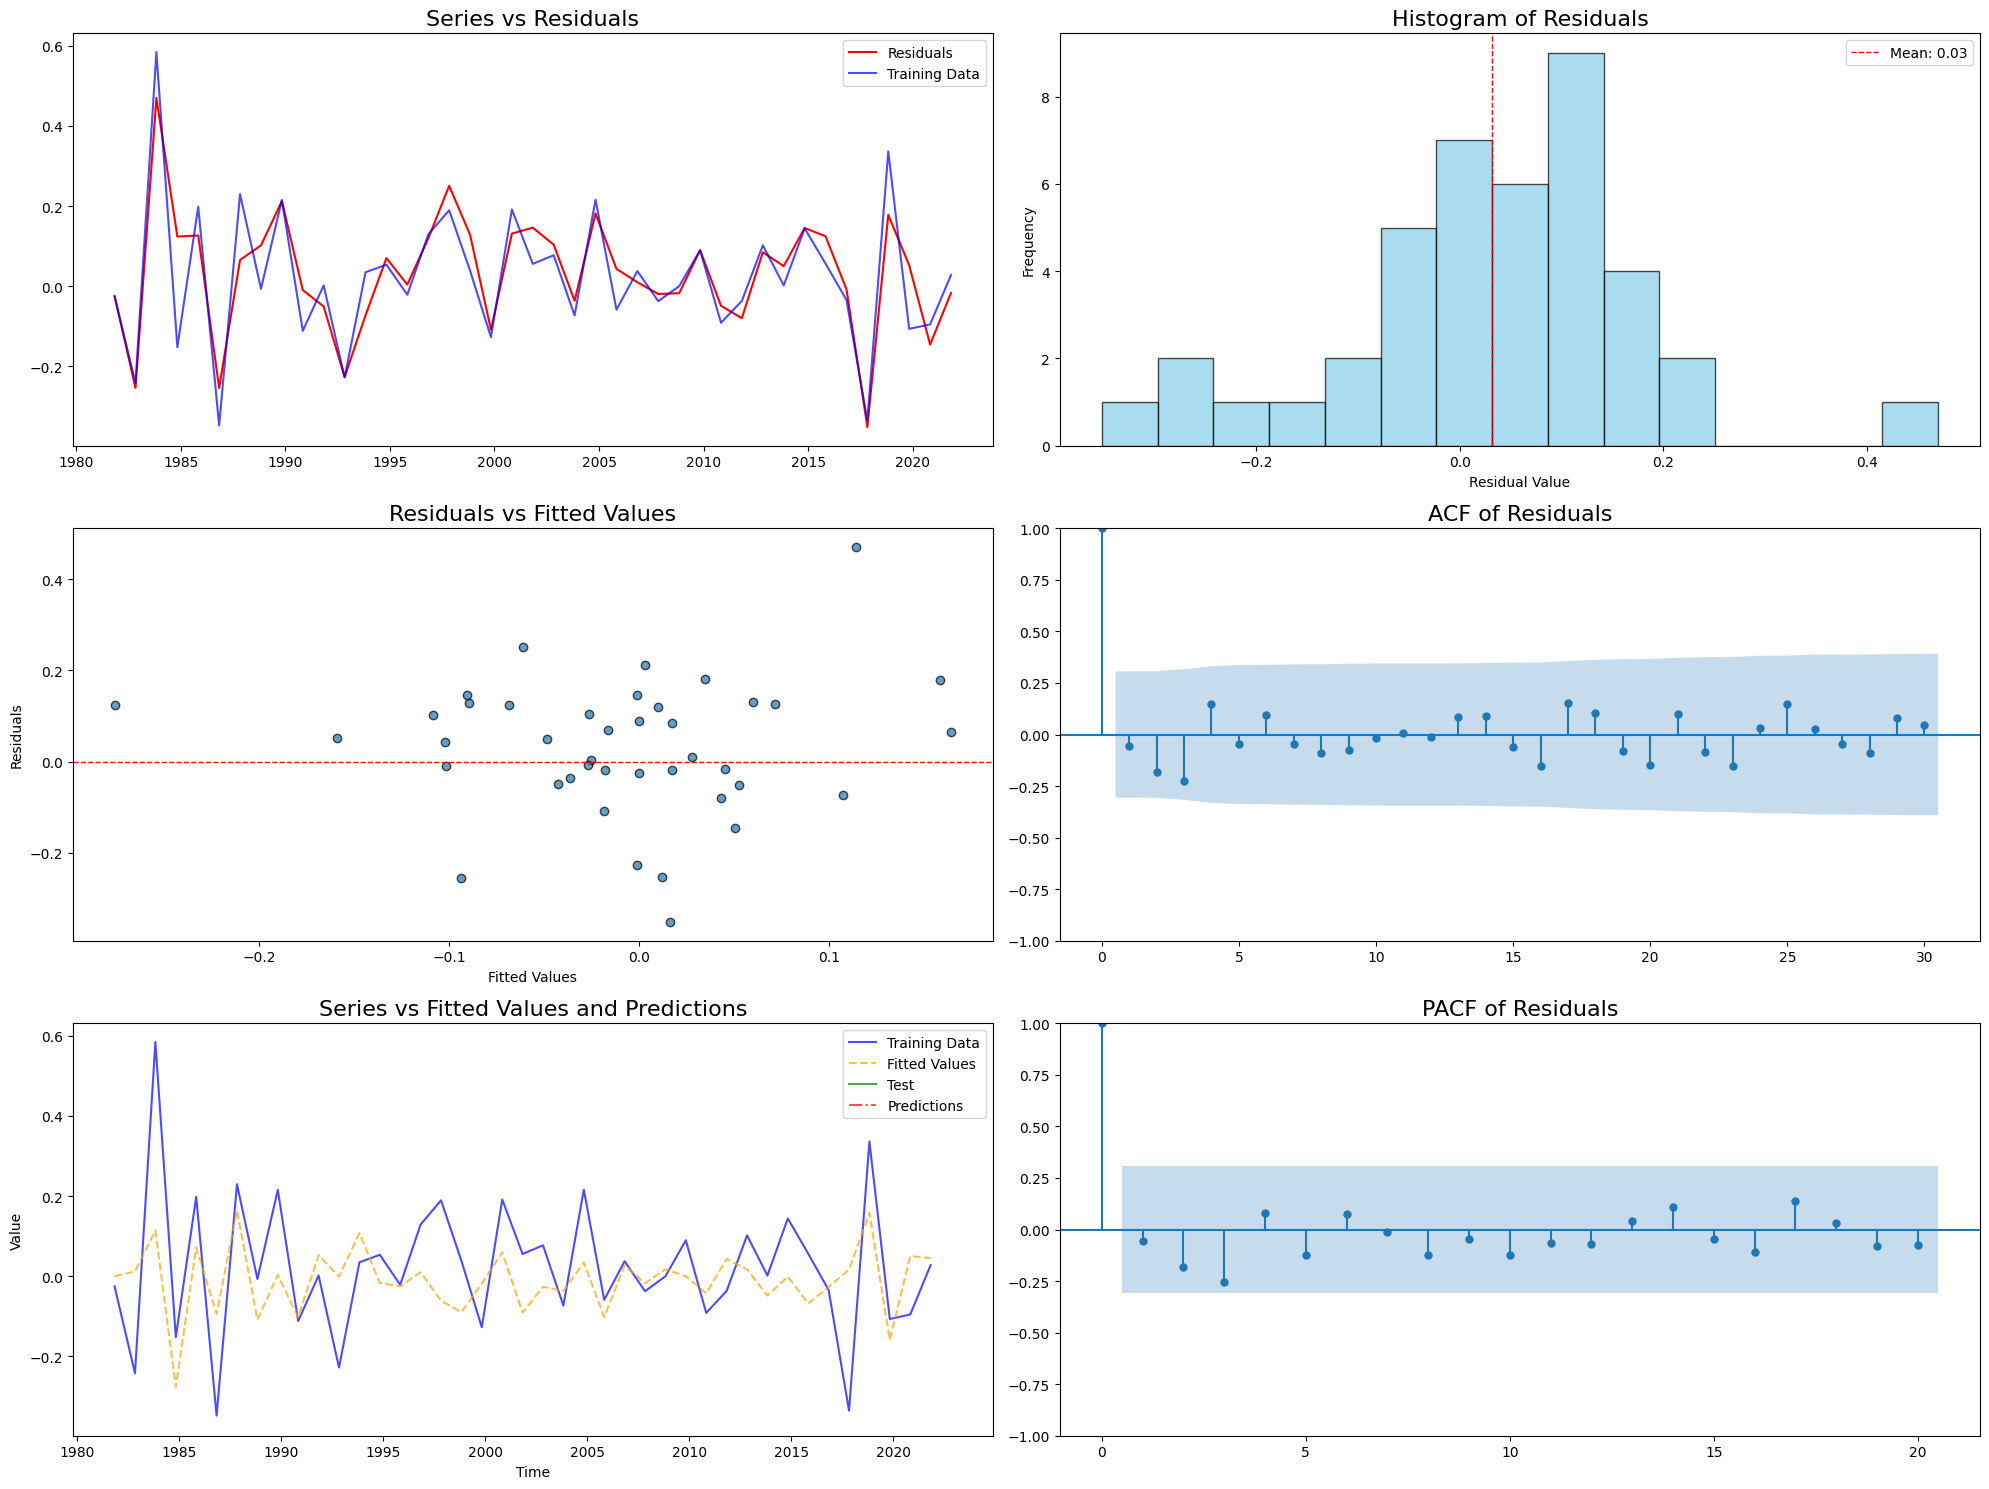

Métricas para conjunto 8:
  MAE: 0.3380
  RMSE: 0.3380
  y_test: -0.3512
  y_pred: -0.0132




RESULTADOS FINALES
                MAE      RMSE    y_test    y_pred
2014-2015  0.125379  0.125379  0.056440 -0.068939
2015-2016  0.008431  0.008431 -0.034396 -0.025965
2016-2017  0.351190  0.351190 -0.335338  0.015852
2017-2018  0.186378  0.186378  0.336440  0.150061
2018-2019  0.062354  0.062354 -0.106604 -0.168959
2019-2020  0.147201  0.147201 -0.095417  0.051785
2020-2021  0.017327  0.017327  0.027841  0.045169
2021-2022  0.338002  0.338002 -0.351153 -0.013151


In [ ]:
resultados = []

# Estructuras para guardar predicciones:
cv_dates = []
cv_campana = []
cv_predictions = []
cv_actuals = []

# Iterar sobre cada split
for i, (trains, tests) in enumerate(train_test_sets):
    # Mostrar detalles del split
    print(f"\n{'='*50}\nConjunto {i+1}:")
    print(f"  Train: {trains.index.min().year} - {trains.index.max().year} (n={len(trains)})")
    print(f"  Test: {tests.index.min().year} - {tests.index.max().year} (n={len(tests)})")
    print(f"{'='*50}\n")

    # Entrenar modelo
    model = ARIMA(trains['Diff - Log - Rendimiento (Kg/Ha)'], order=(1, 0, 0), trend='n')
    results= model.fit()

    # Mostrar summary del modelo
    print(f"\n{'='*30} Model Summary {'='*30}")
    print(results.summary())
    print(f"{'='*75}\n")



    # Predecir y evaluar
    predictions = results.forecast(n_periods=1)
    metricas = evaluar_metricas(tests['Diff - Log - Rendimiento (Kg/Ha)'], predictions)

    # Dado que solo hay un valor, extraemos el escalar
    y_test_scalar = tests['Diff - Log - Rendimiento (Kg/Ha)'].iloc[0]
    y_pred_scalar = predictions[0]

    # Agregar los valores escalar al diccionario de métricas
    metricas["y_test"] = y_test_scalar
    metricas["y_pred"] = y_pred_scalar

    resultados.append(metricas)

    # Almacenamos los datos necesarios para plotear las predicciones luego.
    cv_dates.append(tests.index[0])
    cv_campana.append(tests['Campana'][0])
    cv_predictions.append(y_pred_scalar)
    cv_actuals.append(y_test_scalar)


    # Valores ajustados en train
    fitted_values = results.predict()
    # Residuos
    residuals = trains['Diff - Log - Rendimiento (Kg/Ha)'] - fitted_values

    print("len train", len(trains))
    print("len fitted values:",len(fitted_values))
    print("len residuals", len(residuals))
    print("\n")



    #Diagnostico residuos:
    plot_model_diagnostics(
        residuals,
        fitted_values,
        training_data = trains['Diff - Log - Rendimiento (Kg/Ha)'],
        test_data = tests['Diff - Log - Rendimiento (Kg/Ha)'],
        predictions = predictions
    )

    # Mostrar métricas para este split
    print(f"Métricas para conjunto {i+1}:")
    for k, v in metricas.items():
        print(f"  {k}: {v:.4f}")
    print("\n")

# Convertir resultados a DataFrame
df_autoarima = pd.DataFrame(
    resultados,
    index=[f"{train_end}-{test_year}" for (train_end, test_year) in train_test_splits]
)

# Mostrar resultados finales
print("\n\nRESULTADOS FINALES")
print("="*50)
print(df_autoarima)



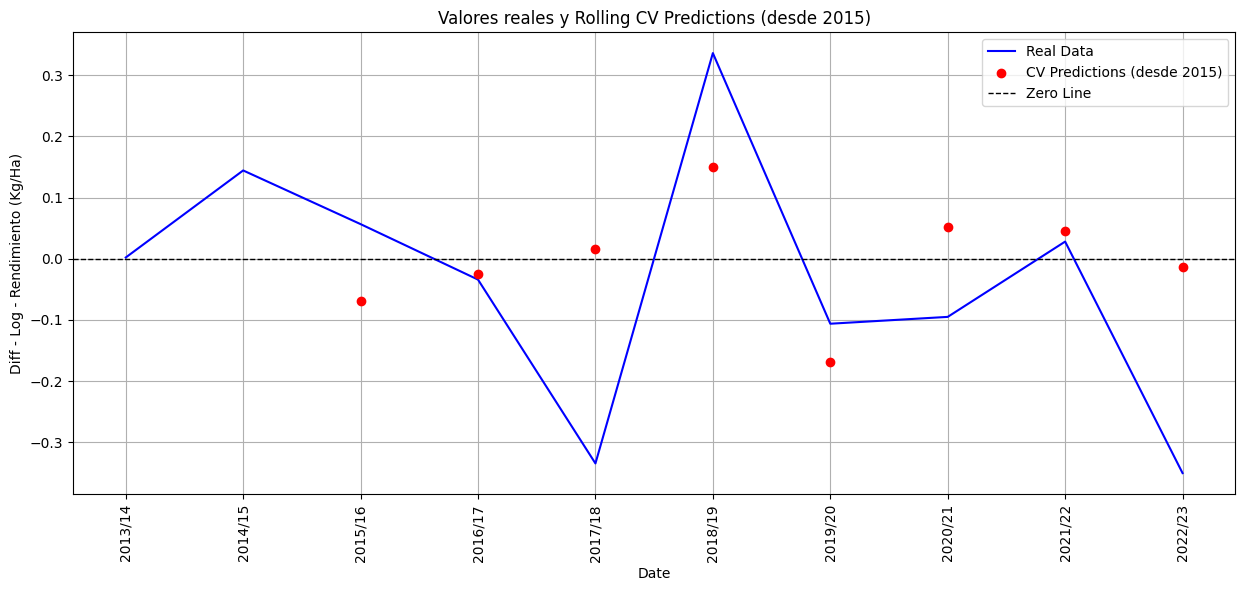

In [ ]:
# --------------------
# Plotting: Real data with Rolling CV Predictions since 2015
# --------------------

# Convert the CV predictions to a DataFrame
df_cv = pd.DataFrame({
    'Campana': cv_campana,
    'prediction': cv_predictions,
    'actual': cv_actuals
}, index=cv_dates).sort_index()


# Filter real data from 2010 onward
series_2012 = series[series.index.year >= 2013]

plt.figure(figsize=(15, 6))
# Plot the full real series
plt.plot(series_2012['Campana'], series_2012['Diff - Log - Rendimiento (Kg/Ha)'], label='Real Data', color='blue')

# Overlay the CV predictions as red dots (for 2010 onward)
plt.scatter(df_cv['Campana'], df_cv['prediction'], color='red', label='CV Predictions (desde 2015)', zorder=5)

# Horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Line')
# Labels and title
plt.xlabel('Date')
plt.ylabel('Diff - Log - Rendimiento (Kg/Ha)')
plt.title('Valores reales y Rolling CV Predictions (desde 2015)')
plt.legend()

# Guardamos la imagen en pdf:
plt.savefig("predictions.pdf", format="pdf", dpi=300, bbox_inches="tight")
#Rotate x-axis labels for all subplots
plt.xticks(rotation=90)
plt.grid()
plt.show()

Rolling CV métricas:

In [ ]:
evaluar_metricas(df_cv['actual'], df_cv['prediction'])

{'MAE': 0.1545329623633857, 'RMSE': 0.1981047678843941}

## Precipitaciones


Conjunto 1:
  Train: 1981 - 2014 (n=34)
  Test: 2015 - 2015 (n=1)


============================== Model Summary ==============================
                                         SARIMAX Results                                          
Dep. Variable:     Diff - BC - weighted_sum_precipitation   No. Observations:                   34
Model:                                     ARIMA(2, 0, 0)   Log Likelihood                 110.791
Date:                                    Tue, 04 Mar 2025   AIC                           -215.582
Time:                                            19:25:59   BIC                           -211.003
Sample:                                        11-01-1981   HQIC                          -214.021
                                             - 11-01-2014                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.

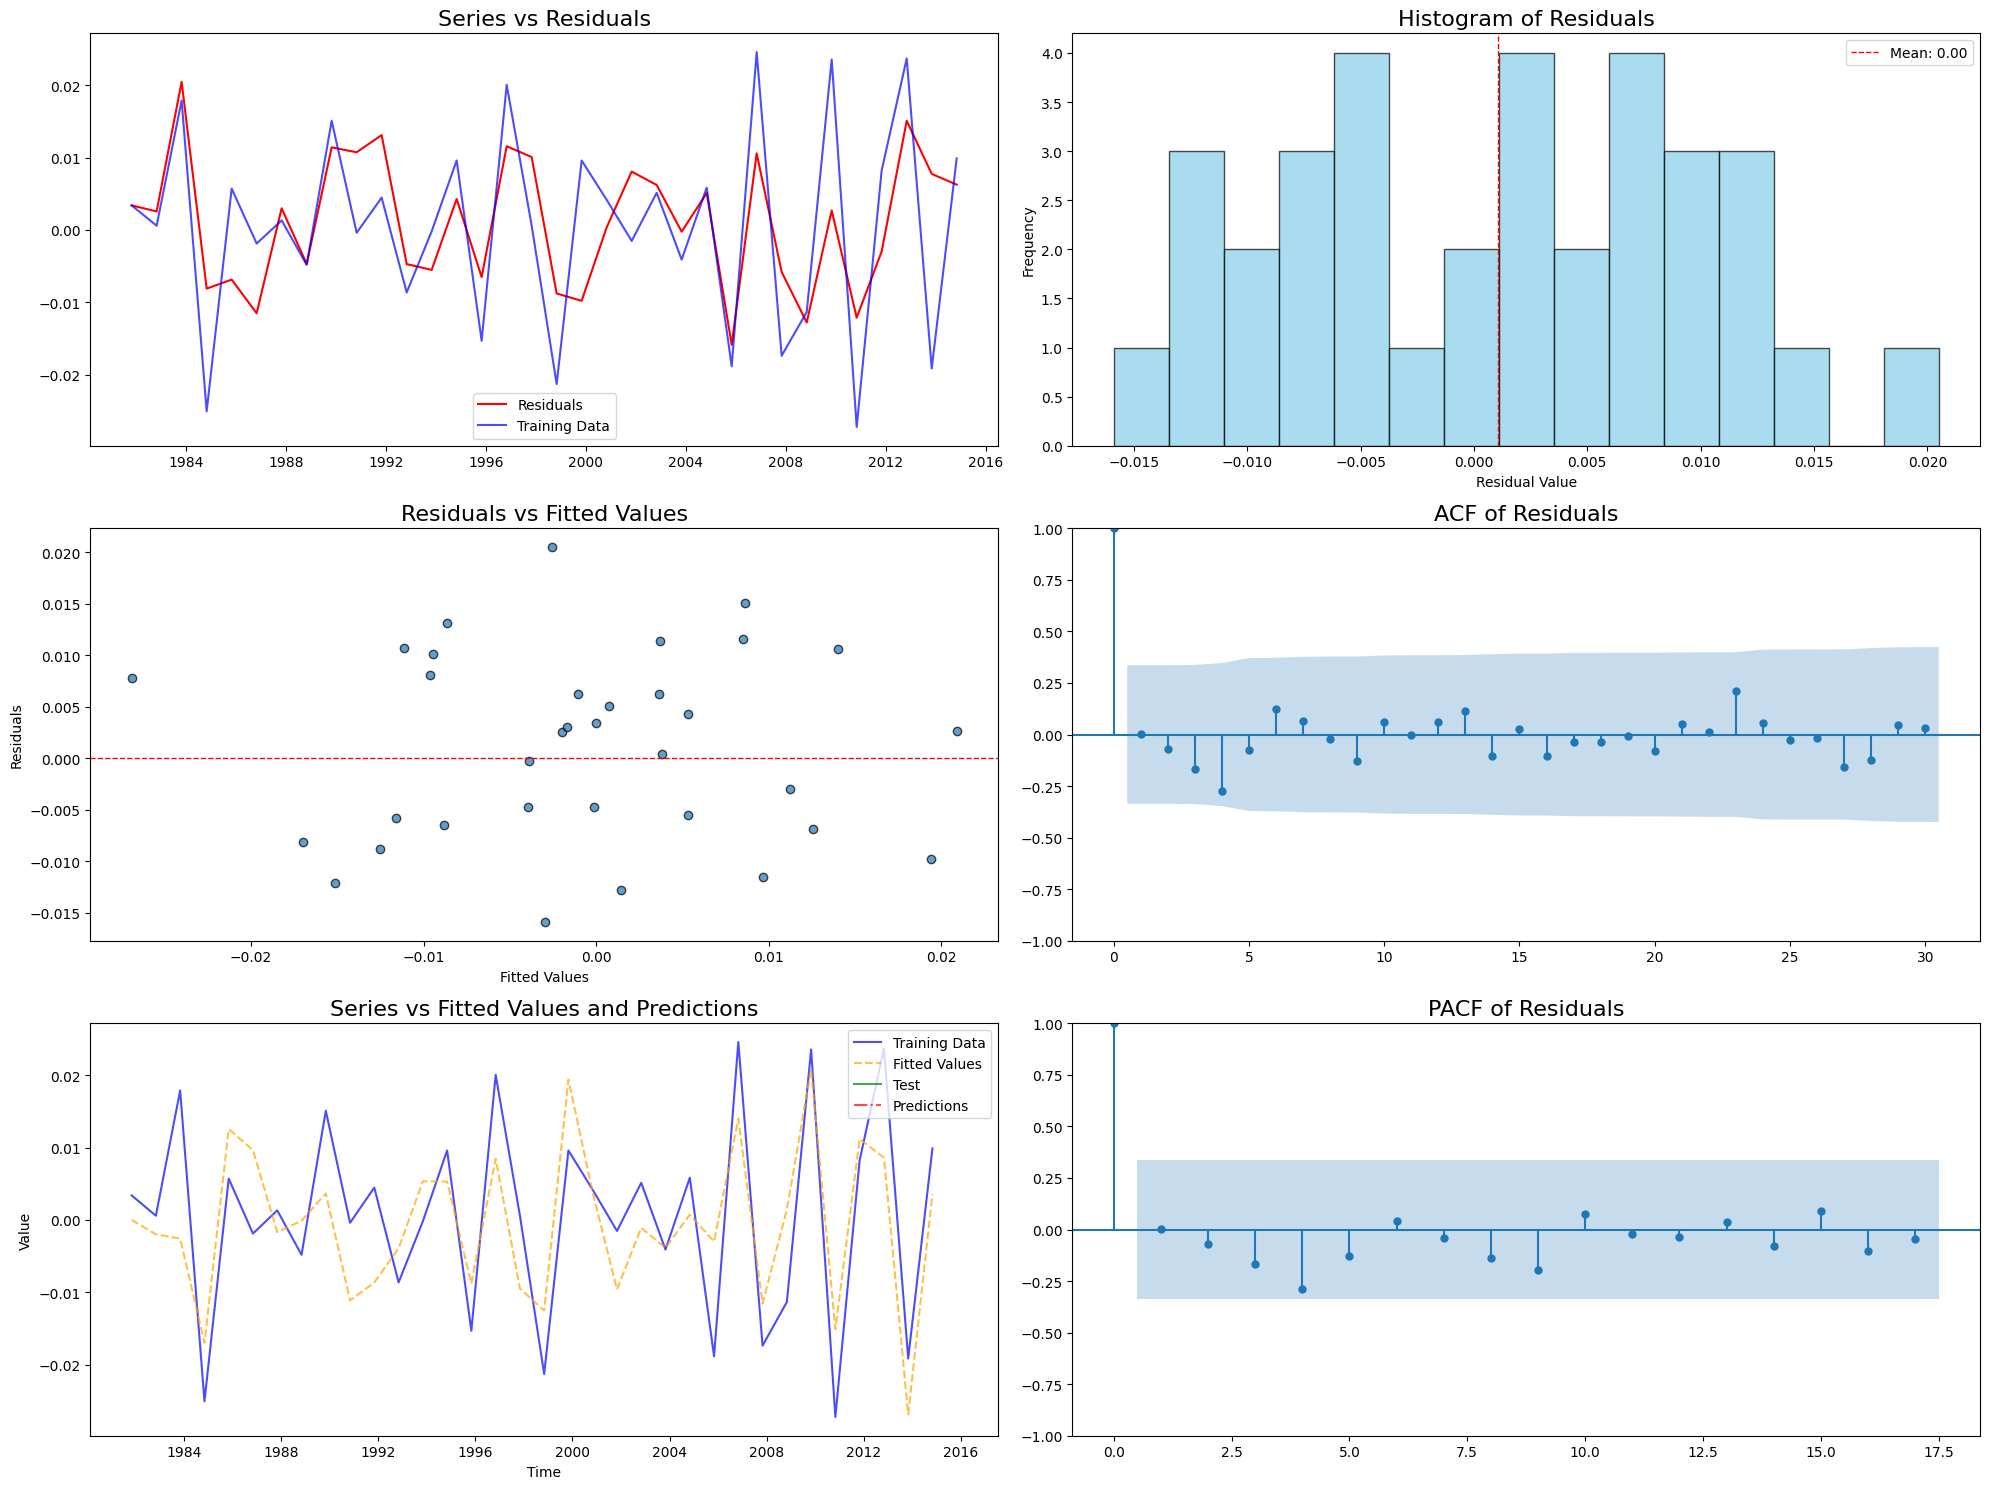

Métricas para conjunto 1:
  MAE: 0.0001
  RMSE: 0.0001
  y_test: 0.0023
  y_pred: 0.0022



Conjunto 2:
  Train: 1981 - 2015 (n=35)
  Test: 2016 - 2016 (n=1)


============================== Model Summary ==============================
                                         SARIMAX Results                                          
Dep. Variable:     Diff - BC - weighted_sum_precipitation   No. Observations:                   35
Model:                                     ARIMA(2, 0, 0)   Log Likelihood                 114.576
Date:                                    Tue, 04 Mar 2025   AIC                           -223.151
Time:                                            19:26:01   BIC                           -218.485
Sample:                                        11-01-1981   HQIC                          -221.541
                                             - 11-01-2015                                         
Covariance Type:                                      opg              

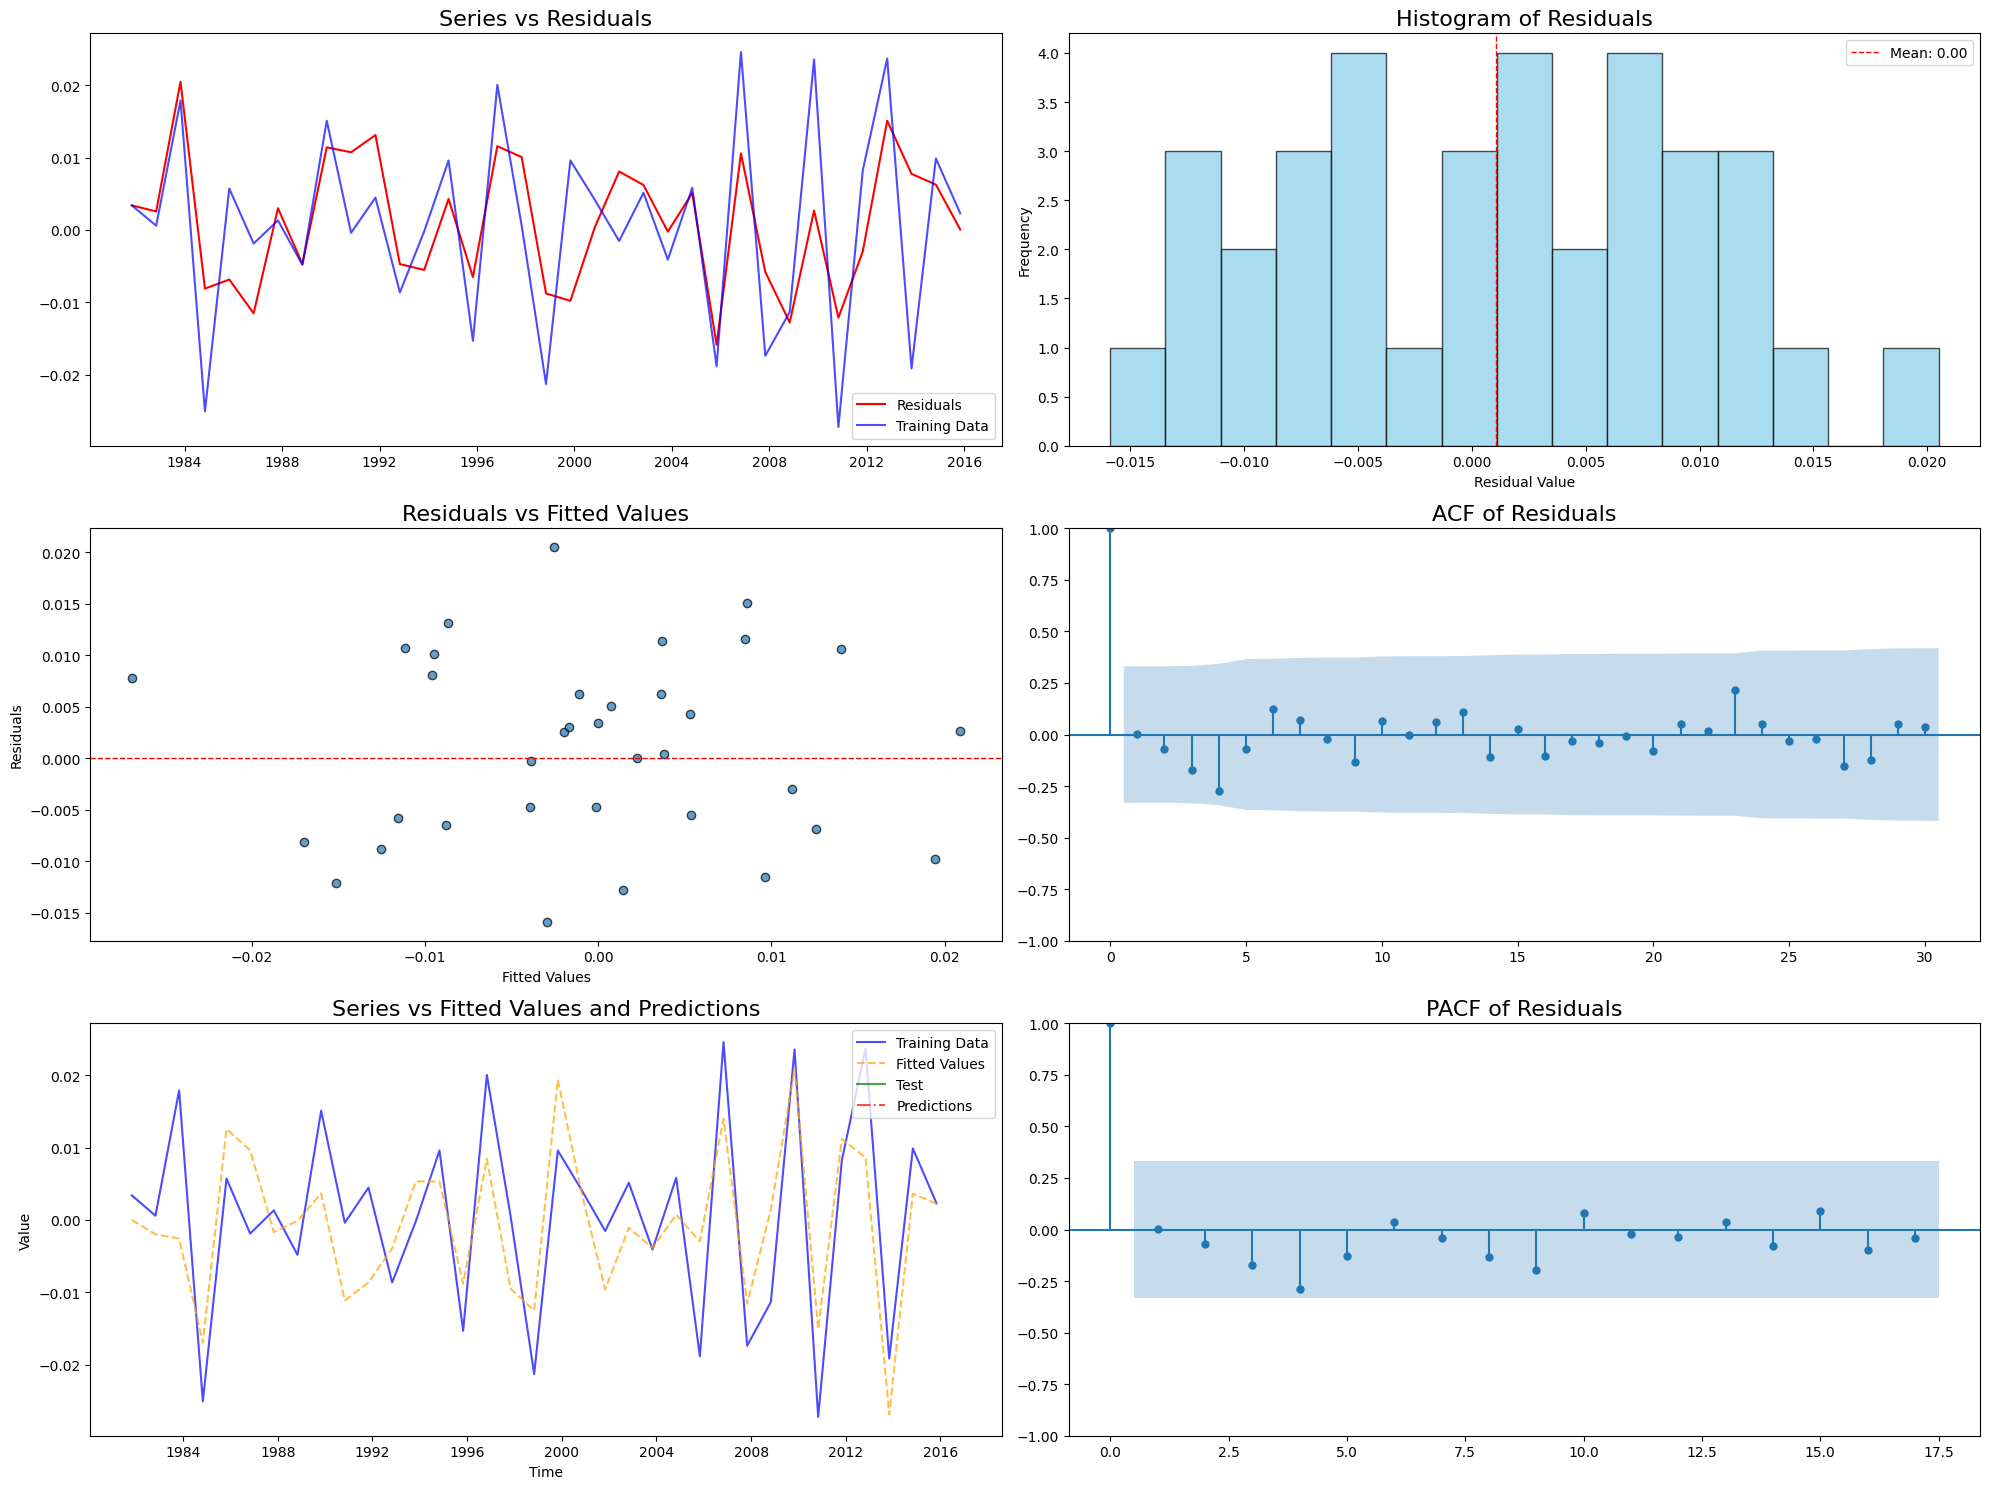

Métricas para conjunto 2:
  MAE: 0.0073
  RMSE: 0.0073
  y_test: -0.0007
  y_pred: -0.0080



Conjunto 3:
  Train: 1981 - 2016 (n=36)
  Test: 2017 - 2017 (n=1)


============================== Model Summary ==============================
                                         SARIMAX Results                                          
Dep. Variable:     Diff - BC - weighted_sum_precipitation   No. Observations:                   36
Model:                                     ARIMA(2, 0, 0)   Log Likelihood                 118.079
Date:                                    Tue, 04 Mar 2025   AIC                           -230.158
Time:                                            19:26:02   BIC                           -225.407
Sample:                                        11-01-1981   HQIC                          -228.500
                                             - 11-01-2016                                         
Covariance Type:                                      opg            

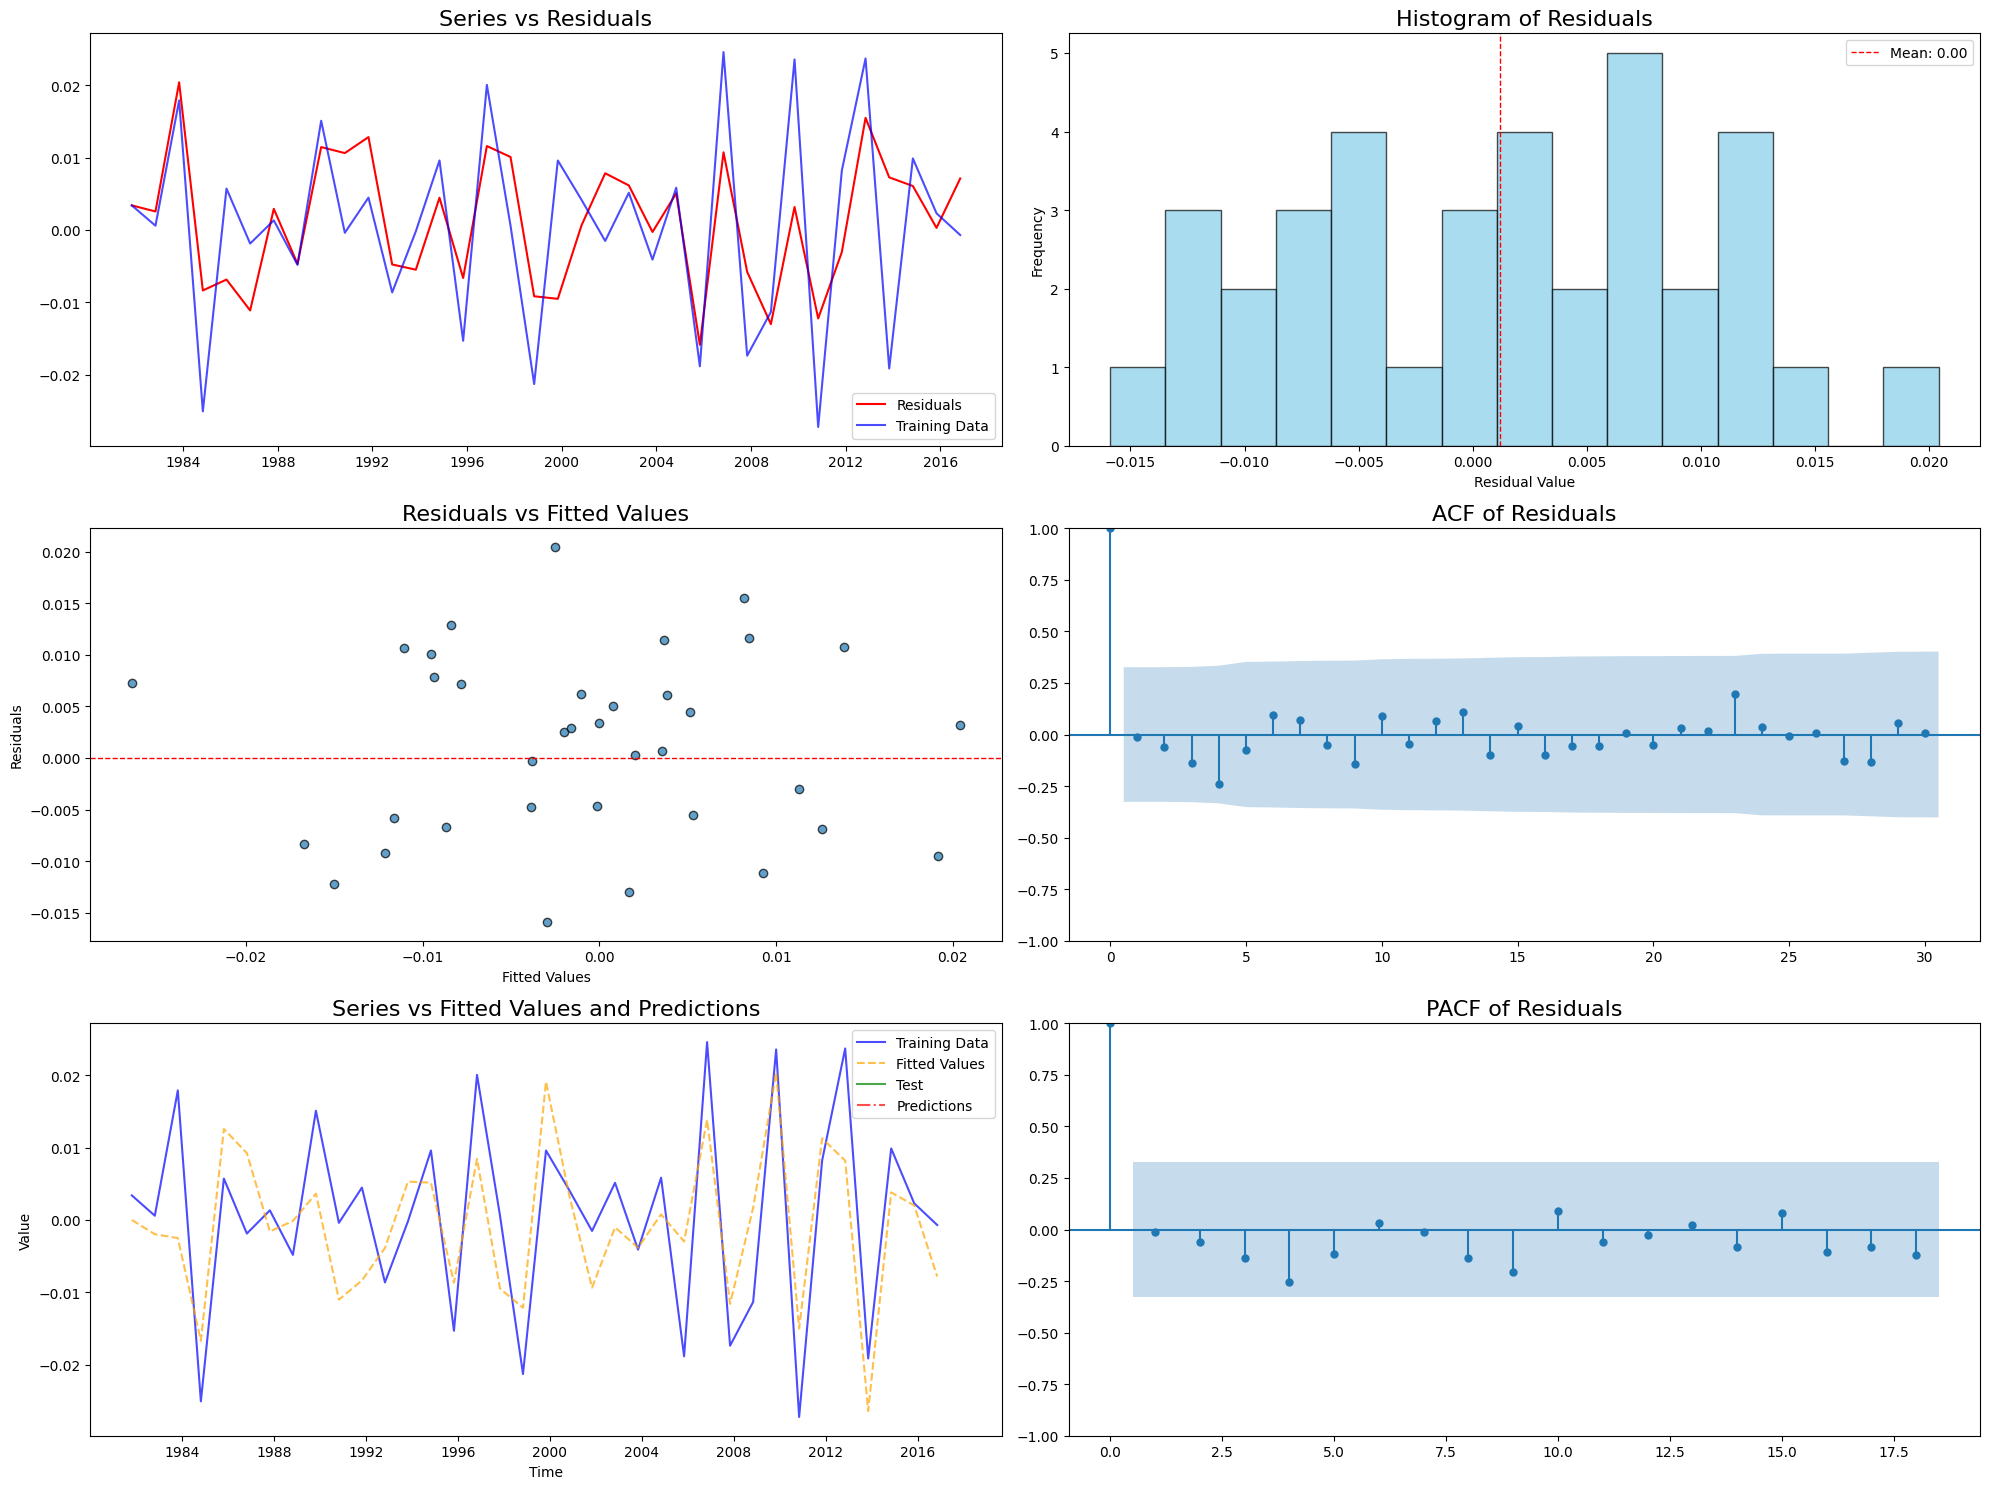

Métricas para conjunto 3:
  MAE: 0.0135
  RMSE: 0.0135
  y_test: -0.0142
  y_pred: -0.0007



Conjunto 4:
  Train: 1981 - 2017 (n=37)
  Test: 2018 - 2018 (n=1)


============================== Model Summary ==============================
                                         SARIMAX Results                                          
Dep. Variable:     Diff - BC - weighted_sum_precipitation   No. Observations:                   37
Model:                                     ARIMA(2, 0, 0)   Log Likelihood                 120.764
Date:                                    Tue, 04 Mar 2025   AIC                           -235.528
Time:                                            19:26:04   BIC                           -230.695
Sample:                                        11-01-1981   HQIC                          -233.824
                                             - 11-01-2017                                         
Covariance Type:                                      opg            

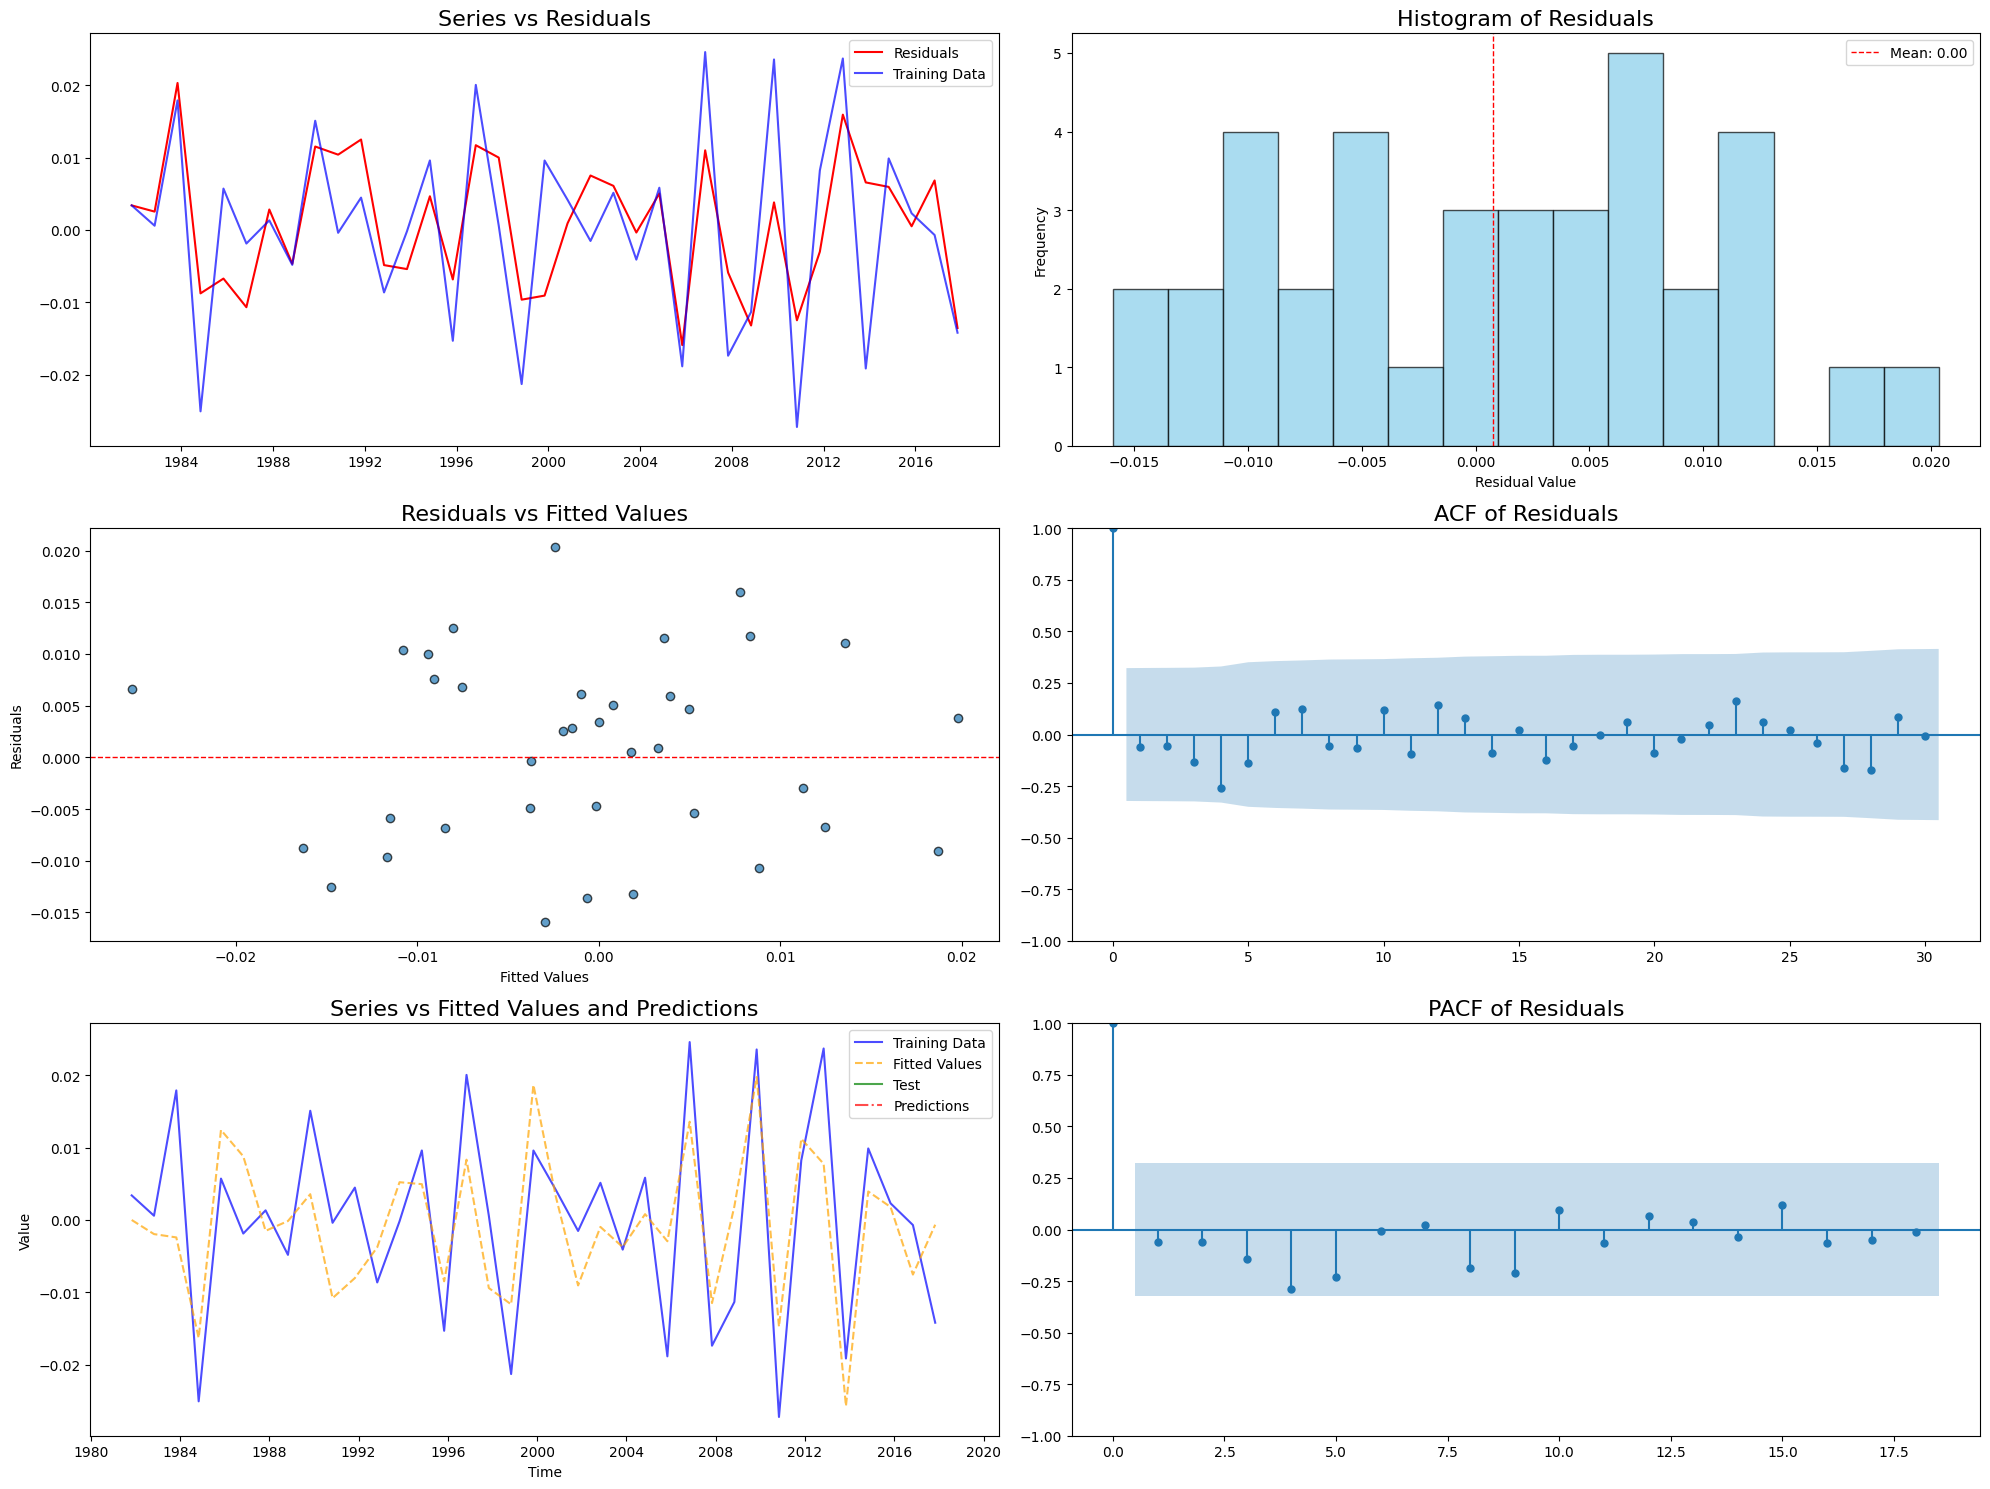

Métricas para conjunto 4:
  MAE: 0.0008
  RMSE: 0.0008
  y_test: 0.0139
  y_pred: 0.0131



Conjunto 5:
  Train: 1981 - 2018 (n=38)
  Test: 2019 - 2019 (n=1)


============================== Model Summary ==============================
                                         SARIMAX Results                                          
Dep. Variable:     Diff - BC - weighted_sum_precipitation   No. Observations:                   38
Model:                                     ARIMA(2, 0, 0)   Log Likelihood                 124.546
Date:                                    Tue, 04 Mar 2025   AIC                           -243.092
Time:                                            19:26:05   BIC                           -238.179
Sample:                                        11-01-1981   HQIC                          -241.344
                                             - 11-01-2018                                         
Covariance Type:                                      opg              

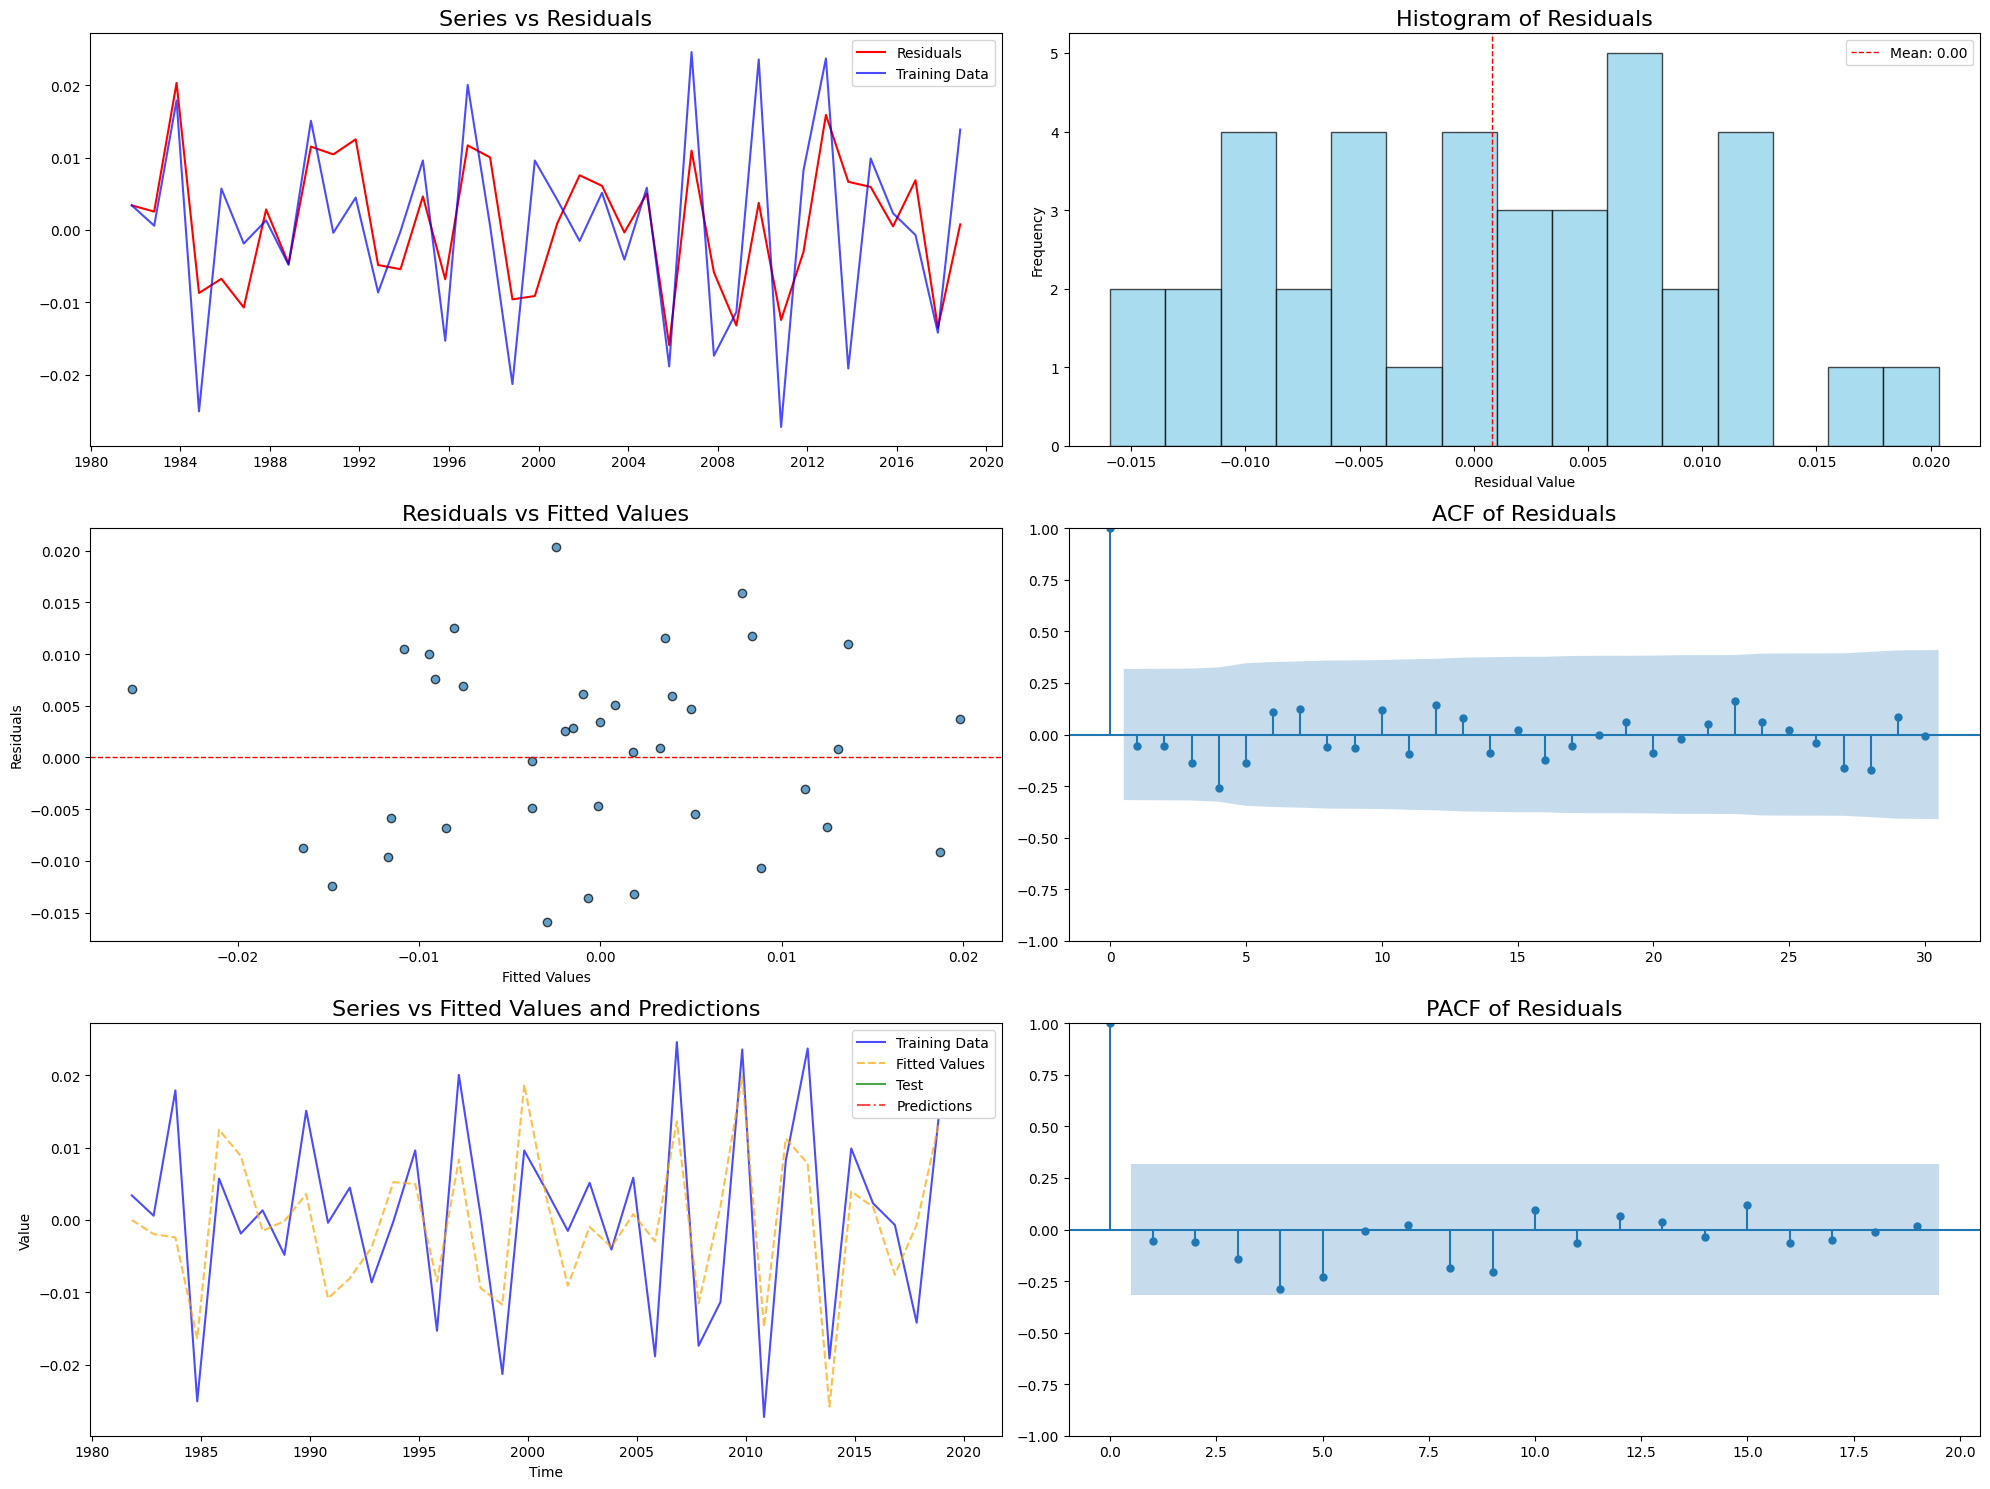

Métricas para conjunto 5:
  MAE: 0.0032
  RMSE: 0.0032
  y_test: -0.0014
  y_pred: -0.0045



Conjunto 6:
  Train: 1981 - 2019 (n=39)
  Test: 2020 - 2020 (n=1)


============================== Model Summary ==============================
                                         SARIMAX Results                                          
Dep. Variable:     Diff - BC - weighted_sum_precipitation   No. Observations:                   39
Model:                                     ARIMA(2, 0, 0)   Log Likelihood                 128.284
Date:                                    Tue, 04 Mar 2025   AIC                           -250.568
Time:                                            19:26:07   BIC                           -245.577
Sample:                                        11-01-1981   HQIC                          -248.777
                                             - 11-01-2019                                         
Covariance Type:                                      opg            

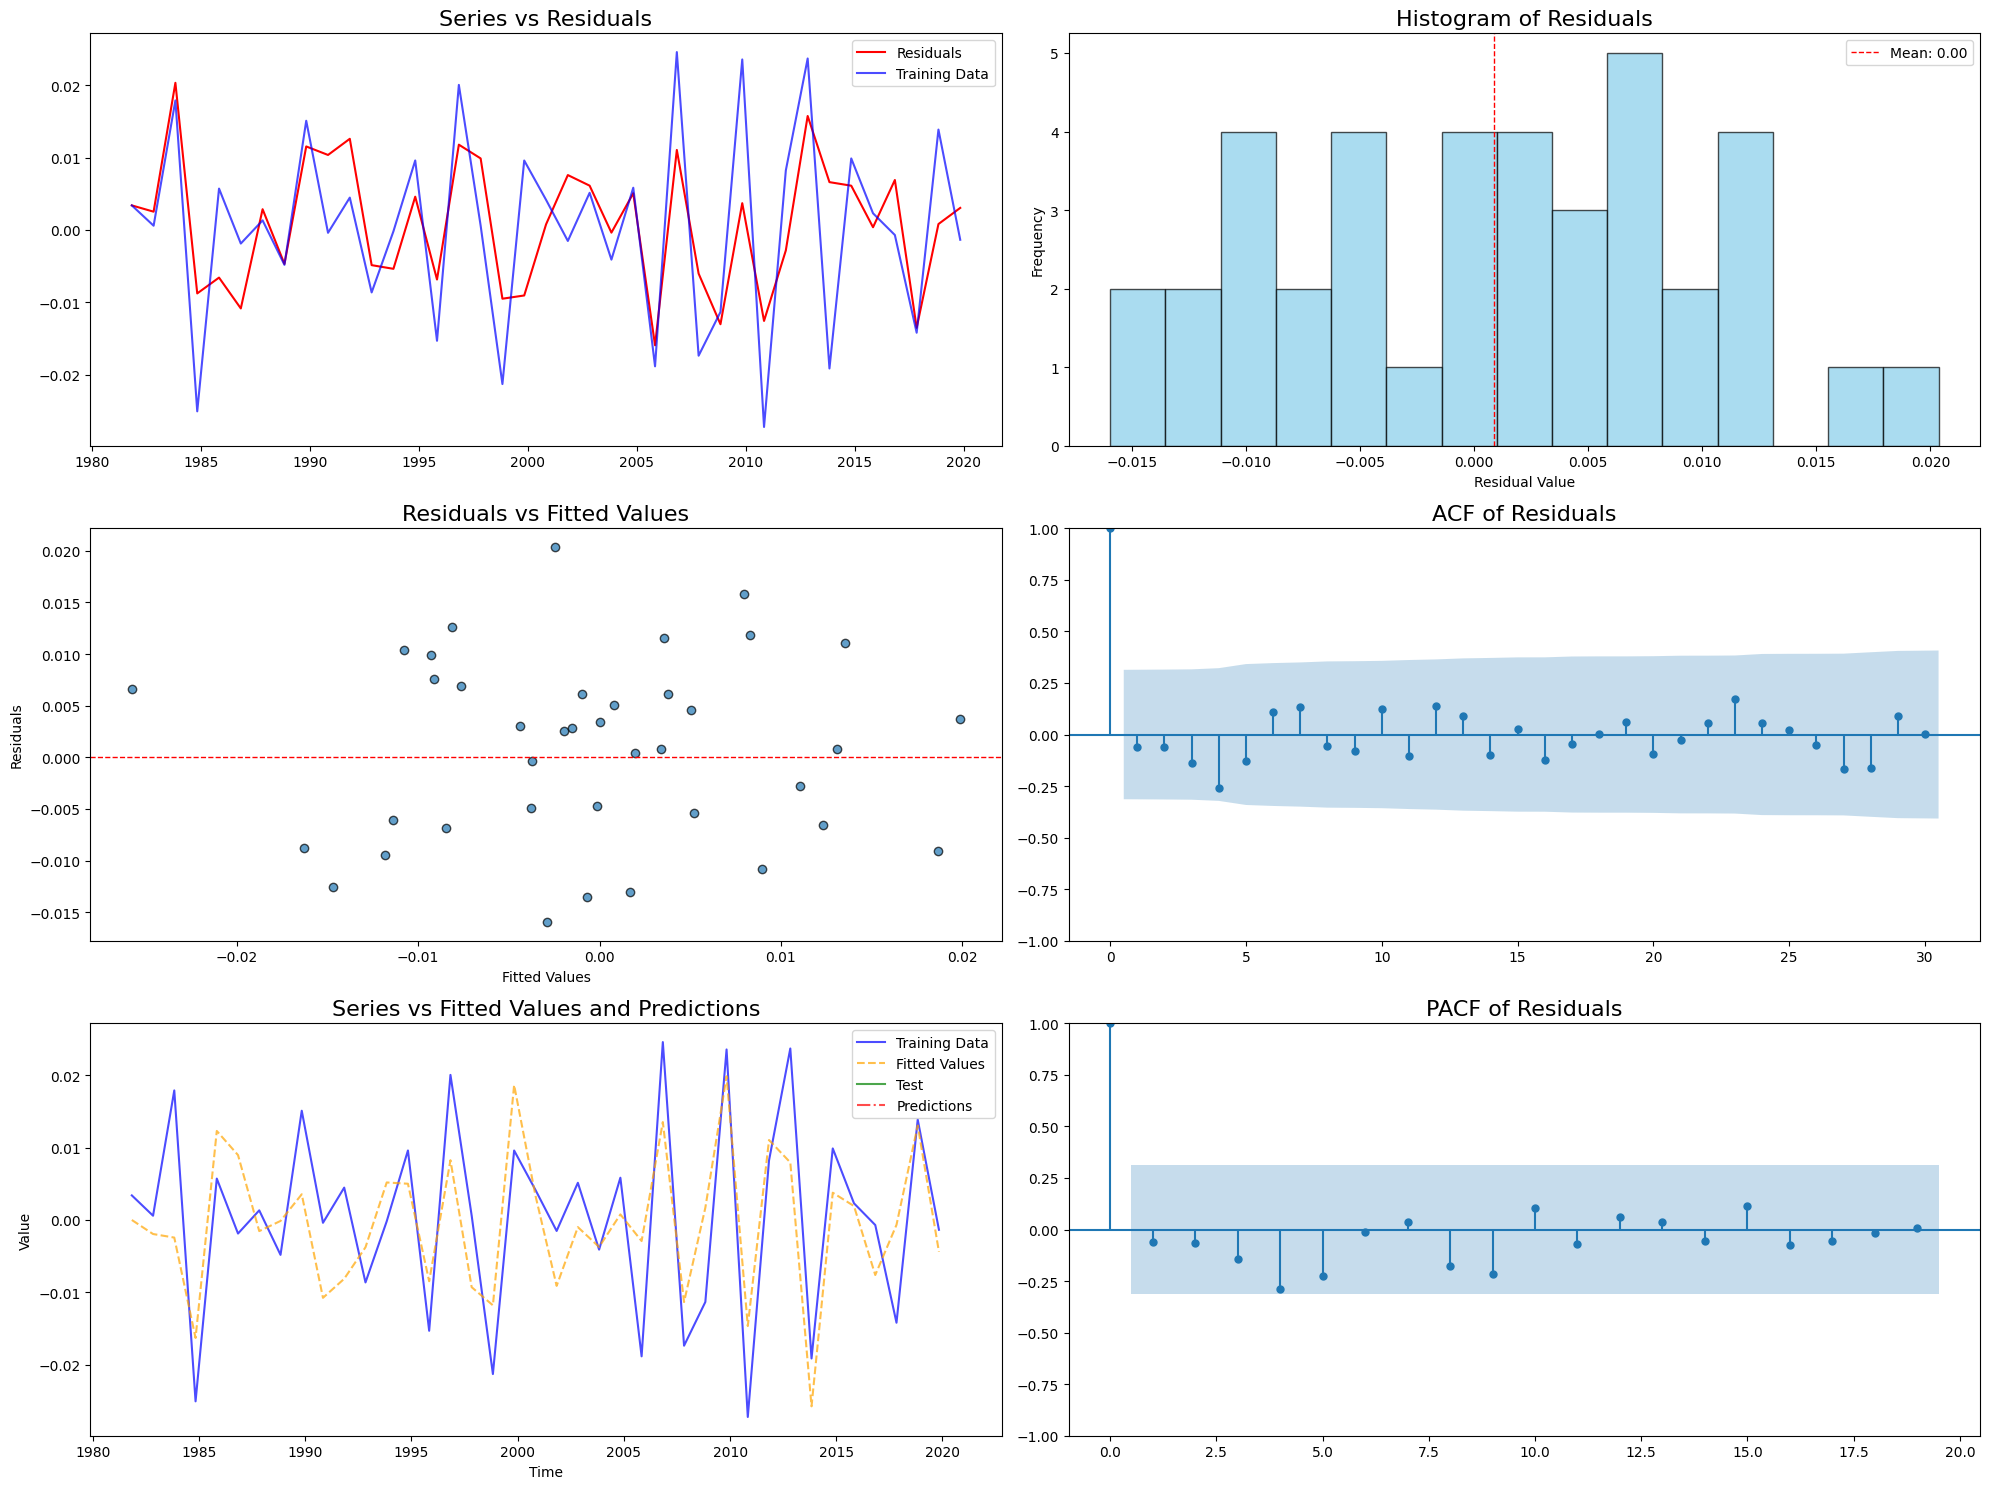

Métricas para conjunto 6:
  MAE: 0.0024
  RMSE: 0.0024
  y_test: -0.0090
  y_pred: -0.0066



Conjunto 7:
  Train: 1981 - 2020 (n=40)
  Test: 2021 - 2021 (n=1)


============================== Model Summary ==============================
                                         SARIMAX Results                                          
Dep. Variable:     Diff - BC - weighted_sum_precipitation   No. Observations:                   40
Model:                                     ARIMA(2, 0, 0)   Log Likelihood                 132.057
Date:                                    Tue, 04 Mar 2025   AIC                           -258.114
Time:                                            19:26:10   BIC                           -253.047
Sample:                                        11-01-1981   HQIC                          -256.282
                                             - 11-01-2020                                         
Covariance Type:                                      opg            

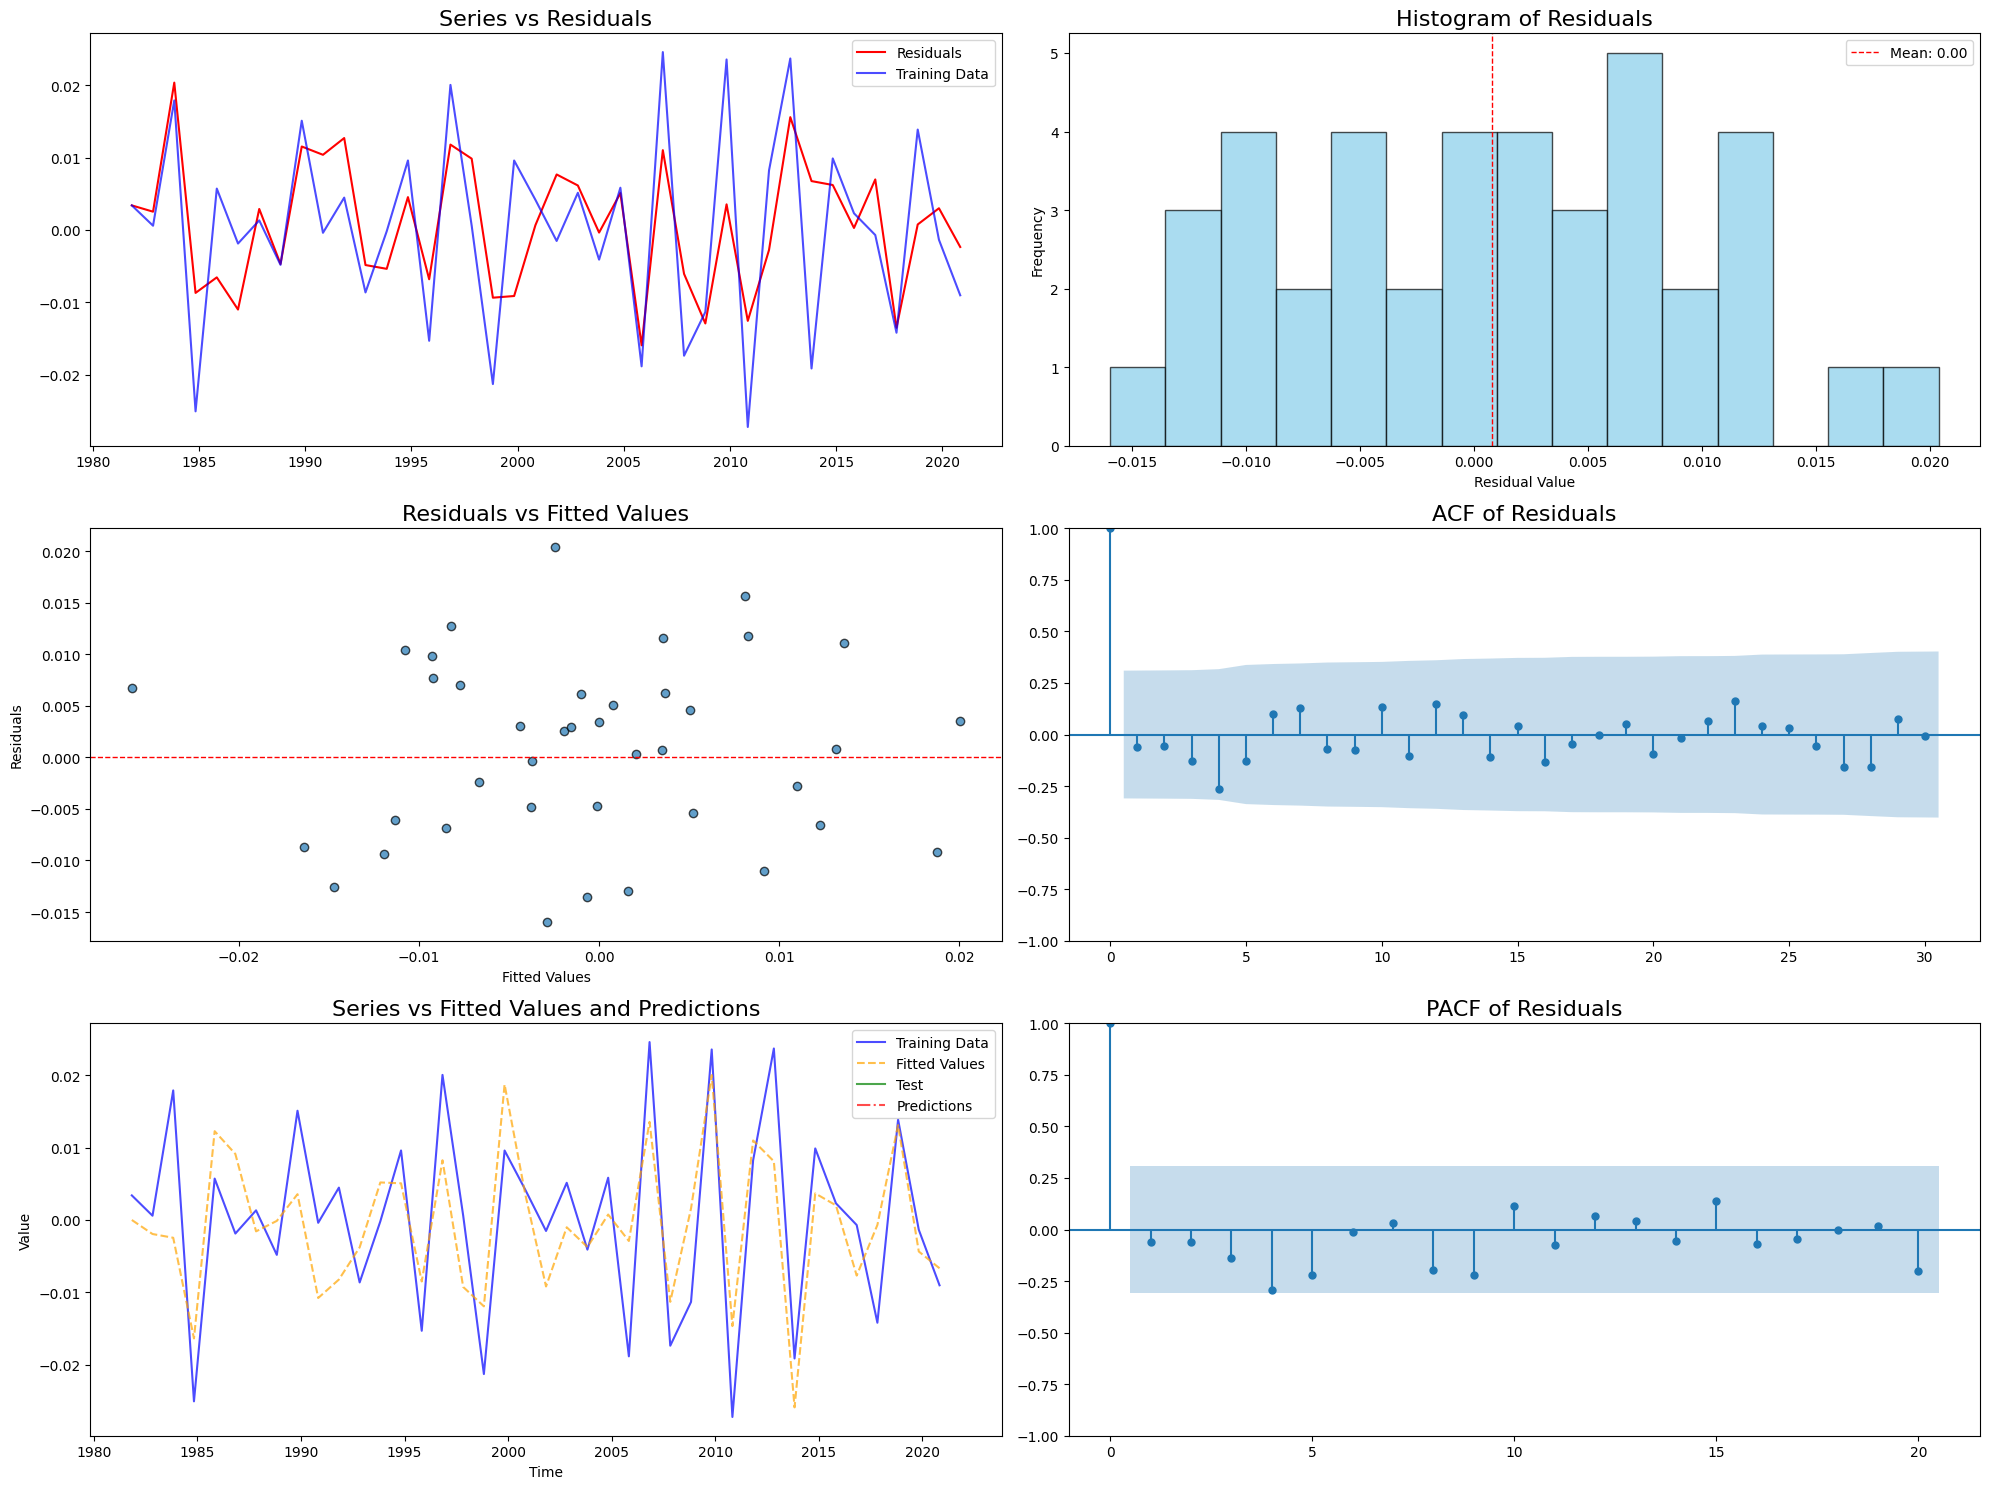

Métricas para conjunto 7:
  MAE: 0.0123
  RMSE: 0.0123
  y_test: -0.0035
  y_pred: 0.0089



Conjunto 8:
  Train: 1981 - 2021 (n=41)
  Test: 2022 - 2022 (n=1)


============================== Model Summary ==============================
                                         SARIMAX Results                                          
Dep. Variable:     Diff - BC - weighted_sum_precipitation   No. Observations:                   41
Model:                                     ARIMA(2, 0, 0)   Log Likelihood                 134.915
Date:                                    Tue, 04 Mar 2025   AIC                           -263.830
Time:                                            19:26:11   BIC                           -258.689
Sample:                                        11-01-1981   HQIC                          -261.958
                                             - 11-01-2021                                         
Covariance Type:                                      opg             

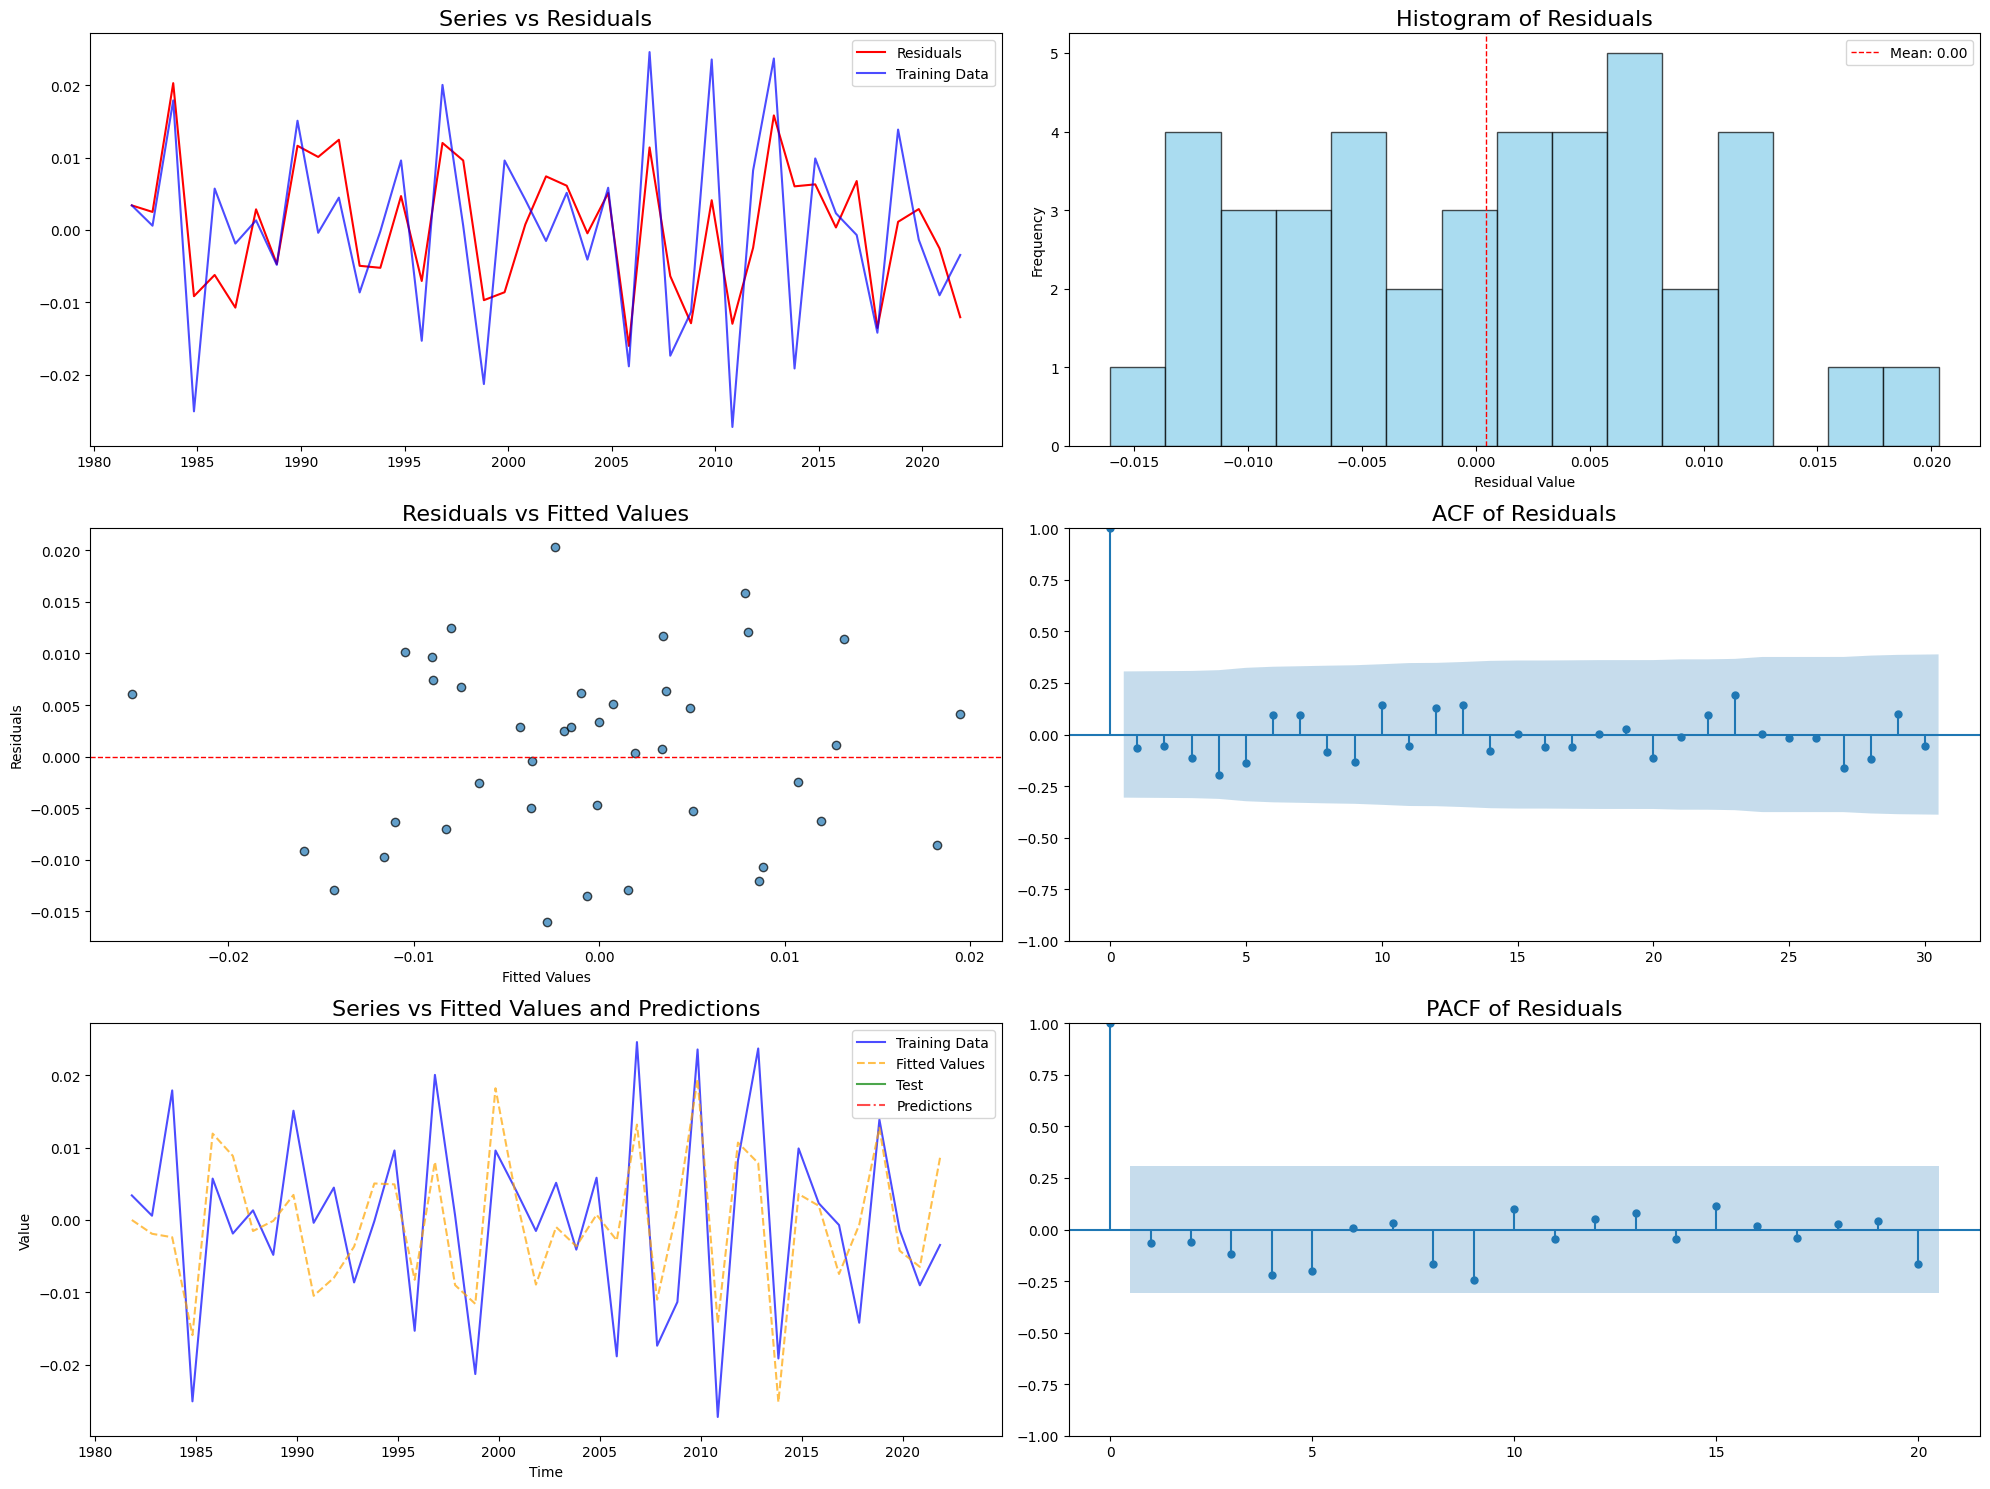

Métricas para conjunto 8:
  MAE: 0.0157
  RMSE: 0.0157
  y_test: -0.0077
  y_pred: 0.0080




RESULTADOS FINALES
                MAE      RMSE    y_test    y_pred
2014-2015  0.000063  0.000063  0.002308  0.002245
2015-2016  0.007346  0.007346 -0.000700 -0.008046
2016-2017  0.013522  0.013522 -0.014215 -0.000693
2017-2018  0.000816  0.000816  0.013890  0.013074
2018-2019  0.003167  0.003167 -0.001354 -0.004521
2019-2020  0.002447  0.002447 -0.009037 -0.006590
2020-2021  0.012319  0.012319 -0.003457  0.008862
2021-2022  0.015722  0.015722 -0.007725  0.007997


In [ ]:
resultados = []

# Estructuras para guardar predicciones:
cv_dates = []
cv_campana = []
cv_predictions = []
cv_actuals = []

# Iterar sobre cada split
for i, (trains, tests) in enumerate(train_test_sets):
    # Mostrar detalles del split
    print(f"\n{'='*50}\nConjunto {i+1}:")
    print(f"  Train: {trains.index.min().year} - {trains.index.max().year} (n={len(trains)})")
    print(f"  Test: {tests.index.min().year} - {tests.index.max().year} (n={len(tests)})")
    print(f"{'='*50}\n")

    # Entrenar modelo
    model = ARIMA(trains['Diff - BC - weighted_sum_precipitation'], order=(2, 0, 0), trend='n')
    results= model.fit()

    # Mostrar summary del modelo
    print(f"\n{'='*30} Model Summary {'='*30}")
    print(results.summary())
    print(f"{'='*75}\n")



    # Predecir y evaluar
    predictions = results.forecast(n_periods=1)
    metricas = evaluar_metricas(tests['Diff - BC - weighted_sum_precipitation'], predictions)

    # Dado que solo hay un valor, extraemos el escalar
    y_test_scalar = tests['Diff - BC - weighted_sum_precipitation'].iloc[0]
    y_pred_scalar = predictions[0]

    # Agregar los valores escalar al diccionario de métricas
    metricas["y_test"] = y_test_scalar
    metricas["y_pred"] = y_pred_scalar

    resultados.append(metricas)

    # Almacenamos los datos necesarios para plotear las predicciones luego.
    cv_dates.append(tests.index[0])
    cv_campana.append(tests['Campana'][0])
    cv_predictions.append(y_pred_scalar)
    cv_actuals.append(y_test_scalar)


    # Valores ajustados en train
    fitted_values = results.predict()
    # Residuos
    residuals = trains['Diff - BC - weighted_sum_precipitation'] - fitted_values

    print("len train", len(trains))
    print("len fitted values:",len(fitted_values))
    print("len residuals", len(residuals))
    print("\n")



    #Diagnostico residuos:
    plot_model_diagnostics(
        residuals,
        fitted_values,
        training_data = trains['Diff - BC - weighted_sum_precipitation'],
        test_data = tests['Diff - BC - weighted_sum_precipitation'],
        predictions = predictions
    )

    # Mostrar métricas para este split
    print(f"Métricas para conjunto {i+1}:")
    for k, v in metricas.items():
        print(f"  {k}: {v:.4f}")
    print("\n")

# Convertir resultados a DataFrame
df_rain = pd.DataFrame(
    resultados,
    index=[f"{train_end}-{test_year}" for (train_end, test_year) in train_test_splits]
)

# Mostrar resultados finales
print("\n\nRESULTADOS FINALES")
print("="*50)
print(df_rain)



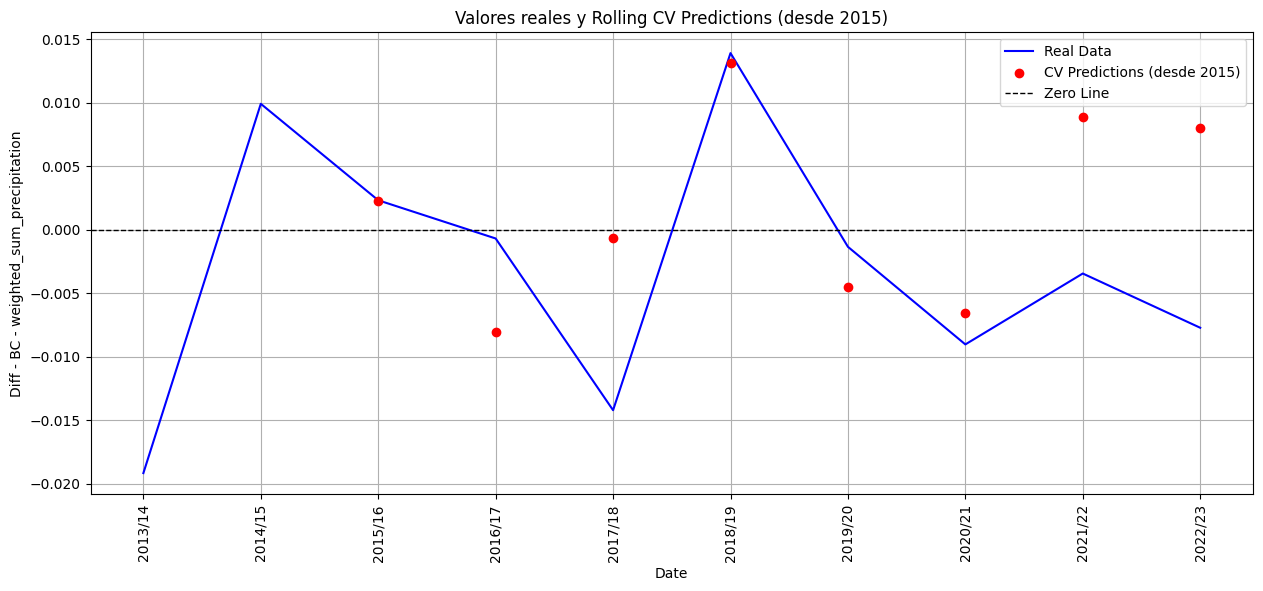

In [ ]:
# --------------------
# Plotting: Real data with Rolling CV Predictions since 2019
# --------------------

# Convert the CV predictions to a DataFrame
df_cv = pd.DataFrame({
    'Campana': cv_campana,
    'prediction': cv_predictions,
    'actual': cv_actuals
}, index=cv_dates).sort_index()


# Filter real data from 2010 onward
series_2012 = series[series.index.year >= 2013]

plt.figure(figsize=(15, 6))
# Plot the full real series
plt.plot(series_2012['Campana'], series_2012['Diff - BC - weighted_sum_precipitation'], label='Real Data', color='blue')

# Overlay the CV predictions as red dots (for 2010 onward)
plt.scatter(df_cv['Campana'], df_cv['prediction'], color='red', label='CV Predictions (desde 2015)', zorder=5)

# Horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Line')
# Labels and title
plt.xlabel('Date')
plt.ylabel('Diff - BC - weighted_sum_precipitation')
plt.title('Valores reales y Rolling CV Predictions (desde 2015)')
plt.legend()

# Guardamos la imagen en pdf:
plt.savefig("predictions_rain.pdf", format="pdf", dpi=300, bbox_inches="tight")
#Rotate x-axis labels for all subplots
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [ ]:
evaluar_metricas(df_cv['actual'], df_cv['prediction'])

{'MAE': 0.006925257785557447, 'RMSE': 0.009030754125741648}

# Consigna 10 - Modelo VAR

Dado que las series originales tienen diferentes niveles de integración, habiendo una de grado 0 (estacionaria) y dos de grado 1, no es posible verificar cointegración entre las 3.
Por ello, se procede directamente a la definición de un modelo VAR con las variables diferenciadas.

In [ ]:
# Se mantiene el set de train y test previamente utilizado:

# train_v = train[['Diff - Log - Rendimiento (Kg/Ha)', 'weighted_avg_ratio_temp', 'Diff - BC - weighted_sum_precipitation']]
# test_v = test[['Diff - Log - Rendimiento (Kg/Ha)', 'weighted_avg_ratio_temp', 'Diff - BC - weighted_sum_precipitation']]


train_v = train[['Diff - Log - Rendimiento (Kg/Ha)', 'Diff - BC - weighted_sum_precipitation']]
test_v = test[['Diff - Log - Rendimiento (Kg/Ha)', 'Diff - BC - weighted_sum_precipitation']]


In [ ]:
train_v.head()

Diff - Log - Rendimiento (Kg/Ha)  \
start_year                                     
1981-11-01                         -0.025259   
1982-11-01                         -0.242012   
1983-11-01                          0.584429   
1984-11-01                         -0.152100   
1985-11-01                          0.198306   

            Diff - BC - weighted_sum_precipitation  
start_year                                          
1981-11-01                                0.003401  
1982-11-01                                0.000589  
1983-11-01                                0.017926  
1984-11-01                               -0.025095  
1985-11-01                                0.005728

In [ ]:
train_v.shape

(41, 2)

In [ ]:
# Creo mi modelo VAR:
var_model = VAR(train_v)
lag_selection = var_model.select_order(maxlags=7)

print(lag_selection.summary())  # See best lag based on AIC, BIC, HQIC

# Select best lag (BIC is often preferred)
best_lag = lag_selection.bic


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -12.92      -12.83   2.458e-06      -12.89
1      -13.17      -12.90   1.917e-06      -13.07
2     -13.50*     -13.05*  1.381e-06*     -13.34*
3      -13.37      -12.74   1.581e-06      -13.16
4      -13.18      -12.38   1.930e-06      -12.91
5      -13.16      -12.17   2.021e-06      -12.82
6      -13.24      -12.08   1.924e-06      -12.85
7      -13.09      -11.75   2.342e-06      -12.64
-------------------------------------------------


Según el criterio BIC, la cantidad de lags óptimos es 0. Esto concuerda con el hecho de que 'weighted_avg_ratio_temp' no tenga componente autorregresiva significativa. Por ello, si sus valores pasados no influyen sobre los valores presentes, tampoco lo harán sobre otras variables.

In [ ]:
# Select best lag (AIC)
best_lag = lag_selection.aic

In [ ]:
# Fit de modelo
results = var_model.fit(best_lag)

In the context of a Vector Autoregression (VAR) model, stability refers to whether the system’s dynamics produce time series that remain bounded (do not explode to infinity) as they evolve over time. A stable VAR ensures that shocks to the system dissipate rather than amplify, making the model suitable for forecasting and impulse response analysis. Let’s break down what determines stability in a VAR and what can make it unstable.

In [ ]:
# Se revisa estabilidad del modelo:

# Get eigenvalues of the companion matrix
try:
  eigenvalues = np.abs(results.roots)

  # Print results
  print("Eigenvalues:", eigenvalues)
  print("Is the model stable?", np.all(eigenvalues < 1))

except:
  print("results.roots esta vacio")

Eigenvalues: [6.58045468 2.31803757 1.3064823  1.3064823 ]
Is the model stable? False


IRF check

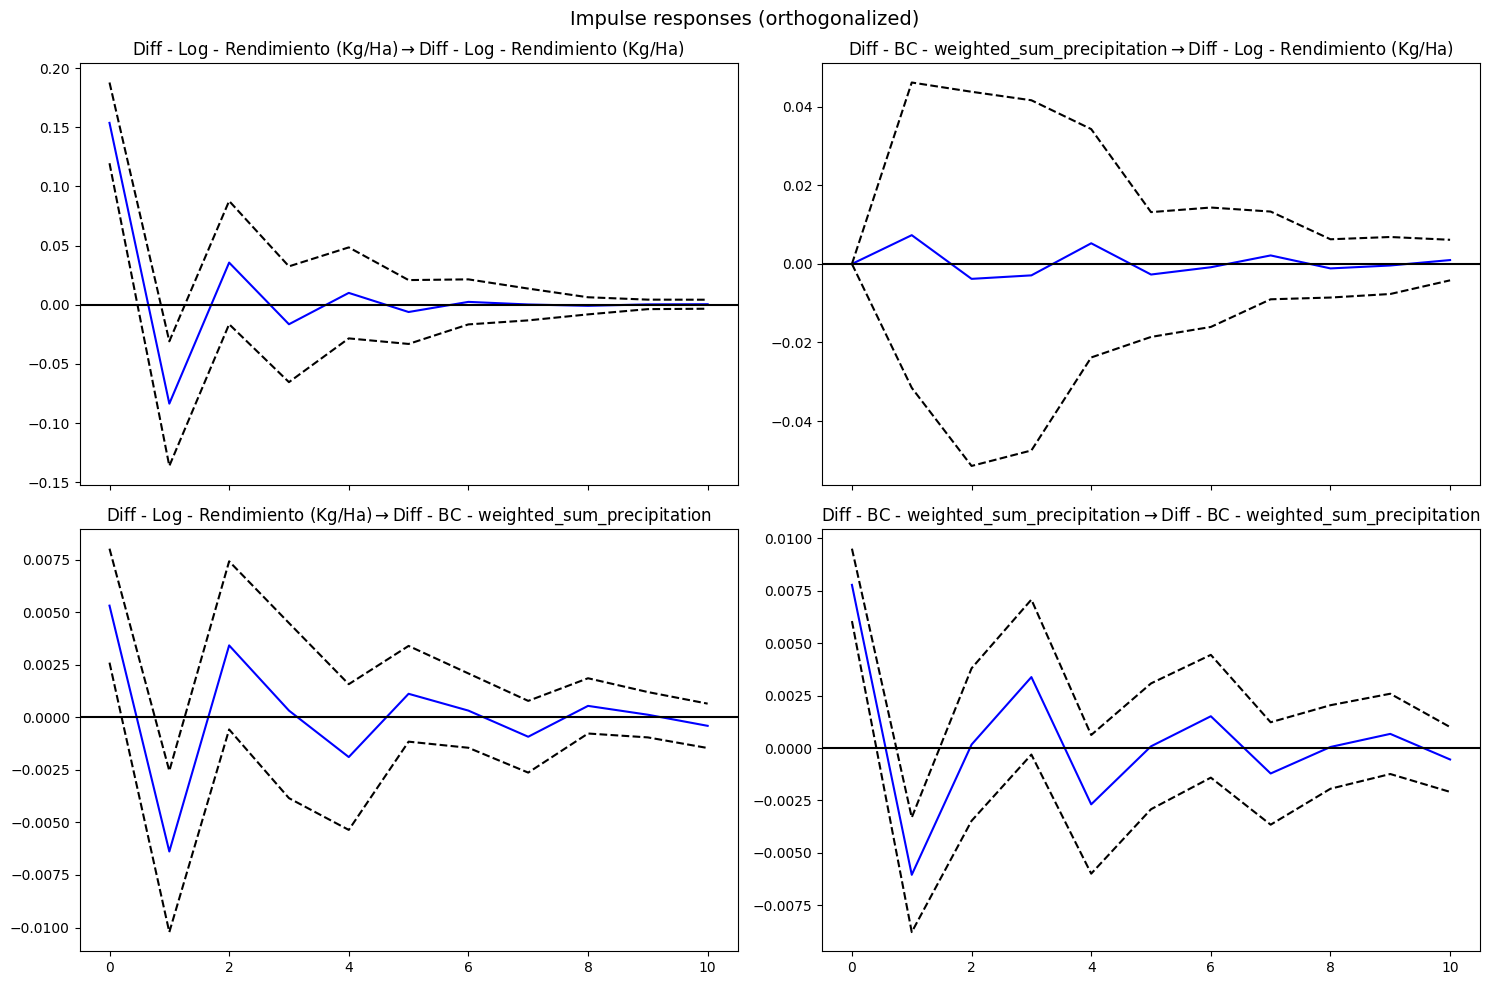

In [ ]:
# 📉 11️⃣ Función de respuesta al impulso (IRF)
irf = results.irf(10)  # Simulamos 10 periodos

# Generate the IRF plots with better layout
irf.plot(orth=True, figsize=(15, 10))


# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("irf.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
check_non_stationarity(series['Diff - Log - Rendimiento (Kg/Ha)'], 'Diff- Log - Rendimiento (Kg/Ha)')

=== Comprehensive Non-Stationarity Analysis for 'Diff- Log - Rendimiento (Kg/Ha)' ===
- Seasonal decomposition failed (likely insufficient data).

=== Conclusions ===
- ✅ Reject unit root (ADF with trend): Data is likely trend-stationary.
- ✅ KPSS supports stationarity.


ADF suggests 0 differences
KPSS suggests 0 differences




{'ADF Tests': {'ADF (constant)': {'Test Statistic': -10.206358088378828,
   'p-value': 5.790555497182131e-18,
   'Critical Values': {'1%': -3.60098336718852,
    '5%': -2.9351348158036012,
    '10%': -2.6059629803688282}},
  'ADF (trend)': {'Test Statistic': -10.35553028508693,
   'p-value': 4.185588665635153e-16,
   'Critical Values': {'1%': -4.198435183325837,
    '5%': -3.5236066465953773,
    '10%': -3.1927730539313126}}},
 'KPSS Test': {'Test Statistic': 0.07561048577683446,
  'p-value': 0.1,
  'Critical Values': {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}},
 'Seasonal Strength': None}

In [ ]:
check_non_stationarity(series['Diff - BC - weighted_sum_precipitation'], 'Diff - BC - weighted_sum_precipitation')

=== Comprehensive Non-Stationarity Analysis for 'Diff - BC - weighted_sum_precipitation' ===
- Seasonal decomposition failed (likely insufficient data).

=== Conclusions ===
- ✅ Reject unit root (ADF with trend): Data is likely trend-stationary.
- ❌ KPSS rejects stationarity: Series may have a trend or unit root.


ADF suggests 0 differences
KPSS suggests 1 differences




{'ADF Tests': {'ADF (constant)': {'Test Statistic': -9.70124267308915,
   'p-value': 1.0707850729719401e-16,
   'Critical Values': {'1%': -3.6055648906249997,
    '5%': -2.937069375,
    '10%': -2.606985625}},
  'ADF (trend)': {'Test Statistic': -9.807534900299153,
   'p-value': 5.945949529675275e-15,
   'Critical Values': {'1%': -4.2049611718749995,
    '5%': -3.52660646875,
    '10%': -3.1944928125}}},
 'KPSS Test': {'Test Statistic': 0.1653374183905993,
  'p-value': 0.03388548467450059,
  'Critical Values': {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}},
 'Seasonal Strength': None}

### VAR con 5 lags

In [ ]:
results_2 = var_model.fit(5)

In [ ]:
# Se revisa estabilidad del modelo:

# Get eigenvalues of the companion matrix
eigenvalues = np.abs(results_2.roots)

# Print results
print("Eigenvalues:", eigenvalues)
print("Is the model stable?", np.all(eigenvalues < 1))

Eigenvalues: [1.60189988 1.5083594  1.5083594  1.40147035 1.40147035 1.2915165
 1.2915165  1.19635815 1.19635815 1.12374682]
Is the model stable? False


Sigue sin ser estable

### VAR con 3 lags

In [ ]:
results_3 = var_model.fit(3)

In [ ]:
# Se revisa estabilidad del modelo:

# Get eigenvalues of the companion matrix
eigenvalues = np.abs(results_3.roots)

# Print results
print("Eigenvalues:", eigenvalues)
print("Is the model stable?", np.all(eigenvalues < 1))

Eigenvalues: [12.55760052  1.47591205  1.47591205  1.25855086  1.22145763  1.22145763]
Is the model stable? False


### Root Causes of Instability

**a. Severe Overparameterization**

Parameters per equation:

7 lags:
k
⋅
p
=
3
×
7
=
21
k⋅p=3×7=21 parameters + intercept → 22 parameters.

5 lags:
3
×
5
=
15
3×5=15 parameters + intercept → 16 parameters.

Effective sample size:

Total
T
=
34
T=34, so
T
−
p
=
27
T−p=27 (for 7 lags) or
29
29 (for 5 lags).

Rule of thumb:
T
−
p
>
5
⋅
k
⋅
p
T−p>5⋅k⋅p.

For 7 lags:
5
⋅
3
⋅
7
=
105
5⋅3⋅7=105 →
27
≪
105
27≪105.

For 5 lags:
5
⋅
3
⋅
5
=
75
5⋅3⋅5=75 →
29
≪
75
29≪75.

Result: Extreme overfitting → noisy estimates → unstable eigenvalues

### VAR con 1 lag

In [ ]:
results_1 = var_model.fit(1)

In [ ]:
# Se revisa estabilidad del modelo:

# Get eigenvalues of the companion matrix
eigenvalues = np.abs(results_1.roots)

# Print results
print("Eigenvalues:", eigenvalues)
print("Is the model stable?", np.all(eigenvalues < 1))

Eigenvalues: [2.05458431 2.05458431]
Is the model stable? False


Conclusión: mis raíces pueden estar muy cercanas a uno. Por ello mi VAR diverge.

Testear cointegración - Primero si fitea un VAR a mis variables sin diferenciar para determinar la cantidad de lags a incluir:

In [ ]:
# 🔗 6️⃣ Prueba de cointegración de Johansen
train_coint = train[['Log - Rendimiento (Kg/Ha)', 'BC - weighted_sum_precipitation']]

# Creo mi modelo VAR:
var_model = VAR(train_coint)
lag_selection = var_model.select_order(maxlags=7)

print(lag_selection.summary())  # See best lag based on AIC, BIC, HQIC


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -11.95      -11.86   6.434e-06      -11.92
1     -13.72*     -13.45*  1.103e-06*     -13.63*
2      -13.58      -13.13   1.267e-06      -13.43
3      -13.60      -12.97   1.252e-06      -13.39
4      -13.47      -12.67   1.444e-06      -13.20
5      -13.29      -12.30   1.779e-06      -12.95
6      -13.44      -12.27   1.580e-06      -13.04
7      -13.41      -12.06   1.712e-06      -12.95
-------------------------------------------------


Se procede entonces a testear Johansen con 1 lag:

In [ ]:
johansen_test = coint_johansen(train_coint, det_order=0, k_ar_diff=1)
print("🚀 Prueba de Cointegración (valores propios):", johansen_test.lr1)
print("Valores criticos (5%):", johansen_test.cvt[:,1] )


🚀 Prueba de Cointegración (valores propios): [25.49177989  5.08838108]
Valores criticos (5%): [15.4943  3.8415]


Se observa que el estadístico 25.49 > 15.49 (valor crítico) - por ende, se rechaza la hipótesis nula de que no existe cointegración, existe al menos un nivel de cointegración.

In [ ]:
from statsmodels.tsa.vector_ar.vecm import VECM

train_coint = train[['Log - Rendimiento (Kg/Ha)', 'BC - weighted_sum_precipitation']]
test_coint = test[['Log - Rendimiento (Kg/Ha)', 'BC - weighted_sum_precipitation']]

# Define the model with cointegration rank=1 (from Johansen test)
vecm_model = VECM(train_coint, k_ar_diff=1, coint_rank=1)
vecm_results = vecm_model.fit()

# Print summary
print(vecm_results.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation Log - Rendimiento (Kg/Ha)
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
L1.Log - Rendimiento (Kg/Ha)          -0.4869      0.142     -3.429      0.001      -0.765      -0.209
L1.BC - weighted_sum_precipitation     0.1338      1.883      0.071      0.943      -3.556       3.824
Det. terms outside the coint. relation & lagged endog. parameters for equation BC - weighted_sum_precipitation
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
L1.Log - Rendimiento (Kg/Ha)          -0.0179      0.011     -1.594      0.111      -0.040       0.004
L1.BC - weighted_sum_precipitation    -0.4461      0.149     -3